#imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools

#functions

In [ ]:
def prepare_data(dataFrame: pd.DataFrame, target: str):
    # get target data
    n_cols = 1
    dataset = dataFrame[target]
    dataset = pd.DataFrame(dataset)
    data = dataset.values

    # split into test & train data sizes
    train_size = int(len(data) * 0.75)
    test_size = len(data) - train_size
    #logger.info(f"Train Size: {train_size} Test Size: {test_size}")

    # scale data between (0, 1)
    scaler = MinMaxScaler(feature_range= (0, 1))
    scaled_data = scaler.fit_transform(np.array(data))
    train_data = scaled_data[0:train_size, :]

    # Creating a Training set with 60 time-steps
    x_train = []
    y_train = []
    time_steps = 60
    n_cols = 1

    for i in range(time_steps, len(scaled_data)):
        x_train.append(scaled_data[i-time_steps:i, :n_cols])
        y_train.append(scaled_data[i, :n_cols])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
    return x_train, y_train, scaler, train_size, test_size, scaled_data

In [ ]:
def generate_forecast(scaled_data, train_size) -> (np.array, np.array):
    time_steps = 60
    test_data = scaled_data[train_size - time_steps:, :]

    x_test = []
    y_test = []
    n_cols = 1

    for i in range(time_steps, len(test_data)):
        x_test.append(test_data[i-time_steps:i, 0:n_cols])
        y_test.append(test_data[i, 0:n_cols])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

    return x_test, y_test

In [ ]:
def generate_forecast_v2(dataFrame: pd.DataFrame, target: str) -> (np.array, np.array):
    # get target data
    dataset = dataFrame[target]
    dataset = pd.DataFrame(dataset)
    data = dataset.values

    # split into test & train data sizes. ! Need only to make offset !
    train_size = int(len(data) * 0.05)
    test_size = len(data) - train_size

    # scale data between (0, 1)
    scaler = MinMaxScaler(feature_range= (0, 1))
    scaled_data = scaler.fit_transform(np.array(dataset))
    train_data = scaled_data[0:train_size, :]

    # Creating a Training set with 60 time-steps
    x_train = []
    y_train = []
    time_steps = 60
    n_cols = 1

    for i in range(time_steps, len(scaled_data)):
        x_train.append(scaled_data[i-time_steps:i, :n_cols])
        y_train.append(scaled_data[i, :n_cols])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

    test_data = scaled_data[train_size - time_steps:, :]

    x_test = []
    y_test = []
    n_cols = 1

    for i in range(time_steps, len(test_data)):
        x_test.append(test_data[i-time_steps:i, 0:n_cols])
        y_test.append(test_data[i, 0:n_cols])
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

    return x_test, y_test, train_size

In [ ]:
# def show_type_1(data: pd.DataFrame) -> None:
#     plt.figure(figsize=(26, 18))
#     colors = ['#FF7F50', '#DDA0DD', '#66CDAA', '#BC8F8F']

#     for i, j in enumerate(data.columns):
#       plt.subplot(len(data.columns) + 1, 1, i + 1)
#       plt.plot(data[j], color=colors[i]);
#       plt.plot(data[j].rolling(30).mean());
#       plt.ylabel(j, fontsize=16)
#       plt.grid()
#     plt.xlabel('Date', fontsize=16)

#losses and optimisers

In [ ]:
mse_loss = tf.keras.losses.MeanSquaredError()
mae_loss = tf.keras.losses.MeanAbsoluteError()
huber_loss = tf.keras.losses.Huber()

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

adamw = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
    )

#data loading

##Delhi Climate

In [ ]:
df = pd.read_csv('/content/DailyDelhiClimateTrain.csv')

df_test = pd.read_csv('/content/DailyDelhiClimateTest.csv')

df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

df_test.date = pd.to_datetime(df_test.date)
df_test.set_index('date', inplace=True)

In [ ]:
df_test = pd.read_csv('/content/DailyDelhiClimateTest.csv')

df_test.date = pd.to_datetime(df_test.date)
df_test.set_index('date', inplace=True)

In [ ]:
# df = df[(df['meantemp'] > 980) & (df['meantemp'] < 1050)]
# data_to_show = df#df.drop('date', axis=1)
# show_type_1(data_to_show)

Везде для простоты условимся, что будем предсказывать среднесуточную температуру, так как затем будет проще сравнивать

##Sophist HSE - INVFC_M - месячные показатели инвестиций в основной капитал



In [ ]:
df = pd.read_csv('/content/INVFC_M.csv')

# df.date = pd.to_datetime(df_test.date)
# df.set_index('date', inplace=True)

##Sophist HSE - CPI_M_CHI - месячные показатели инвестиций в основной капитал



#decomposition

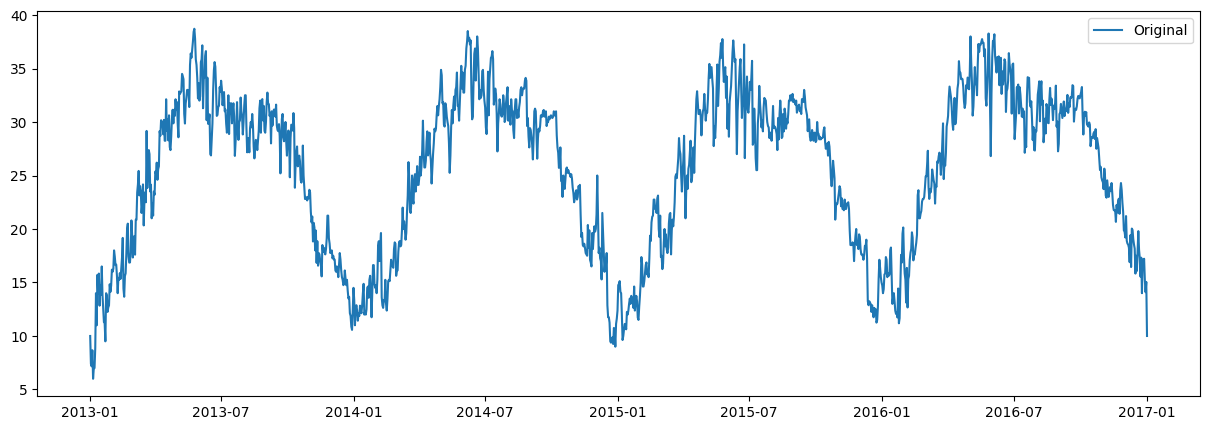

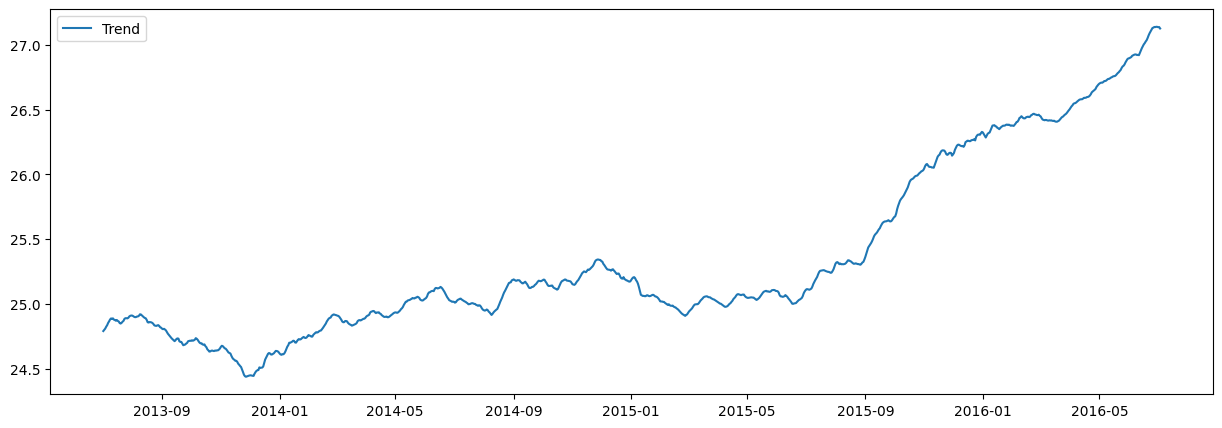

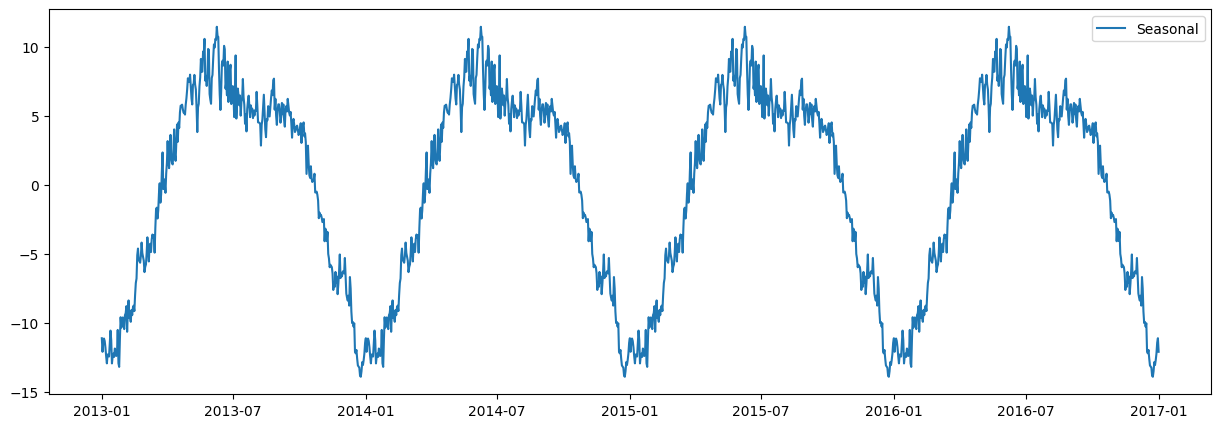

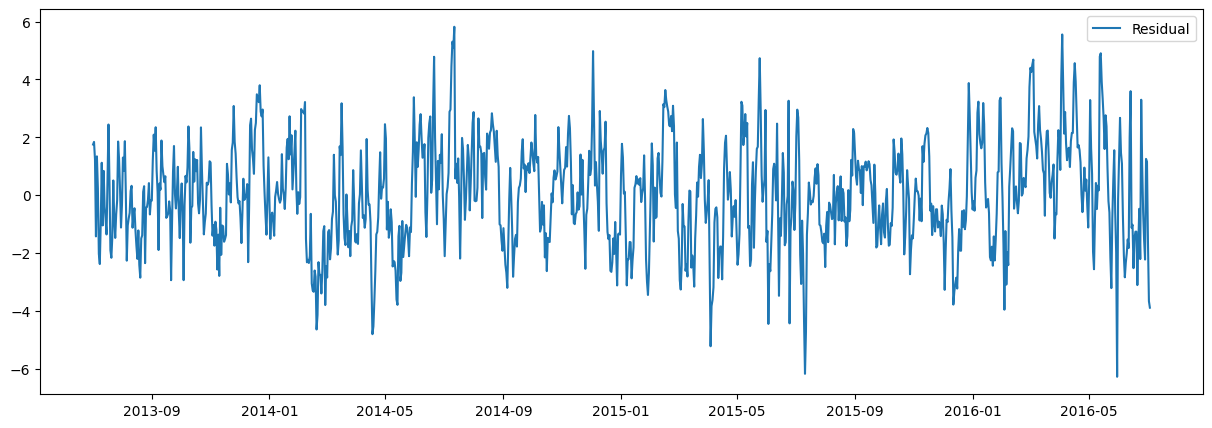

In [ ]:
ts_decomposition = seasonal_decompose(x=df['meantemp'], model='additive', period=365)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

plt.figure(figsize=(15,5))
plt.plot(df['meantemp'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [ ]:
x_train, y_train, scaler, train_size, test_size, scaled_data = prepare_data(df, "meantemp")

In [ ]:
train_size

1096

In [ ]:
test_size

366

In [ ]:
scaled_data

array([[0.12227074],
       [0.04279476],
       [0.0356623 ],
       ...,
       [0.24745269],
       [0.276718  ],
       [0.12227074]])

#Models

In [ ]:
RMSE_scores = {}
MAE_scores = {}

##LSTM

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
44/44 [==============================] - 8s 56ms/step - loss: 0.0462
Epoch 2/30
44/44 [==============================] - 2s 56ms/step - loss: 0.0063
Epoch 3/30
44/44 [==============================] - 2s 56ms/step - loss: 0.0052
Epoch 4/30
44/44 [==============================] - 3s 58ms/step - loss: 0.0052
Epoch 5/30
44/44 [==============================] - 3s 78ms/step - loss: 0.0049
Epoch 6/30
44/44 [==============================] - 2s 56ms/step - loss: 0.0047
Epoch 7/30
44/44 [==============================] - 2s 56ms/step - loss: 0.0048
Epoch 8/30
44/44 [==============================] - 2s 55ms/step - loss: 0.0051
Epoch 9/30
44/44 [==============================] - 3s 74ms/step - loss: 0.0048
Epoch 10/30
44/44 [==============================] - 3s 71ms/step - loss: 0.0047
Epoch 11/30
44/44 [==============================] - 3s 59ms/step - loss: 0.0045
Epoch 12/30
44/44 [==============================] - 2s 57ms/step - loss: 0.0044
Epoch 13/30
44/44 [==================

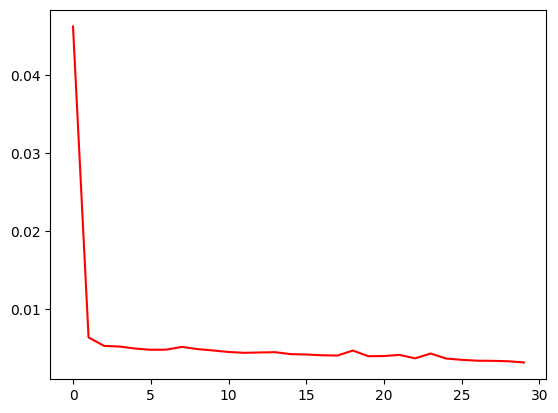

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 22ms/step


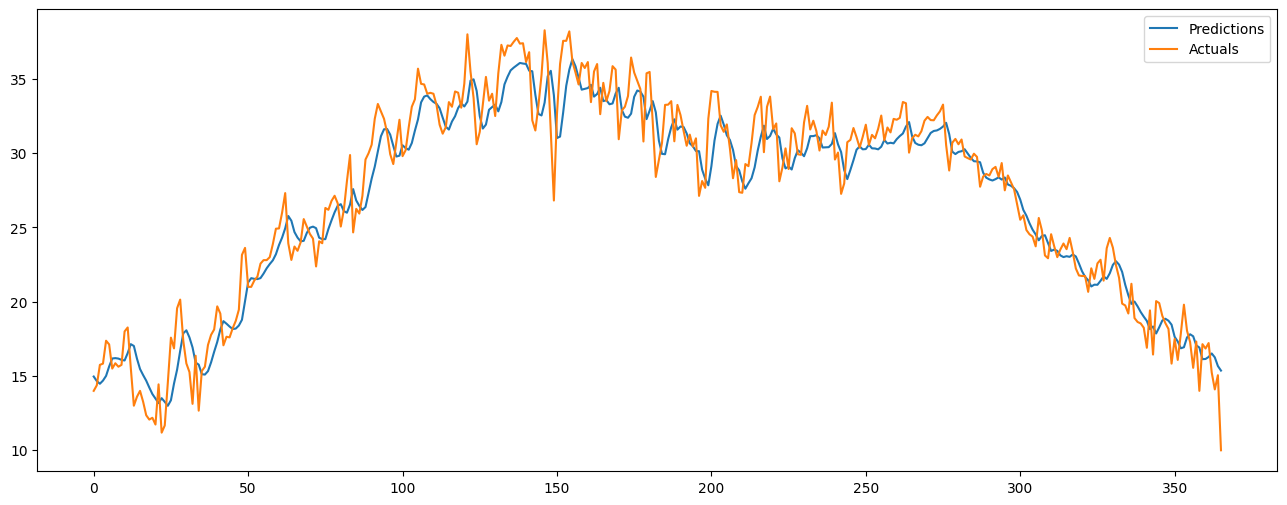

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

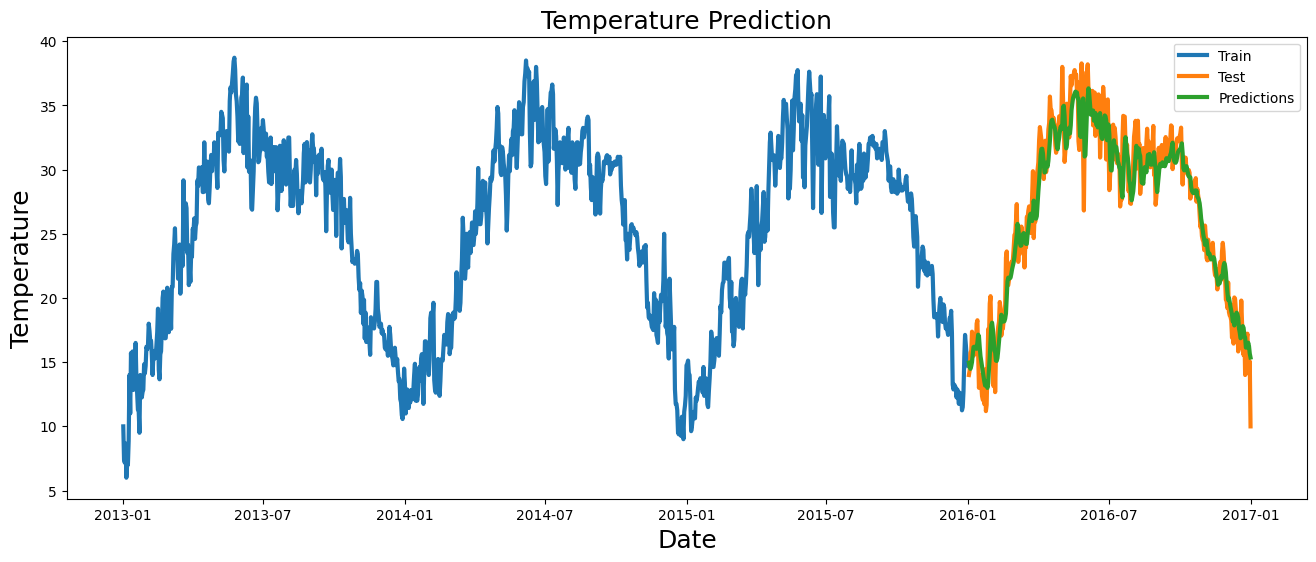

In [ ]:
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

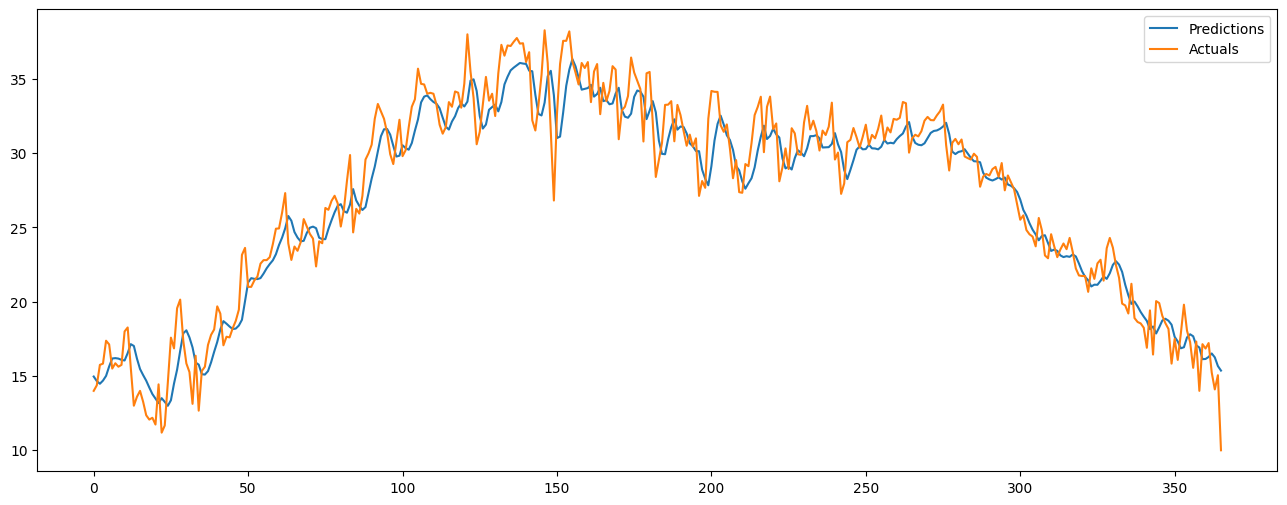

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

12/12 [==============================] - 0s 19ms/step


(366, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(y_test - predictions)**2)
RMSE

0.4150877528111086

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.432693534315683

In [ ]:
RMSE_scores["LSTM"] = RMSE
MAE_scores["LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions    Actuals
0      14.964599  14.000000
1      14.658098  14.375000
2      14.477649  15.750000
3      14.690981  15.833333
4      15.007286  17.375000
..           ...        ...
361    16.282185  17.217391
362    16.518589  15.238095
363    16.255327  14.095238
364    15.670224  15.052632
365    15.364361  10.000000

[366 rows x 2 columns]

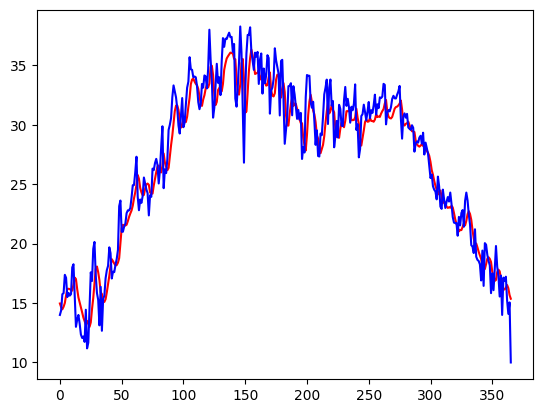

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##another LSTM

In [ ]:
model = Sequential([
    LSTM(units=25, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=25, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
44/44 [==============================] - 7s 48ms/step - loss: 0.0859
Epoch 2/30
44/44 [==============================] - 2s 50ms/step - loss: 0.0087
Epoch 3/30
44/44 [==============================] - 2s 50ms/step - loss: 0.0064
Epoch 4/30
44/44 [==============================] - 2s 50ms/step - loss: 0.0060
Epoch 5/30
44/44 [==============================] - 3s 61ms/step - loss: 0.0058
Epoch 6/30
44/44 [==============================] - 3s 61ms/step - loss: 0.0055
Epoch 7/30
44/44 [==============================] - 2s 50ms/step - loss: 0.0054
Epoch 8/30
44/44 [==============================] - 2s 49ms/step - loss: 0.0052
Epoch 9/30
44/44 [==============================] - 2s 53ms/step - loss: 0.0050
Epoch 10/30
44/44 [==============================] - 2s 54ms/step - loss: 0.0052
Epoch 11/30
44/44 [==============================] - 3s 67ms/step - loss: 0.0051
Epoch 12/30
44/44 [==============================] - 2s 49ms/step - loss: 0.0047
Epoch 13/30
44/44 [==================

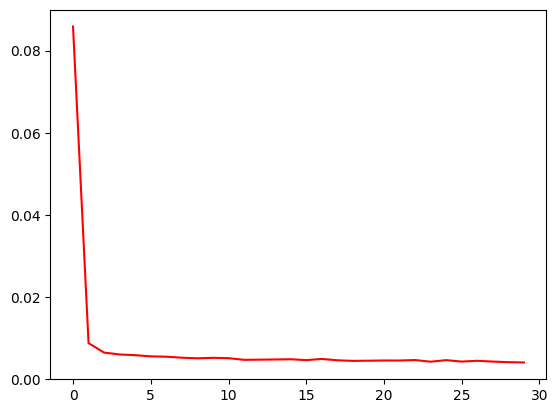

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 22ms/step


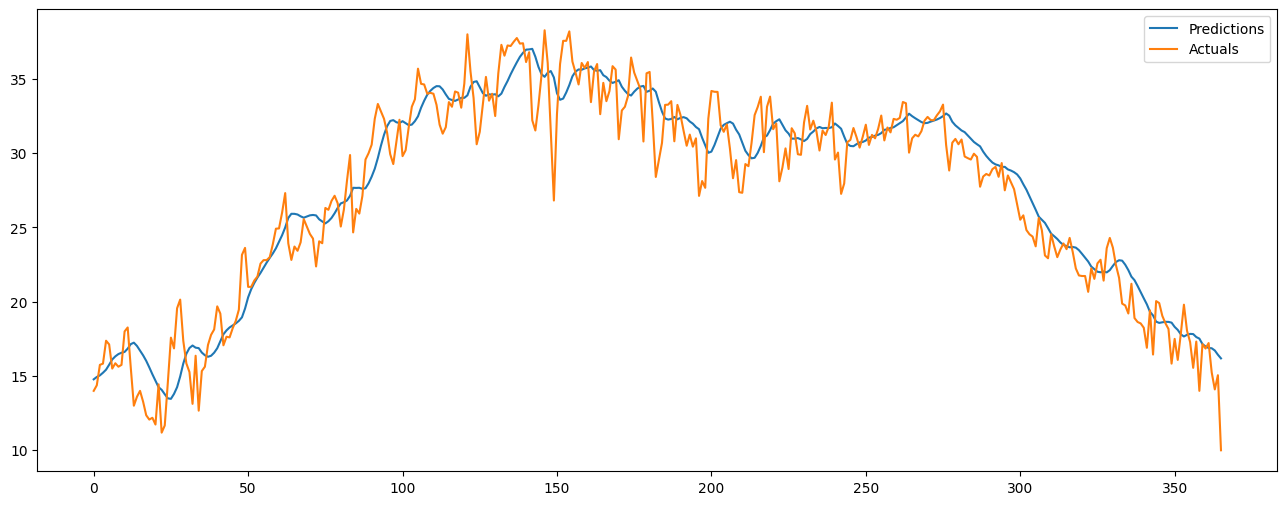

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

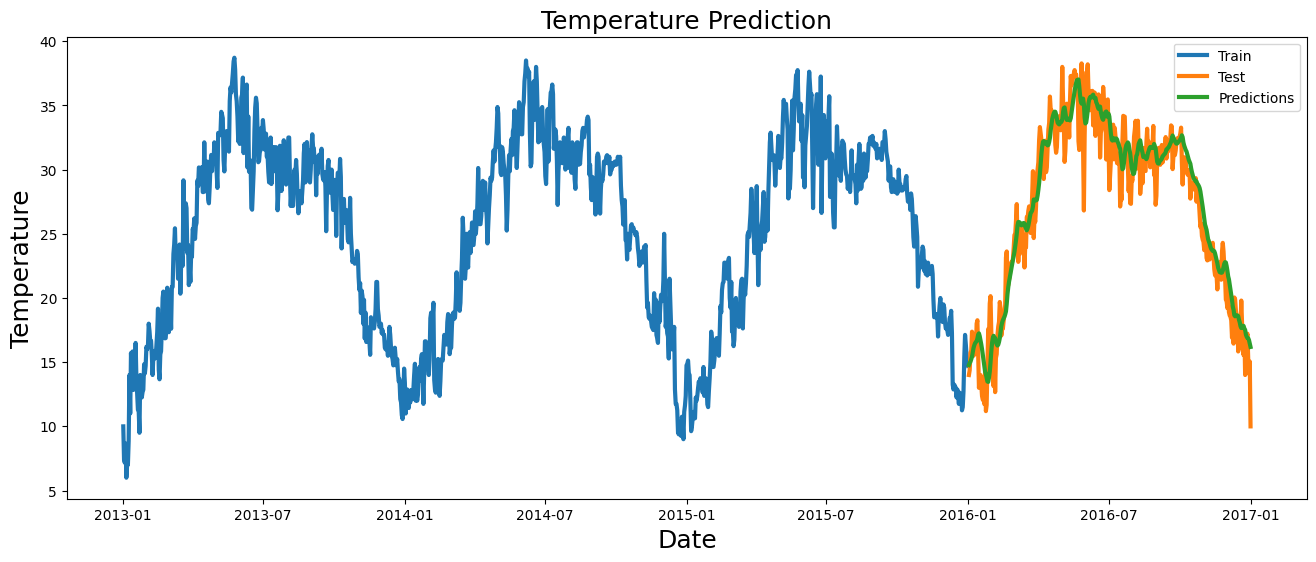

In [ ]:
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

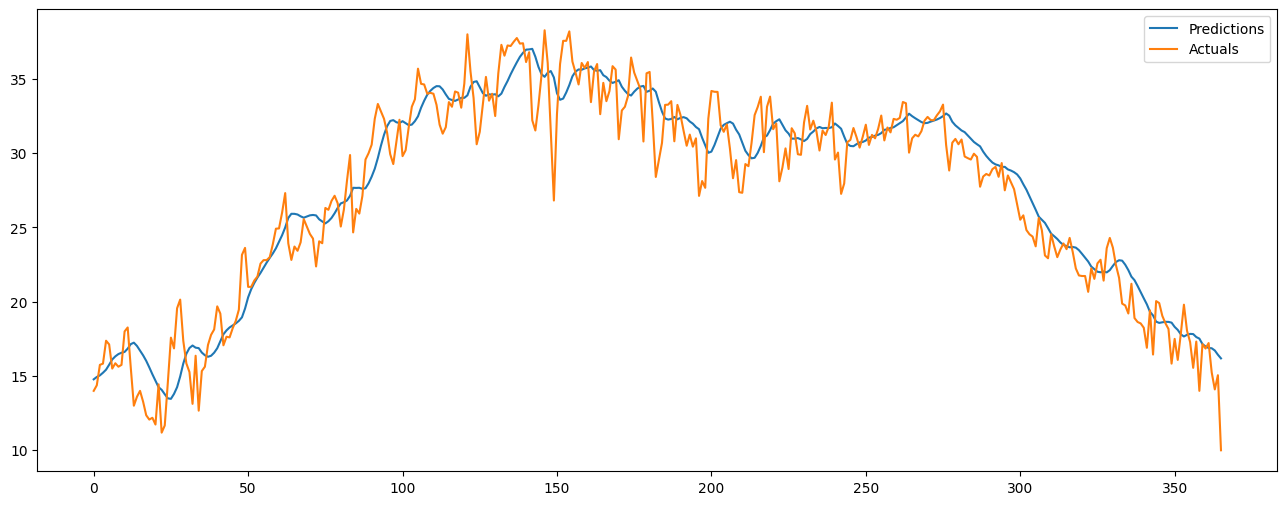

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

12/12 [==============================] - 0s 13ms/step


(366, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.4233947235119201

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.5467081856108238

In [ ]:
RMSE_scores["another_LSTM"] = RMSE
MAE_scores["another_LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions    Actuals
0      14.775390  14.000000
1      14.934493  14.375000
2      15.041913  15.750000
3      15.219965  15.833333
4      15.425216  17.375000
..           ...        ...
361    16.885870  17.217391
362    16.866877  15.238095
363    16.718124  14.095238
364    16.432291  15.052632
365    16.185965  10.000000

[366 rows x 2 columns]

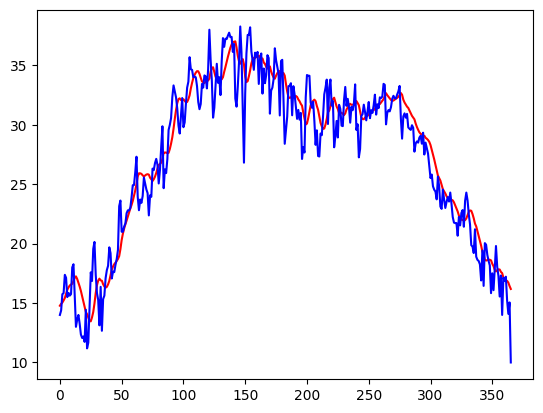

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##GRU

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()

    # Input layer
    model.add(layers.GRU(units = units, return_sequences = True,
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(layers.Dropout(0.2))

    # Hidden layer
    model.add(layers.GRU(units = units))
    model.add(layers.Dropout(0.2))
    model.add(Dense(units = 1))

    #Compile model
    #model.compile(optimizer='adam',loss='mse')
    return model
model = create_gru(64)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
44/44 [==============================] - 9s 66ms/step - loss: 0.0534
Epoch 2/30
44/44 [==============================] - 3s 66ms/step - loss: 0.0083
Epoch 3/30
44/44 [==============================] - 3s 79ms/step - loss: 0.0075
Epoch 4/30
44/44 [==============================] - 4s 81ms/step - loss: 0.0066
Epoch 5/30
44/44 [==============================] - 3s 66ms/step - loss: 0.0066
Epoch 6/30
44/44 [==============================] - 3s 71ms/step - loss: 0.0065
Epoch 7/30
44/44 [==============================] - 4s 88ms/step - loss: 0.0064
Epoch 8/30
44/44 [==============================] - 3s 78ms/step - loss: 0.0064
Epoch 9/30
44/44 [==============================] - 3s 67ms/step - loss: 0.0058
Epoch 10/30
44/44 [==============================] - 3s 71ms/step - loss: 0.0055
Epoch 11/30
44/44 [==============================] - 4s 88ms/step - loss: 0.0057
Epoch 12/30
44/44 [==============================] - 3s 68ms/step - loss: 0.0054
Epoch 13/30
44/44 [==================

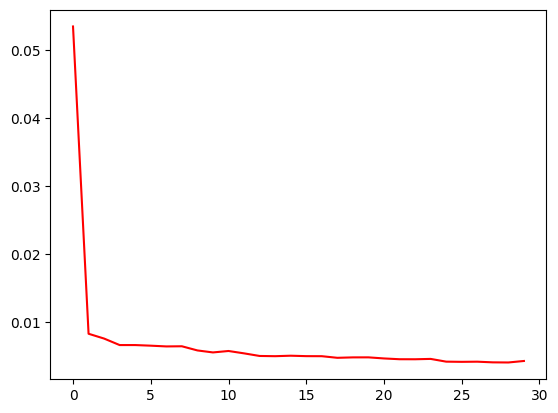

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 1s 18ms/step


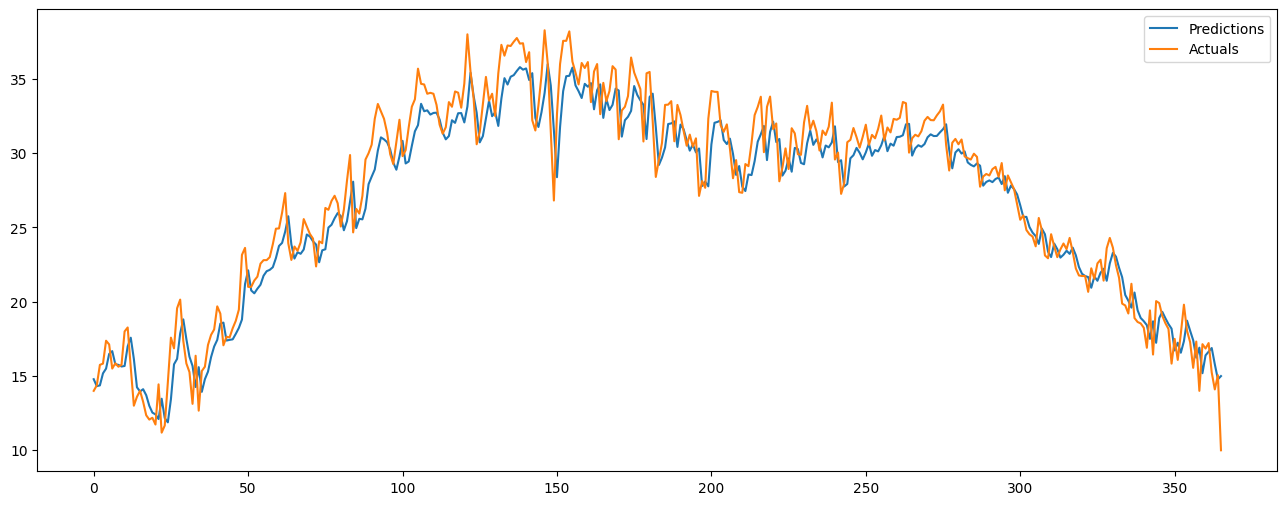

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

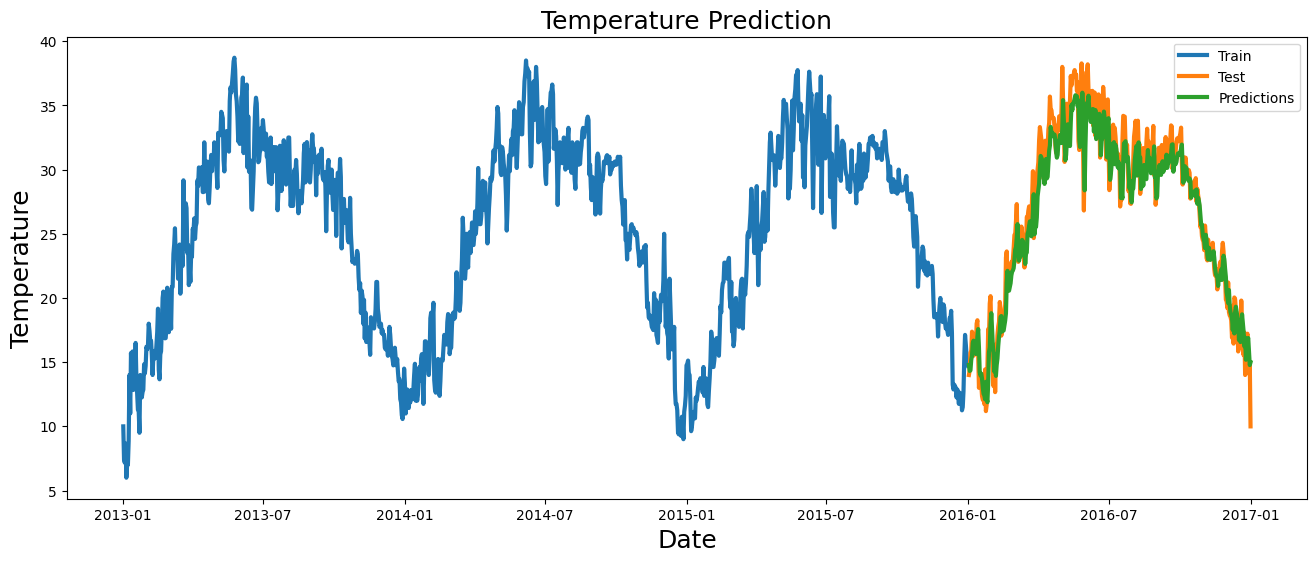

In [ ]:
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

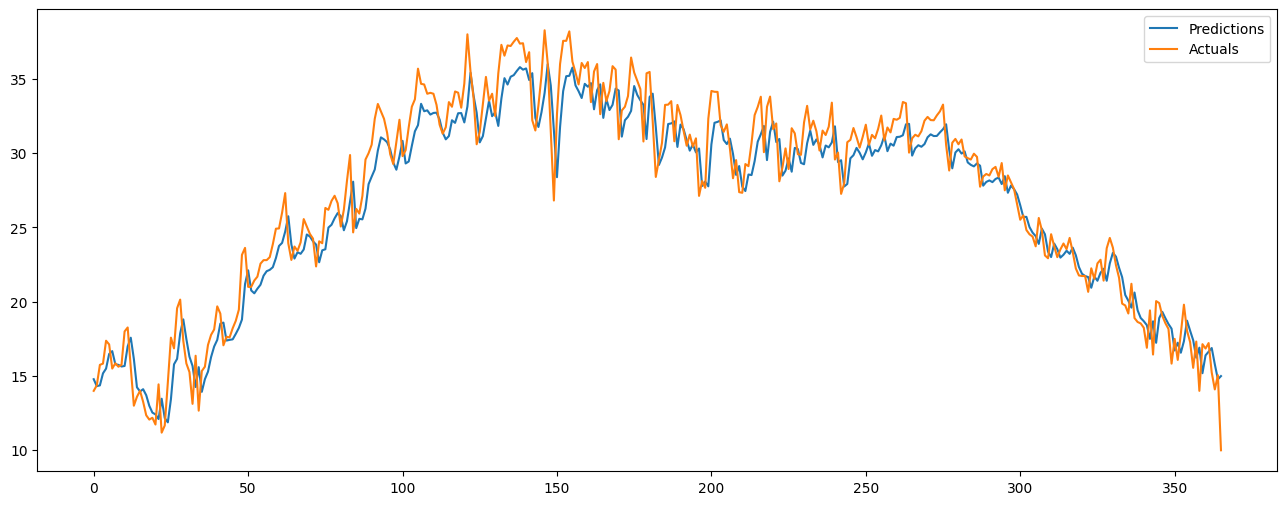

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

12/12 [==============================] - 0s 17ms/step


(366, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

0.6774869598585346

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.423702944377521

In [ ]:
RMSE_scores["GRU"] = RMSE
MAE_scores["GRU"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions    Actuals
0      14.785076  14.000000
1      14.317488  14.375000
2      14.367761  15.750000
3      15.177263  15.833333
4      15.498018  17.375000
..           ...        ...
361    16.640814  17.217391
362    16.883141  15.238095
363    15.790380  14.095238
364    14.775933  15.052632
365    14.995223  10.000000

[366 rows x 2 columns]

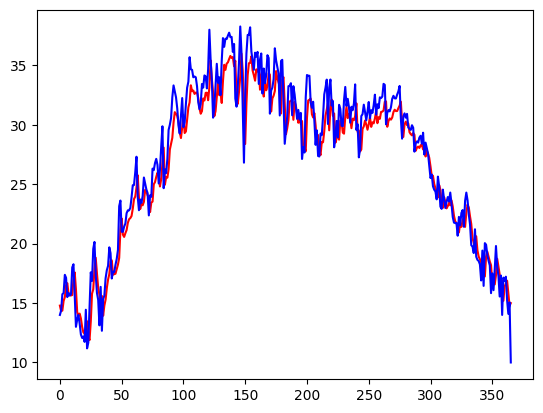

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##BiLSTM

bidirectional LSTM

In [ ]:
# Create BiLSTM model
def create_bilstm(units):
  model = Sequential()

  # Input layer
  model.add(layers.Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))

  # Hidden layer
  model.add(layers.Bidirectional(LSTM(units = units)))
  model.add(Dense(1))

  return model

model = create_bilstm(64)

In [ ]:
#Compile model
model.compile(optimizer="adam",loss="mse")

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
44/44 [==============================] - 15s 136ms/step - loss: 0.0448
Epoch 2/30
44/44 [==============================] - 6s 136ms/step - loss: 0.0071
Epoch 3/30
44/44 [==============================] - 6s 128ms/step - loss: 0.0043
Epoch 4/30
44/44 [==============================] - 6s 146ms/step - loss: 0.0040
Epoch 5/30
44/44 [==============================] - 5s 121ms/step - loss: 0.0038
Epoch 6/30
44/44 [==============================] - 7s 150ms/step - loss: 0.0039
Epoch 7/30
44/44 [==============================] - 6s 126ms/step - loss: 0.0041
Epoch 8/30
44/44 [==============================] - 7s 154ms/step - loss: 0.0037
Epoch 9/30
44/44 [==============================] - 5s 123ms/step - loss: 0.0036
Epoch 10/30
44/44 [==============================] - 7s 153ms/step - loss: 0.0036
Epoch 11/30
44/44 [==============================] - 5s 122ms/step - loss: 0.0035
Epoch 12/30
44/44 [==============================] - 7s 152ms/step - loss: 0.0037
Epoch 13/30
44/44 [=====

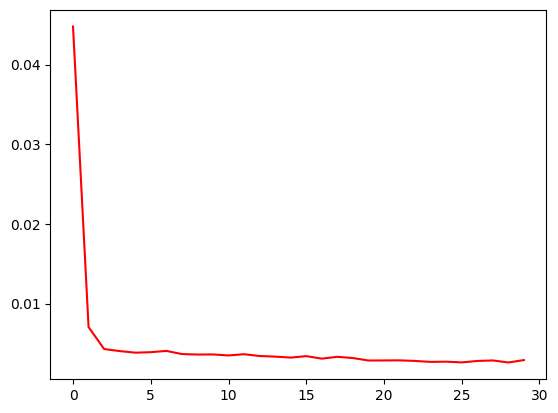

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 35ms/step


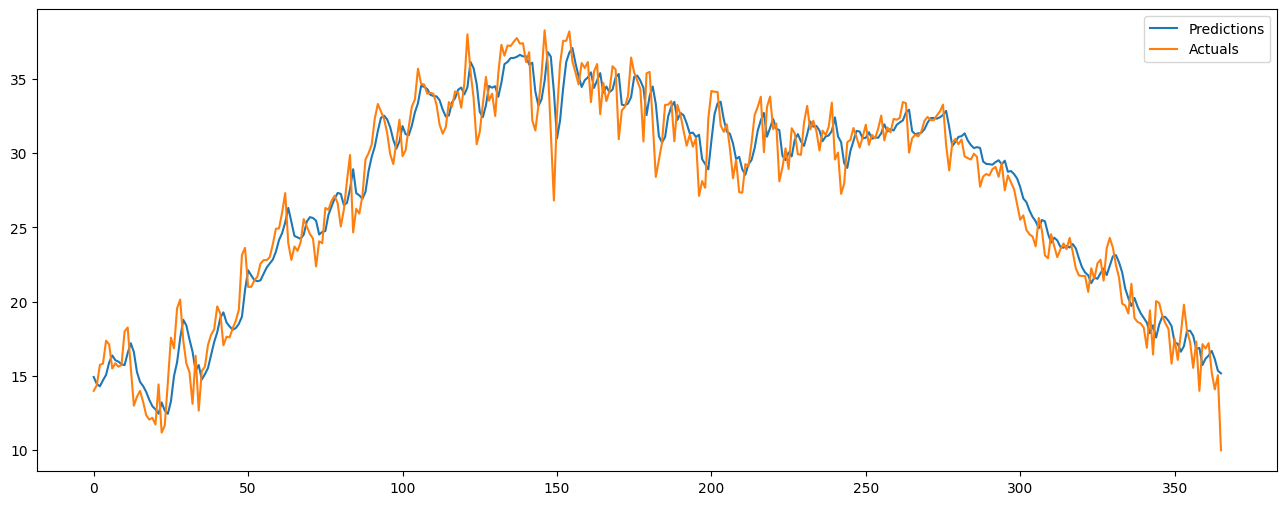

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

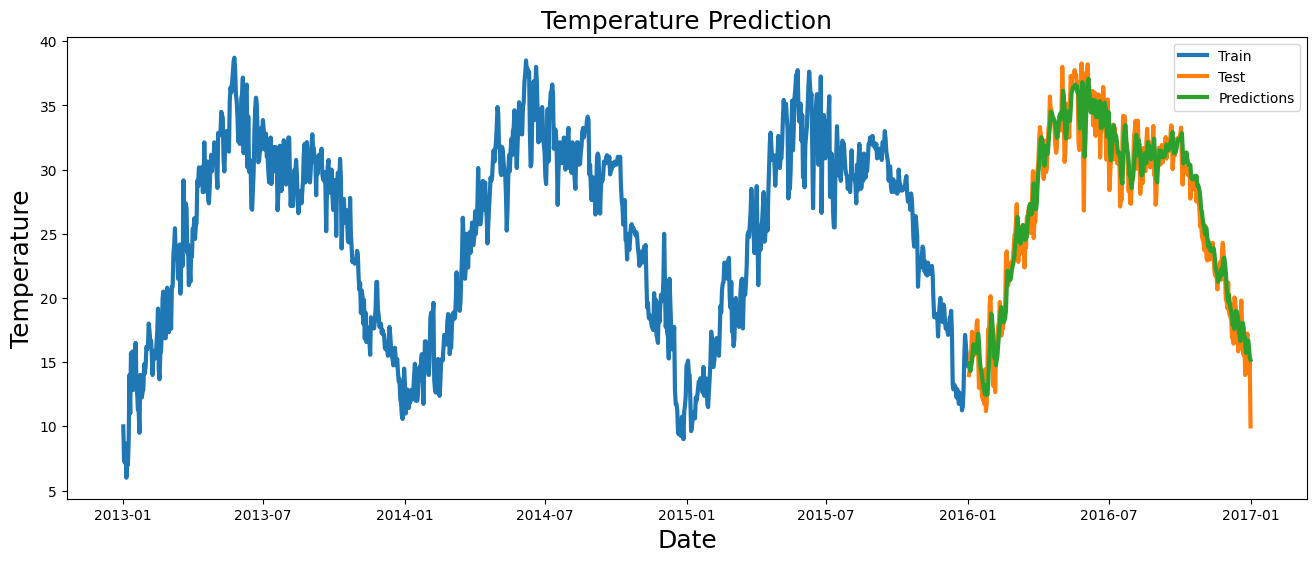

In [ ]:
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Temperature Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Temperature', fontsize= 18)
plt.plot(train['meantemp'], linewidth= 3)
plt.plot(test['meantemp'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

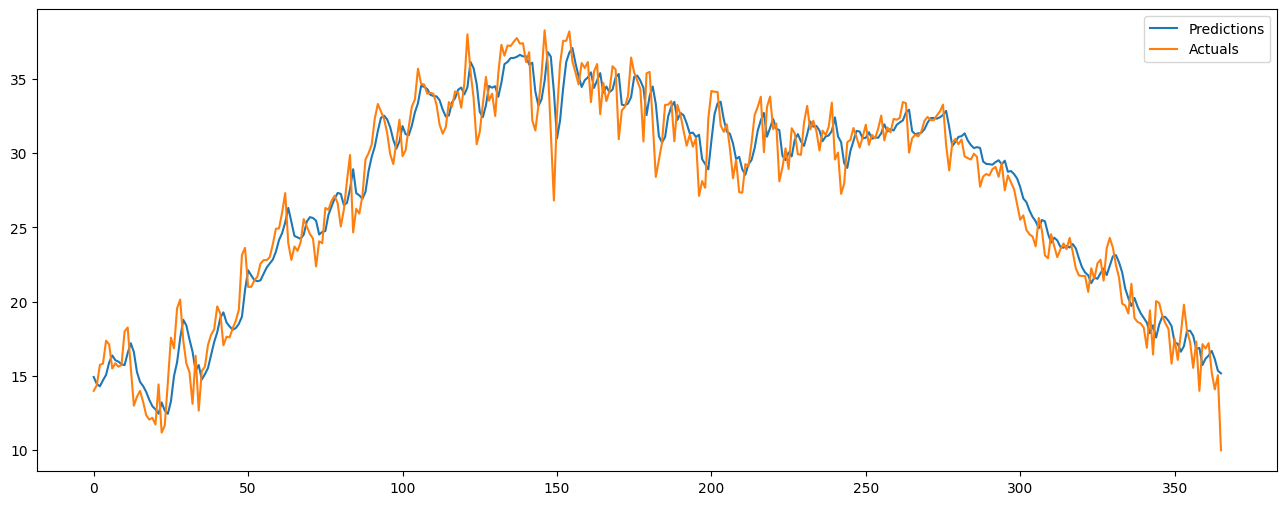

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

12/12 [==============================] - 0s 32ms/step


(366, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.17100303860974977

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.2745226347495335

In [ ]:
RMSE_scores["BiLSTM"] = RMSE
MAE_scores["BiLSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions    Actuals
0      14.933931  14.000000
1      14.464648  14.375000
2      14.303827  15.750000
3      14.713628  15.833333
4      15.077097  17.375000
..           ...        ...
361    16.375711  17.217391
362    16.688066  15.238095
363    16.143627  14.095238
364    15.353875  15.052632
365    15.177697  10.000000

[366 rows x 2 columns]

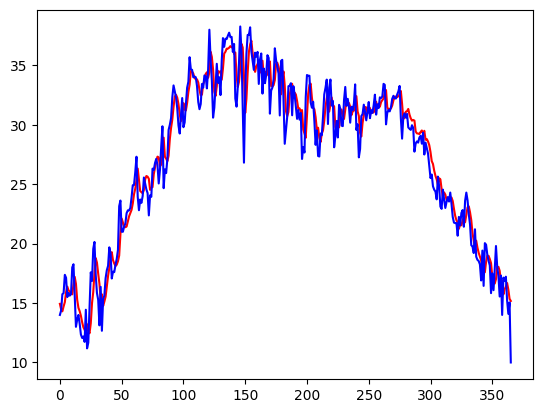

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##better parameters BiLSTM

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss="mse")

also changed batch_size here

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 8)

Epoch 1/50
176/176 [==============================] - 27s 101ms/step - loss: 0.0168
Epoch 2/50
176/176 [==============================] - 18s 102ms/step - loss: 0.0033
Epoch 3/50
176/176 [==============================] - 19s 105ms/step - loss: 0.0031
Epoch 4/50
176/176 [==============================] - 17s 99ms/step - loss: 0.0033
Epoch 5/50
176/176 [==============================] - 19s 107ms/step - loss: 0.0031
Epoch 6/50
176/176 [==============================] - 17s 99ms/step - loss: 0.0028
Epoch 7/50
176/176 [==============================] - 19s 106ms/step - loss: 0.0033
Epoch 8/50
176/176 [==============================] - 18s 101ms/step - loss: 0.0030
Epoch 9/50
176/176 [==============================] - 18s 100ms/step - loss: 0.0030
Epoch 10/50
176/176 [==============================] - 19s 107ms/step - loss: 0.0029
Epoch 11/50
176/176 [==============================] - 18s 100ms/step - loss: 0.0027
Epoch 12/50
176/176 [==============================] - 19s 106ms/step - loss

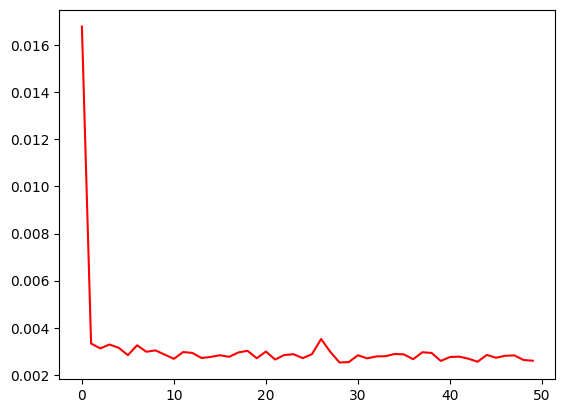

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 32ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 [==============================] - 0s 36ms/step


(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.4837080160517564

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.2466521832110478

In [ ]:
RMSE_scores["BiLSTM_new"] = RMSE
MAE_scores["BiLSTM_new"] = MAE

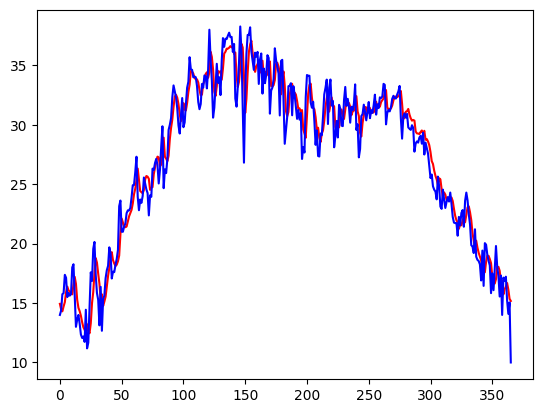

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##stacked LSTM

In [ ]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(x_train.shape[1], 1)))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50, return_sequences=True))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50))  # return a single vector of dimension 50
model.add(Dense(10))
model.add(Dense(1, activation='softmax'))

In [ ]:
#Compile model
model.compile(optimizer='adam',loss="mse")

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32)

Epoch 1/50
44/44 [==============================] - 11s 115ms/step - loss: 0.1987
Epoch 2/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 3/50
44/44 [==============================] - 4s 89ms/step - loss: 0.1987
Epoch 4/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 5/50
44/44 [==============================] - 4s 93ms/step - loss: 0.1987
Epoch 6/50
44/44 [==============================] - 4s 85ms/step - loss: 0.1987
Epoch 7/50
44/44 [==============================] - 8s 175ms/step - loss: 0.1987
Epoch 8/50
44/44 [==============================] - 4s 94ms/step - loss: 0.1987
Epoch 9/50
44/44 [==============================] - 5s 112ms/step - loss: 0.1987
Epoch 10/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 11/50
44/44 [==============================] - 4s 87ms/step - loss: 0.1987
Epoch 12/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 13/50
44/44 [============

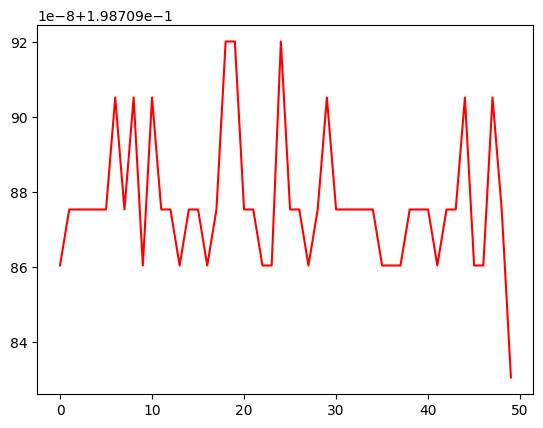

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 26ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 [==============================] - 0s 33ms/step


(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

11.623790591636126

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

11.623790591636126

In [ ]:
# RMSE_scores["stacked_LSTM"] = RMSE
# MAE_scores["stacked_LSTM"] = MAE

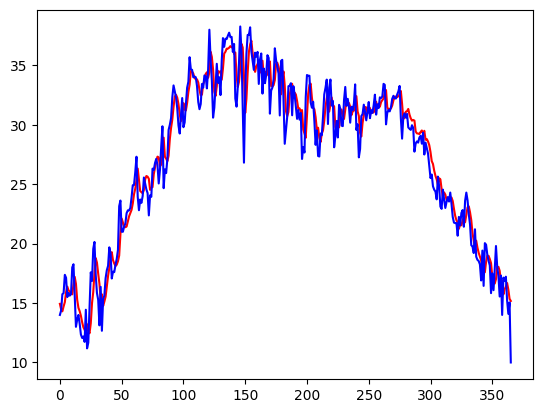

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

#Scores

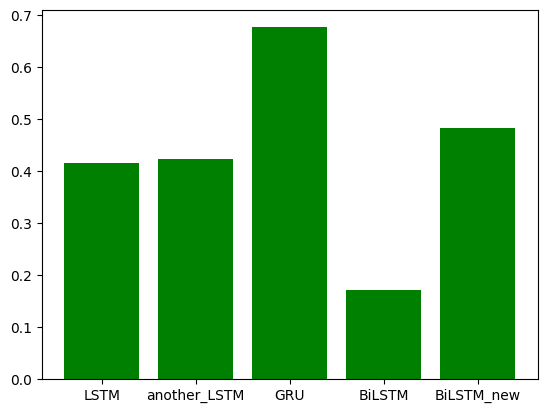

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(RMSE_scores.keys()), RMSE_scores.values(), color='g')
plt.show()

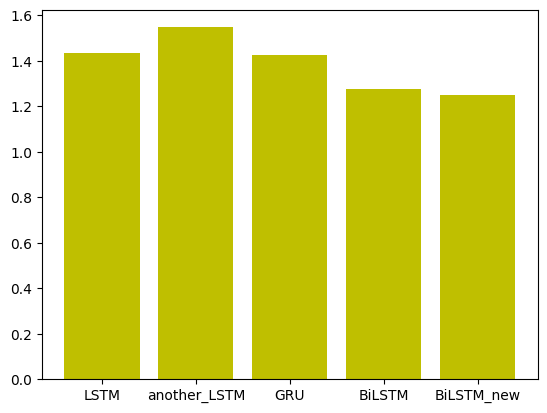

In [ ]:
plt.bar(list(MAE_scores.keys()), MAE_scores.values(), color='y')
plt.show()

#---Brent oil daily price---

#data loading

In [ ]:
df = pd.read_csv('/content/brent_oil_daily.csv')

df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [ ]:
df

Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63
...           ...
2023-05-09  77.76
2023-05-10  76.70
2023-05-11  75.32
2023-05-12  74.54
2023-05-15  75.46

[9132 rows x 1 columns]

train test split

In [ ]:
# df_test = df[round(len(df)*0.67):]

In [ ]:
# len(df_test)

In [ ]:
# df = df[:len(df)-len(df_test)]

In [ ]:
# len(df)

In [ ]:
predicting_col='Price'

#decomposition

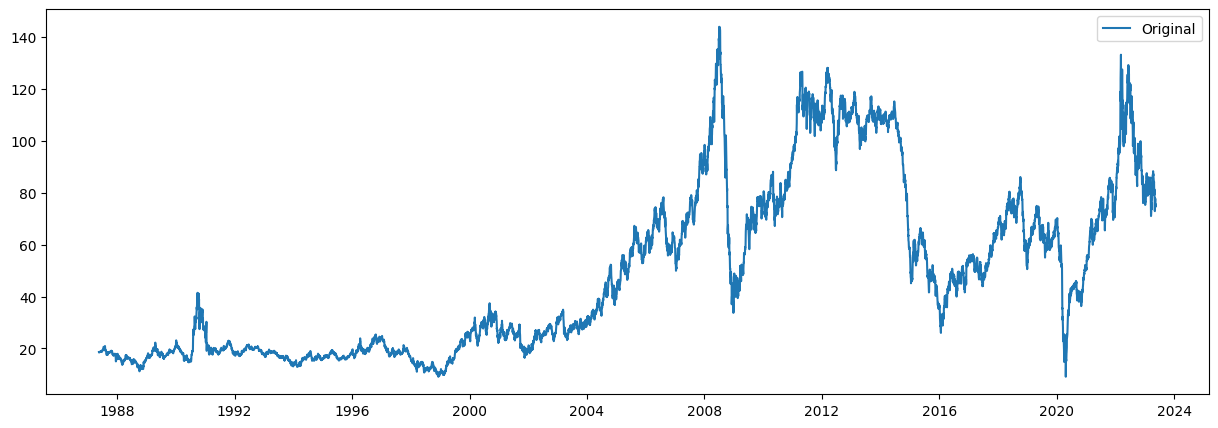

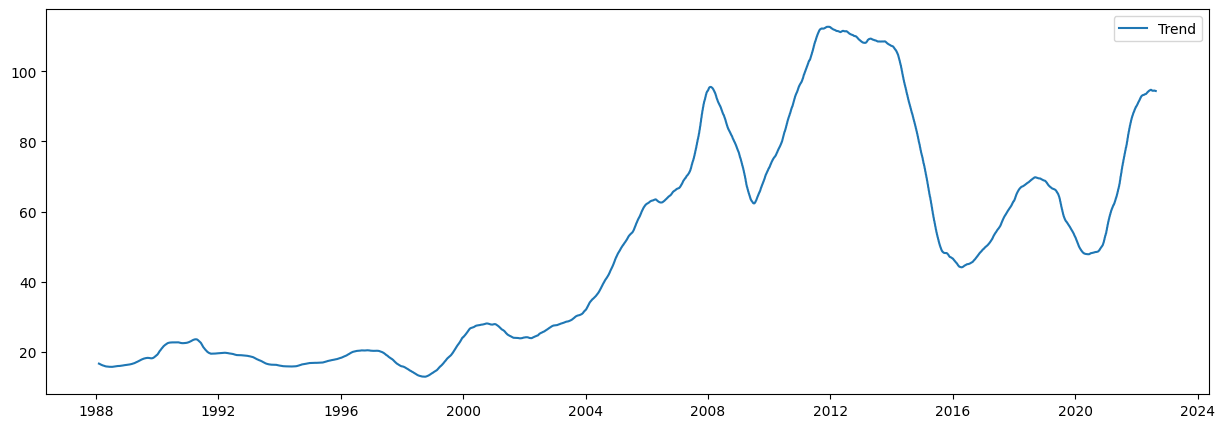

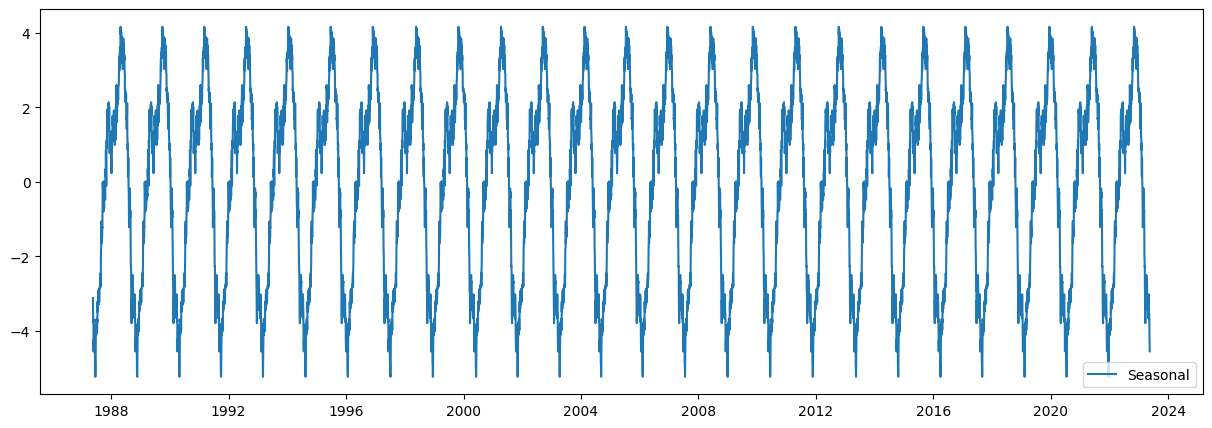

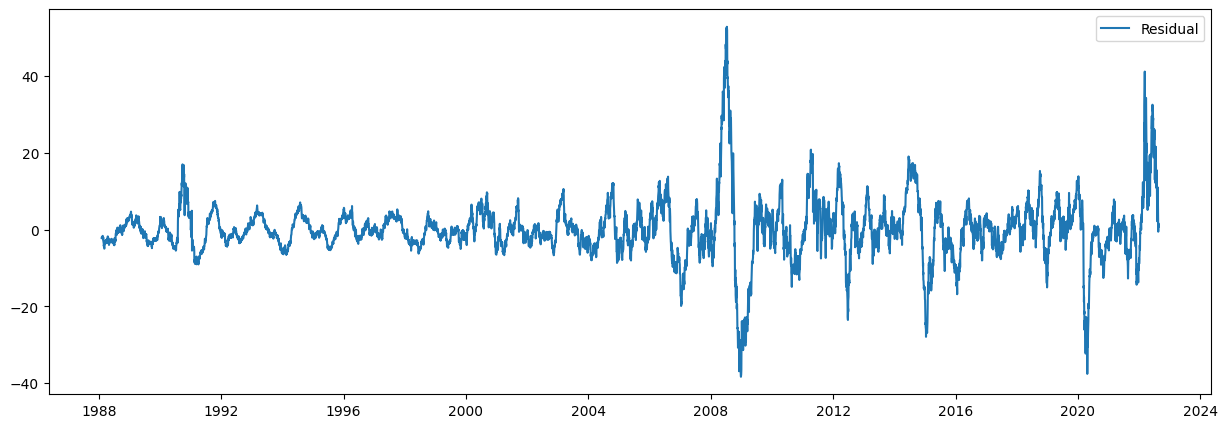

In [ ]:
ts_decomposition = seasonal_decompose(x=df[predicting_col], model='additive', period=365)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

plt.figure(figsize=(15,5))
plt.plot(df[predicting_col], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [ ]:
x_train, y_train, scaler, train_size, test_size, scaled_data = prepare_data(df, predicting_col)

In [ ]:
train_size

6849

In [ ]:
test_size

2283

In [ ]:
scaled_data

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.49106415],
       [0.48527994],
       [0.49210234]])

#Models

In [ ]:
RMSE_scores = {}
MAE_scores = {}

##LSTM

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
284/284 [==============================] - 23s 64ms/step - loss: 0.0024
Epoch 2/30
284/284 [==============================] - 35s 125ms/step - loss: 4.1350e-04
Epoch 3/30
284/284 [==============================] - 20s 70ms/step - loss: 3.2466e-04
Epoch 4/30
284/284 [==============================] - 19s 66ms/step - loss: 2.7912e-04
Epoch 5/30
284/284 [==============================] - 18s 64ms/step - loss: 2.6431e-04
Epoch 6/30
284/284 [==============================] - 19s 65ms/step - loss: 2.1250e-04
Epoch 7/30
284/284 [==============================] - 17s 60ms/step - loss: 1.7970e-04
Epoch 8/30
284/284 [==============================] - 19s 65ms/step - loss: 1.4824e-04
Epoch 9/30
284/284 [==============================] - 17s 59ms/step - loss: 1.5909e-04
Epoch 10/30
284/284 [==============================] - 18s 63ms/step - loss: 1.3139e-04
Epoch 11/30
284/284 [==============================] - 17s 59ms/step - loss: 1.2048e-04
Epoch 12/30
284/284 [=======================

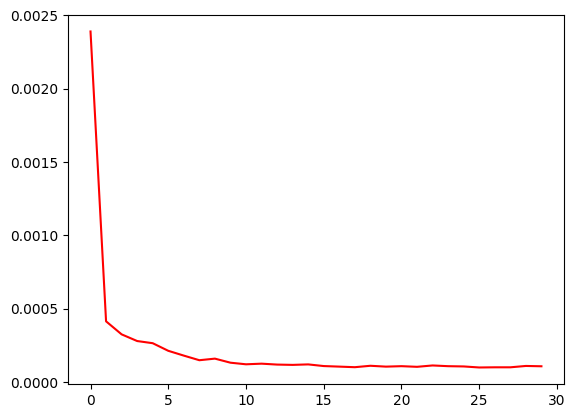

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

72/72 [==============================] - 2s 18ms/step


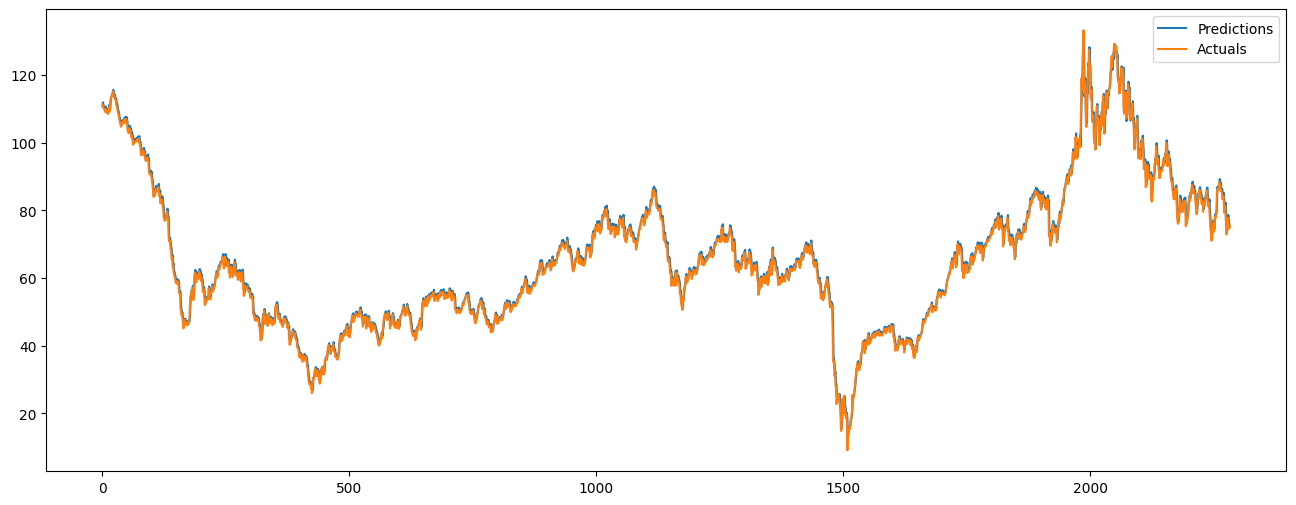

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

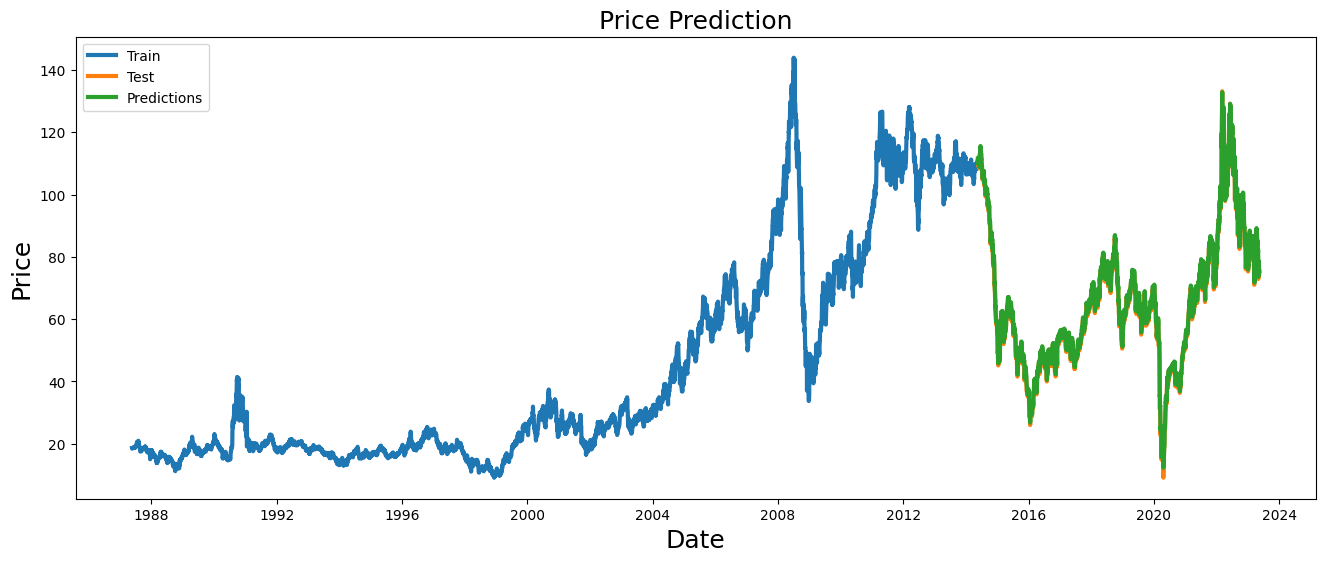

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

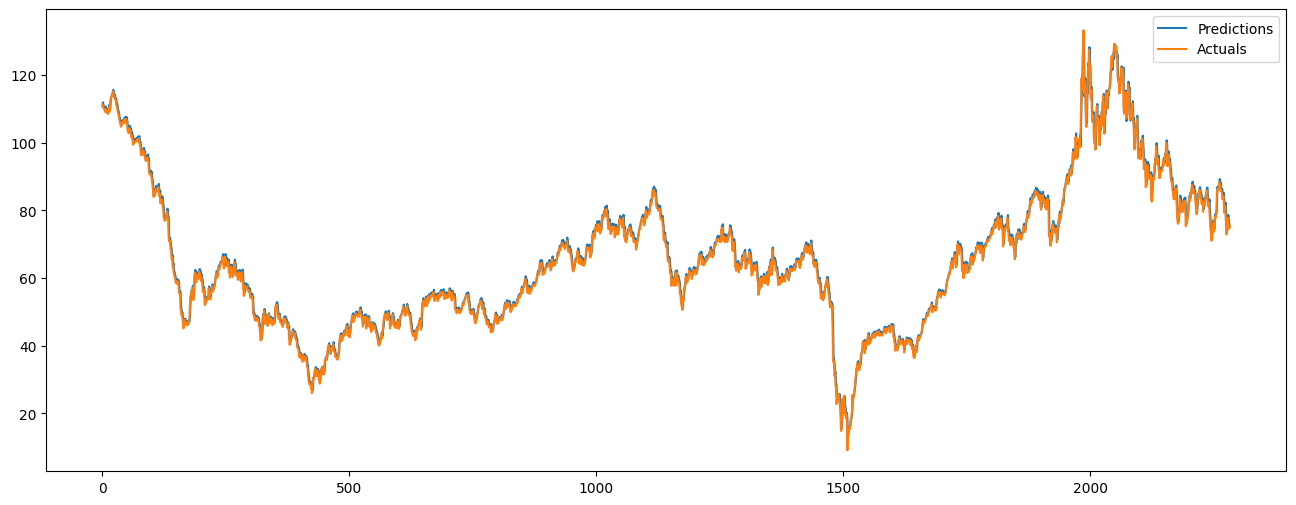

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

72/72 [==============================] - 1s 17ms/step


(2283, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(2283, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(y_test - predictions)**2)
RMSE

0.7073377724546014

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.270454746418442

In [ ]:
RMSE_scores["LSTM"] = RMSE
MAE_scores["LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0      110.749214   111.32
1      111.893959   110.89
2      111.235229   110.19
3      110.592682   110.01
4      110.493080   109.81
...           ...      ...
2278    76.661835    77.76
2279    78.634720    76.70
2280    77.536400    75.32
2281    76.129356    74.54
2282    75.310707    75.46

[2283 rows x 2 columns]

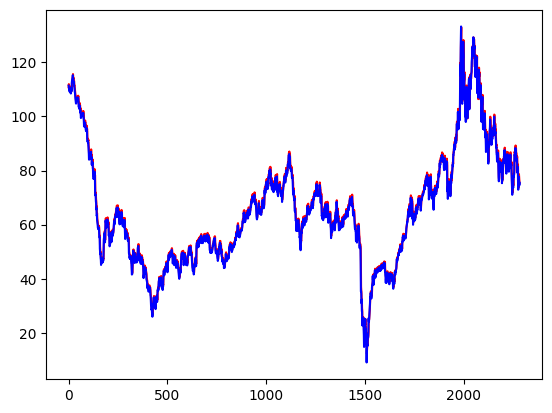

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##another LSTM

In [ ]:
model = Sequential([
    LSTM(units=25, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=25, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
284/284 [==============================] - 21s 58ms/step - loss: 0.0035
Epoch 2/30
284/284 [==============================] - 29s 103ms/step - loss: 5.4104e-04
Epoch 3/30
284/284 [==============================] - 18s 62ms/step - loss: 4.4058e-04
Epoch 4/30
284/284 [==============================] - 23s 83ms/step - loss: 3.9472e-04
Epoch 5/30
284/284 [==============================] - 15s 52ms/step - loss: 3.3253e-04
Epoch 6/30
284/284 [==============================] - 15s 51ms/step - loss: 3.2405e-04
Epoch 7/30
284/284 [==============================] - 15s 51ms/step - loss: 2.7168e-04
Epoch 8/30
284/284 [==============================] - 15s 51ms/step - loss: 2.4542e-04
Epoch 9/30
284/284 [==============================] - 15s 52ms/step - loss: 2.5743e-04
Epoch 10/30
284/284 [==============================] - 15s 54ms/step - loss: 2.1832e-04
Epoch 11/30
284/284 [==============================] - 15s 52ms/step - loss: 1.9424e-04
Epoch 12/30
284/284 [=======================

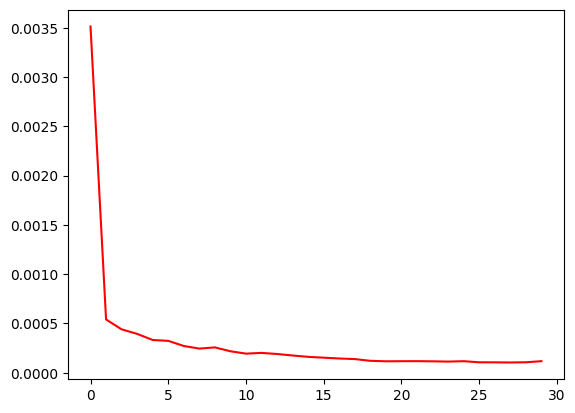

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

72/72 [==============================] - 2s 13ms/step


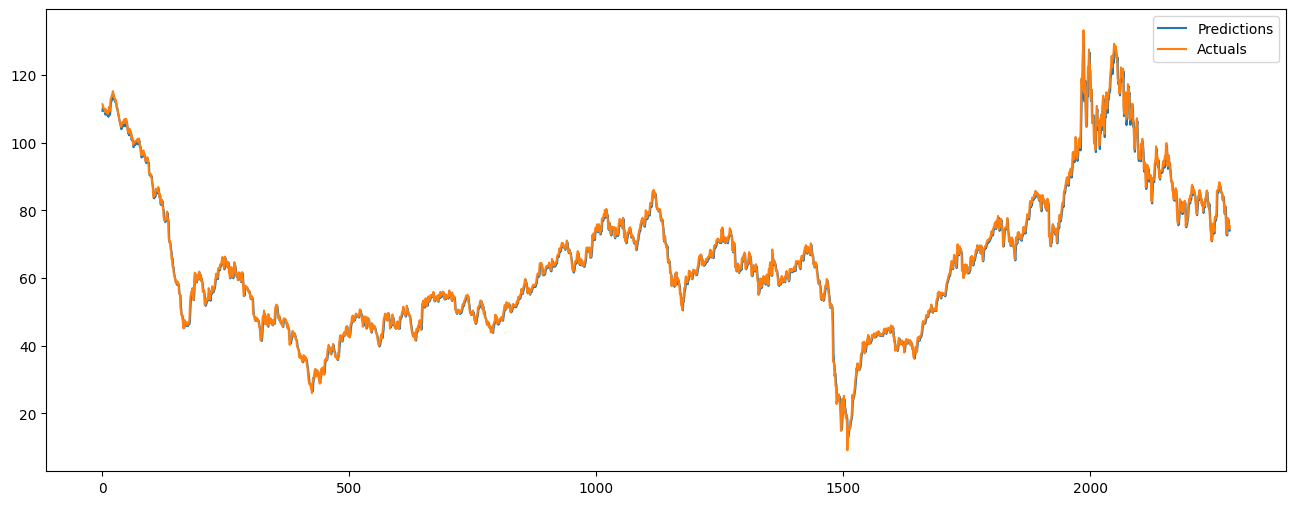

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

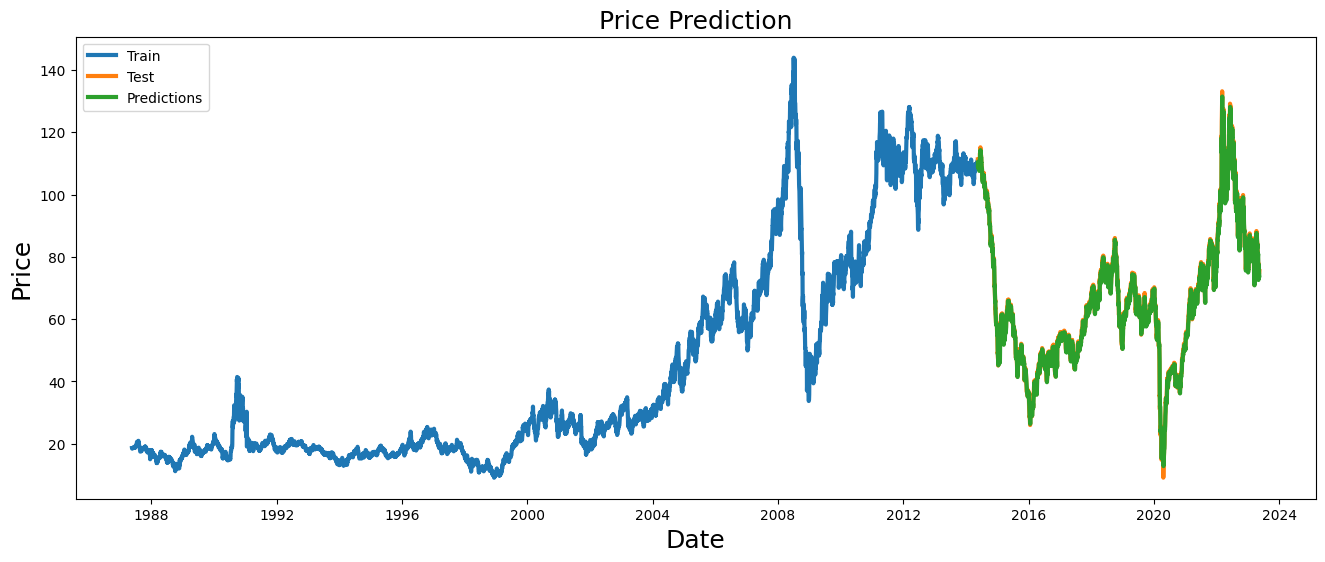

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

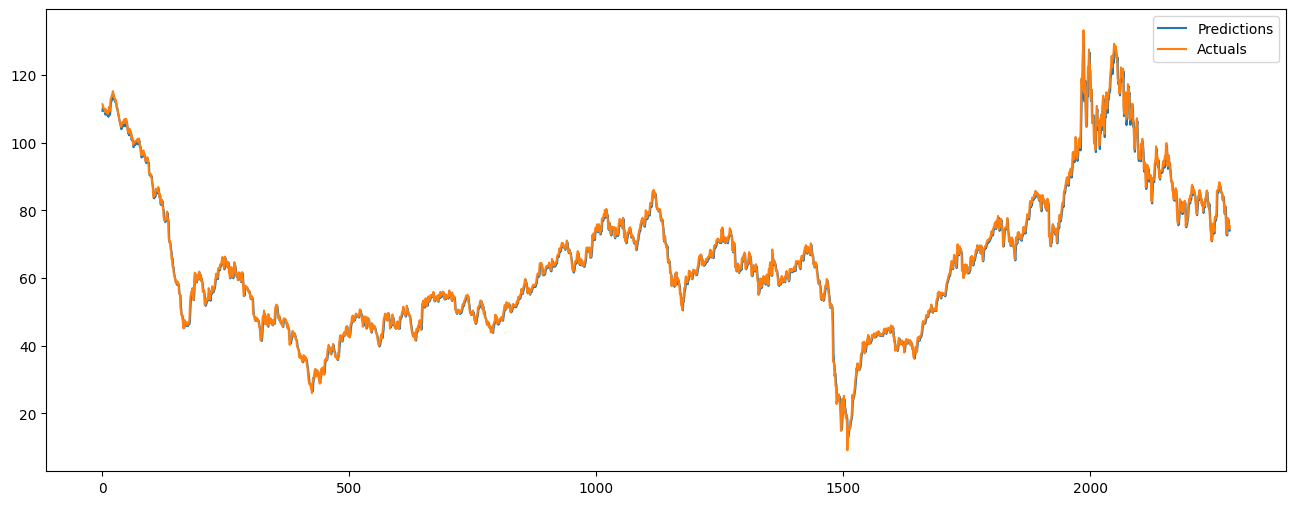

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

72/72 [==============================] - 1s 14ms/step


(2283, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(2283, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.3868903279147856

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.2013823991859895

In [ ]:
RMSE_scores["another_LSTM"] = RMSE
MAE_scores["another_LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0      109.405113   111.32
1      110.551712   110.89
2      109.950272   110.19
3      109.294891   110.01
4      109.212738   109.81
...           ...      ...
2278    75.354355    77.76
2279    77.409874    76.70
2280    76.442192    75.32
2281    74.923973    74.54
2282    74.025215    75.46

[2283 rows x 2 columns]

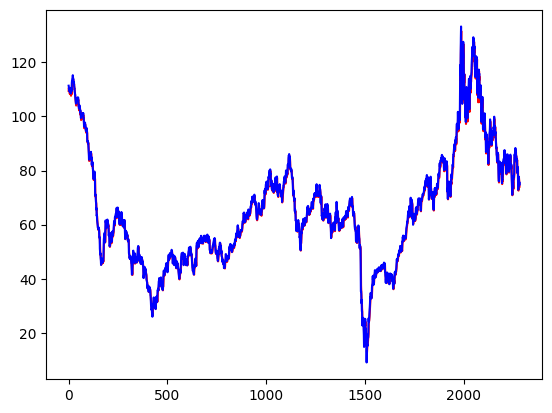

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##GRU

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()

    # Input layer
    model.add(layers.GRU(units = units, return_sequences = True,
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(layers.Dropout(0.2))

    # Hidden layer
    model.add(layers.GRU(units = units))
    model.add(layers.Dropout(0.2))
    model.add(Dense(units = 1))

    #Compile model
    #model.compile(optimizer='adam',loss='mse')
    return model
model = create_gru(64)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
284/284 [==============================] - 36s 108ms/step - loss: 0.0037
Epoch 2/30
284/284 [==============================] - 29s 101ms/step - loss: 0.0011
Epoch 3/30
284/284 [==============================] - 21s 74ms/step - loss: 9.3035e-04
Epoch 4/30
284/284 [==============================] - 20s 69ms/step - loss: 8.4704e-04
Epoch 5/30
284/284 [==============================] - 21s 73ms/step - loss: 7.4952e-04
Epoch 6/30
284/284 [==============================] - 22s 77ms/step - loss: 7.2862e-04
Epoch 7/30
284/284 [==============================] - 20s 69ms/step - loss: 6.6220e-04
Epoch 8/30
284/284 [==============================] - 21s 73ms/step - loss: 6.2041e-04
Epoch 9/30
284/284 [==============================] - 20s 69ms/step - loss: 6.1401e-04
Epoch 10/30
284/284 [==============================] - 21s 73ms/step - loss: 5.7080e-04
Epoch 11/30
284/284 [==============================] - 22s 76ms/step - loss: 5.6947e-04
Epoch 12/30
284/284 [==========================

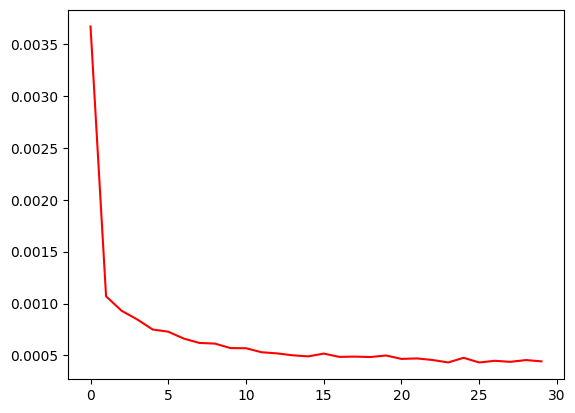

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

72/72 [==============================] - 2s 16ms/step


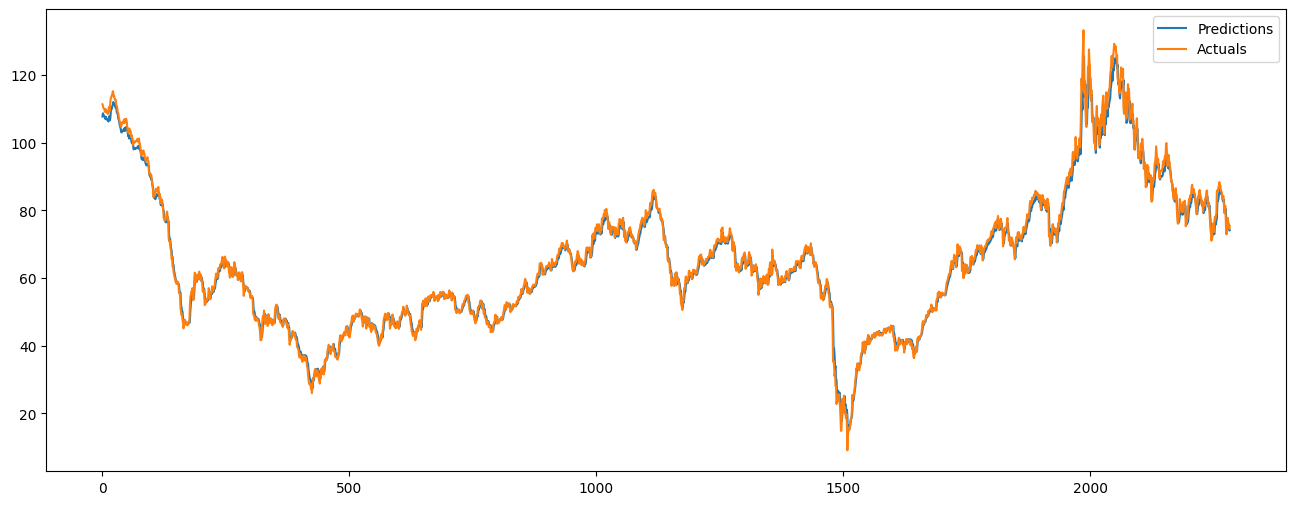

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

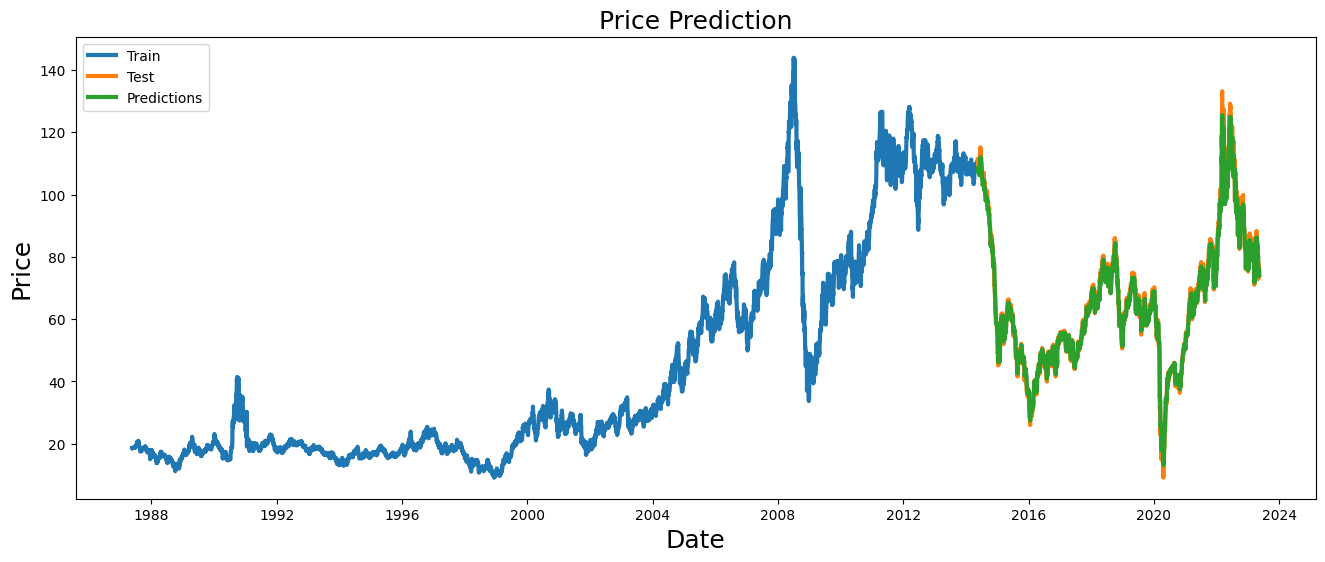

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

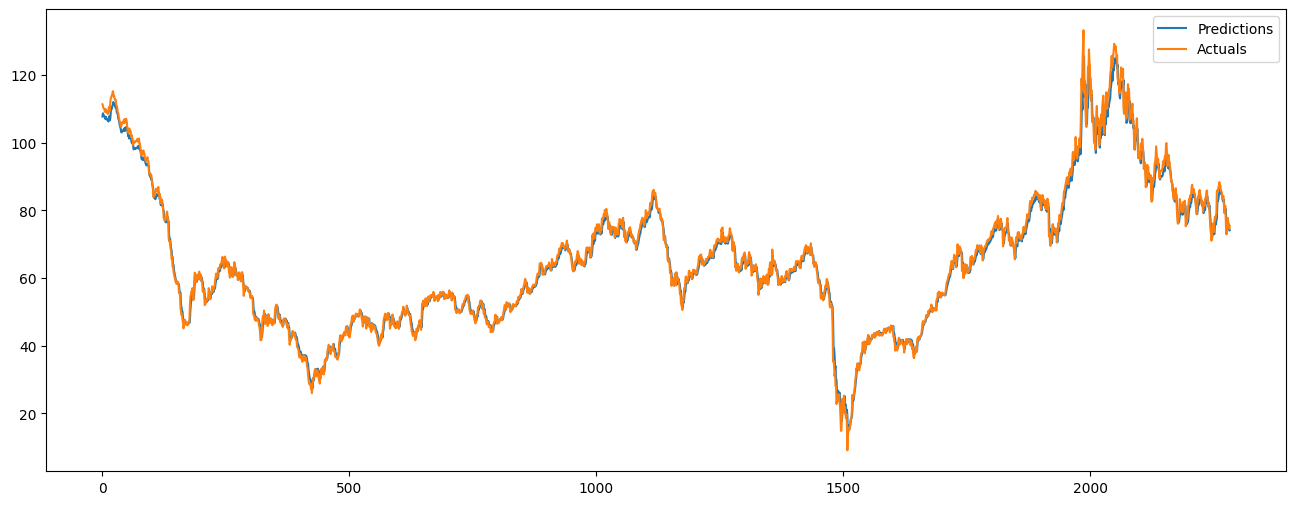

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

72/72 [==============================] - 2s 21ms/step


(2283, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(2283, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

0.5301496111401538

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.4046107692944079

In [ ]:
RMSE_scores["GRU"] = RMSE
MAE_scores["GRU"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0      107.714149   111.32
1      108.663177   110.89
2      108.267029   110.19
3      107.756004   110.01
4      107.775841   109.81
...           ...      ...
2278    75.218582    77.76
2279    76.104683    76.70
2280    75.286705    75.32
2281    74.548798    74.54
2282    74.116684    75.46

[2283 rows x 2 columns]

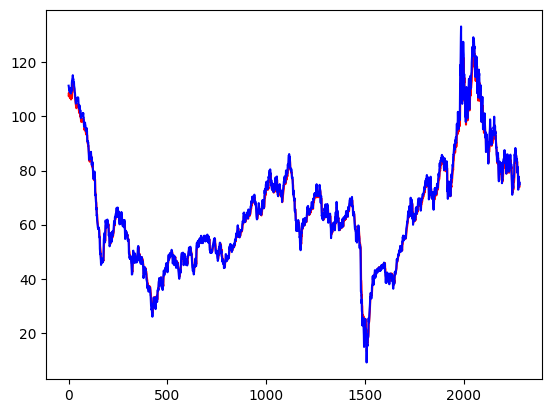

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##BiLSTM

bidirectional LSTM

In [ ]:
# Create BiLSTM model
def create_bilstm(units):
  model = Sequential()

  # Input layer
  model.add(layers.Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))

  # Hidden layer
  model.add(layers.Bidirectional(LSTM(units = units)))
  model.add(Dense(1))

  return model

model = create_bilstm(64)

In [ ]:
#Compile model
model.compile(optimizer="adam",loss="mse")

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 32)

Epoch 1/30
284/284 [==============================] - 66s 203ms/step - loss: 0.0018
Epoch 2/30
284/284 [==============================] - 38s 135ms/step - loss: 2.8041e-04
Epoch 3/30
284/284 [==============================] - 69s 243ms/step - loss: 2.4011e-04
Epoch 4/30
284/284 [==============================] - 39s 136ms/step - loss: 2.1809e-04
Epoch 5/30
284/284 [==============================] - 38s 135ms/step - loss: 2.0944e-04
Epoch 6/30
284/284 [==============================] - 38s 134ms/step - loss: 1.8354e-04
Epoch 7/30
284/284 [==============================] - 38s 134ms/step - loss: 1.6878e-04
Epoch 8/30
284/284 [==============================] - 38s 134ms/step - loss: 1.6121e-04
Epoch 9/30
284/284 [==============================] - 38s 133ms/step - loss: 1.5100e-04
Epoch 10/30
284/284 [==============================] - 38s 133ms/step - loss: 1.5343e-04
Epoch 11/30
284/284 [==============================] - 38s 133ms/step - loss: 1.4012e-04
Epoch 12/30
284/284 [=============

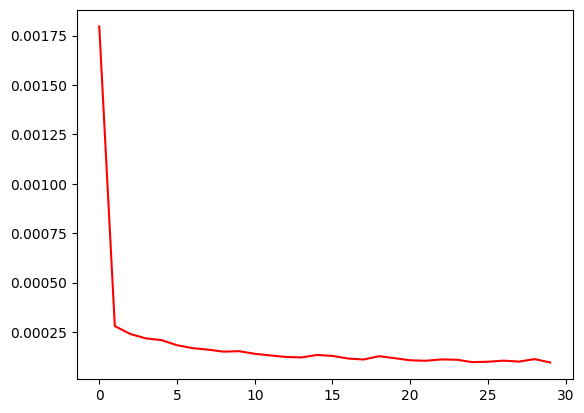

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

72/72 [==============================] - 5s 43ms/step


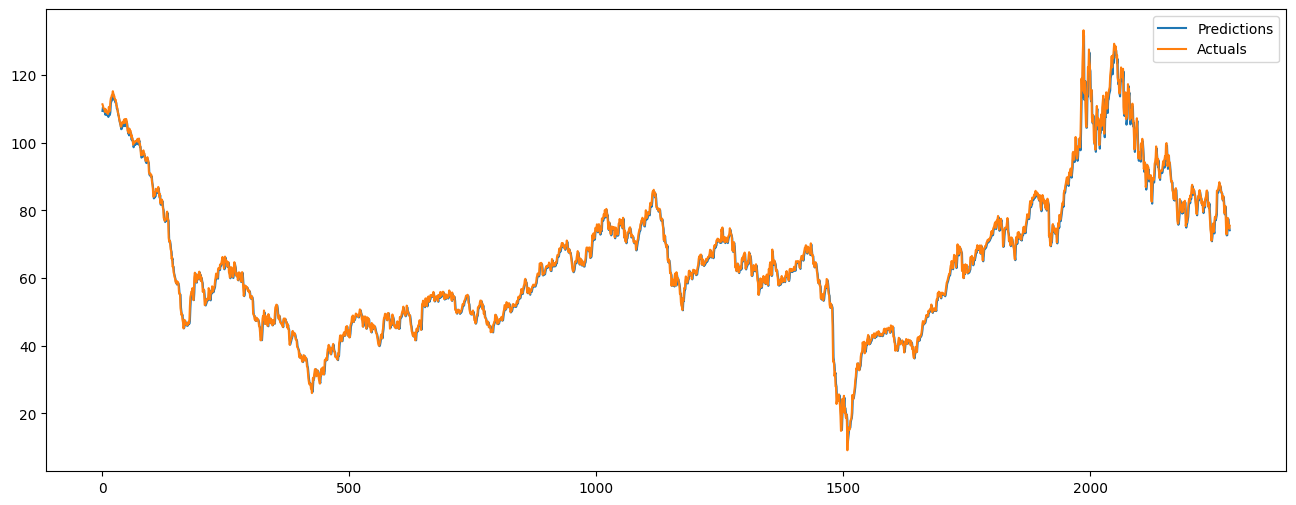

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

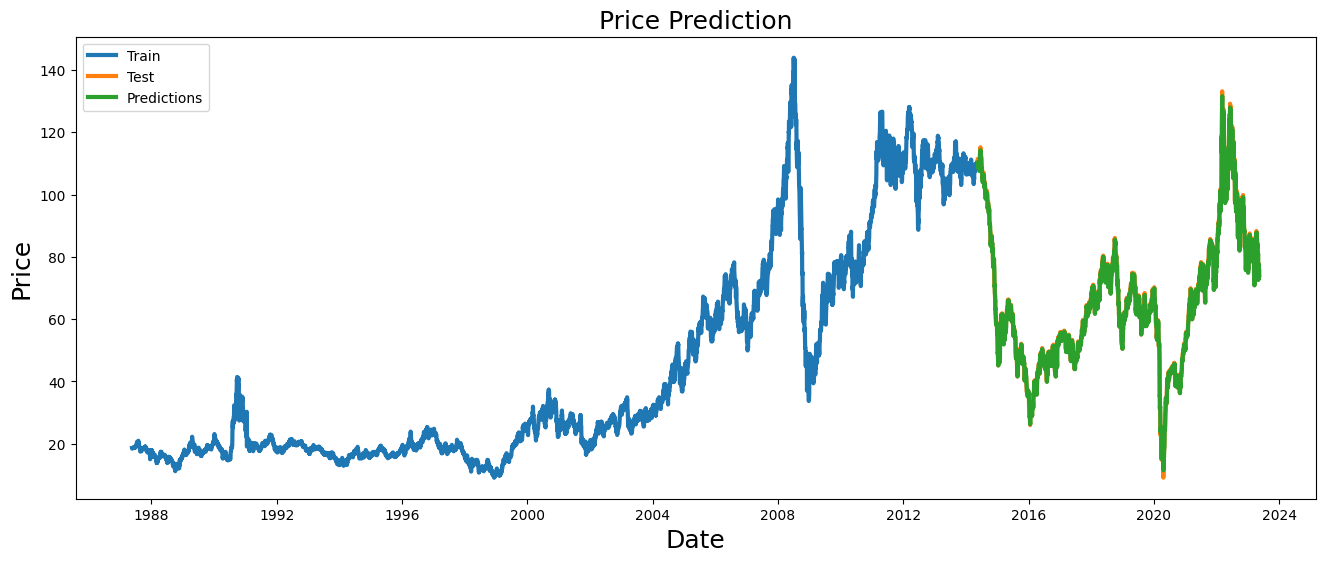

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

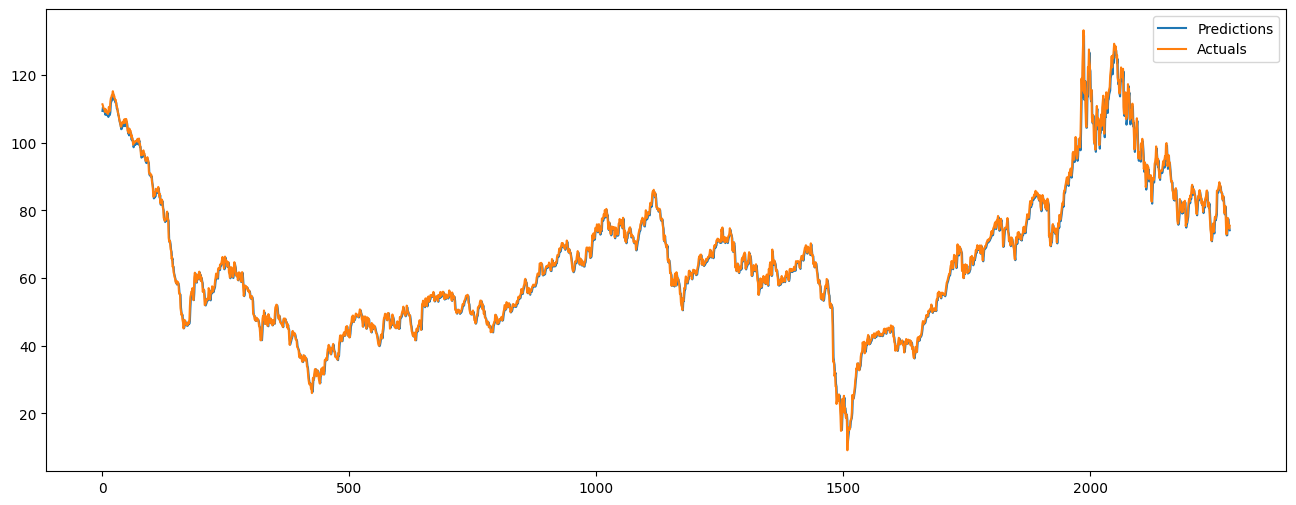

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

72/72 [==============================] - 2s 33ms/step


(2283, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(2283, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.3130759938892126

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.17087439568378

In [ ]:
RMSE_scores["BiLSTM"] = RMSE
MAE_scores["BiLSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0      109.366920   111.32
1      110.498367   110.89
2      109.939316   110.19
3      109.230843   110.01
4      109.137924   109.81
...           ...      ...
2278    75.555618    77.76
2279    77.498184    76.70
2280    76.359695    75.32
2281    74.884605    74.54
2282    74.109543    75.46

[2283 rows x 2 columns]

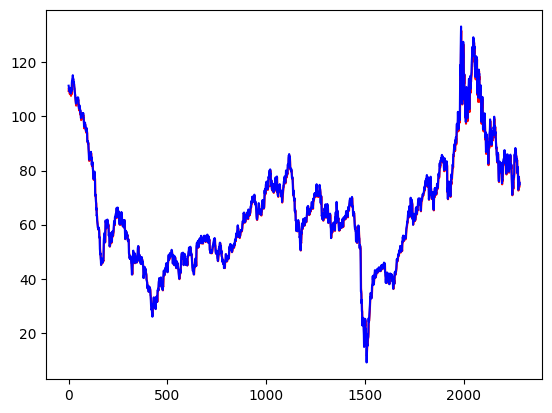

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##better parameters BiLSTM

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss="mse")

also changed batch_size here

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 8)

Epoch 1/50
1134/1134 [==============================] - 100s 83ms/step - loss: 3.6476e-04
Epoch 2/50
1134/1134 [==============================] - 92s 82ms/step - loss: 2.2962e-04
Epoch 3/50
1134/1134 [==============================] - 92s 81ms/step - loss: 2.2924e-04
Epoch 4/50
1134/1134 [==============================] - 92s 81ms/step - loss: 1.8486e-04
Epoch 5/50
1134/1134 [==============================] - 92s 81ms/step - loss: 1.5658e-04
Epoch 6/50
1134/1134 [==============================] - 92s 81ms/step - loss: 2.0085e-04
Epoch 7/50
1134/1134 [==============================] - 93s 82ms/step - loss: 1.8466e-04
Epoch 8/50
1134/1134 [==============================] - 94s 83ms/step - loss: 1.7336e-04
Epoch 9/50
1134/1134 [==============================] - 92s 81ms/step - loss: 1.5725e-04
Epoch 10/50
1134/1134 [==============================] - 92s 81ms/step - loss: 1.8406e-04
Epoch 11/50
1134/1134 [==============================] - 92s 81ms/step - loss: 1.7375e-04
Epoch 12/50
1134/1

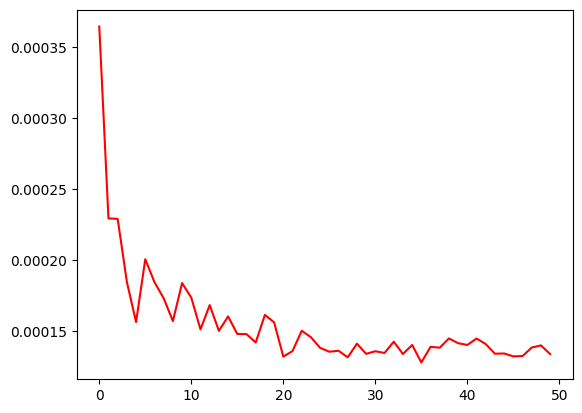

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

72/72 [==============================] - 5s 50ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

72/72 [==============================] - 2s 32ms/step


(2283, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.1923078242906394

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.217127285747219

In [ ]:
RMSE_scores["BiLSTM_new"] = RMSE
MAE_scores["BiLSTM_new"] = MAE

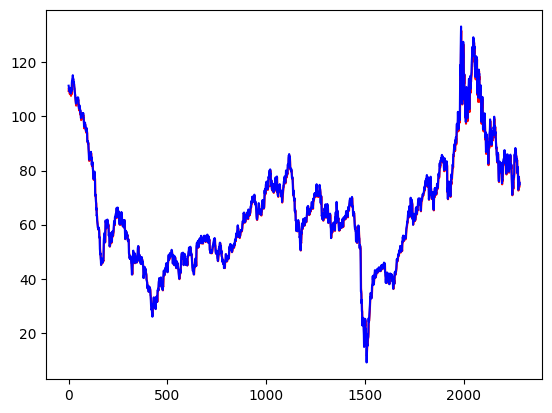

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##stacked LSTM

In [ ]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(x_train.shape[1], 1)))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50, return_sequences=True))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50))  # return a single vector of dimension 50
model.add(Dense(10))
model.add(Dense(1, activation='softmax'))

In [ ]:
#Compile model
model.compile(optimizer='adam',loss="mse")

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32)

Epoch 1/50
44/44 [==============================] - 11s 115ms/step - loss: 0.1987
Epoch 2/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 3/50
44/44 [==============================] - 4s 89ms/step - loss: 0.1987
Epoch 4/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 5/50
44/44 [==============================] - 4s 93ms/step - loss: 0.1987
Epoch 6/50
44/44 [==============================] - 4s 85ms/step - loss: 0.1987
Epoch 7/50
44/44 [==============================] - 8s 175ms/step - loss: 0.1987
Epoch 8/50
44/44 [==============================] - 4s 94ms/step - loss: 0.1987
Epoch 9/50
44/44 [==============================] - 5s 112ms/step - loss: 0.1987
Epoch 10/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 11/50
44/44 [==============================] - 4s 87ms/step - loss: 0.1987
Epoch 12/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 13/50
44/44 [============

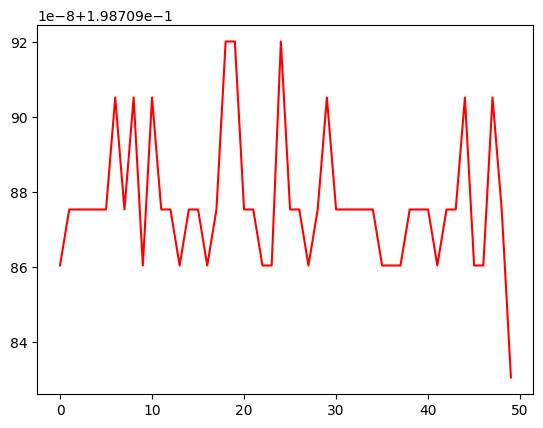

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 26ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 [==============================] - 0s 33ms/step


(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

11.623790591636126

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

11.623790591636126

In [ ]:
# RMSE_scores["stacked_LSTM"] = RMSE
# MAE_scores["stacked_LSTM"] = MAE

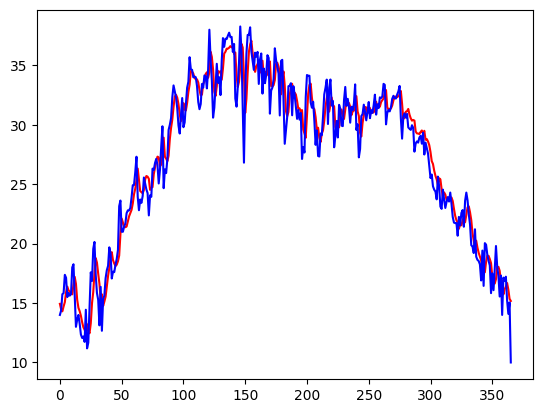

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

#Scores

##overall

In [ ]:
RMSE_scores["ARIMA"] = 2.29323403148108
MAE_scores["ARIMA"] = 1.87540593656118

In [ ]:
RMSE_scores["ETS"] = 6.210656
MAE_scores["ETS"] = 5.670696

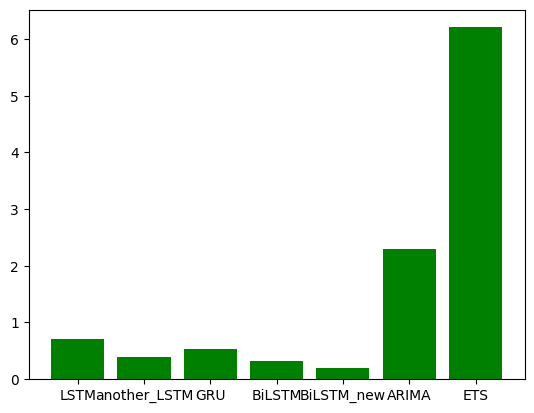

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(RMSE_scores.keys()), RMSE_scores.values(), color='g')
plt.show()

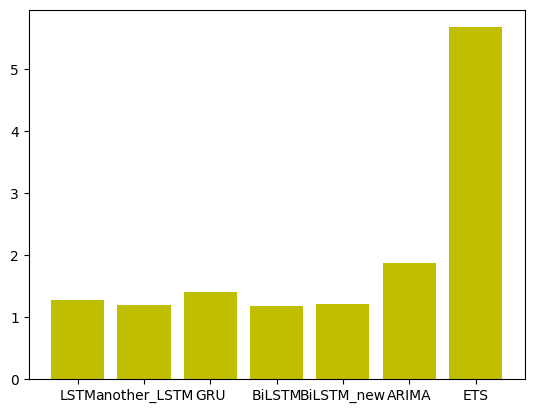

In [ ]:
plt.bar(list(MAE_scores.keys()), MAE_scores.values(), color='y')
plt.show()

In [ ]:
print(RMSE_scores)
print(MAE_scores)

{'LSTM': 0.7073377724546014, 'another_LSTM': 0.3868903279147856, 'GRU': 0.5301496111401538, 'BiLSTM': 0.3130759938892126, 'BiLSTM_new': 0.1923078242906394, 'ARIMA': 2.29323403148108, 'ETS': 6.210656}
{'LSTM': 1.270454746418442, 'another_LSTM': 1.2013823991859895, 'GRU': 1.4046107692944079, 'BiLSTM': 1.17087439568378, 'BiLSTM_new': 1.217127285747219, 'ARIMA': 1.87540593656118, 'ETS': 5.670696}


In [ ]:
RMSE_nn_scores = {'LSTM': 0.7073377724546014, 'another_LSTM': 0.3868903279147856, 'GRU': 0.5301496111401538, 'BiLSTM': 0.3130759938892126, 'BiLSTM_new': 0.1923078242906394}
MAE_nn_scores = {'LSTM': 1.270454746418442, 'another_LSTM': 1.2013823991859895, 'GRU': 1.4046107692944079, 'BiLSTM': 1.17087439568378, 'BiLSTM_new': 1.217127285747219}

##RNNs

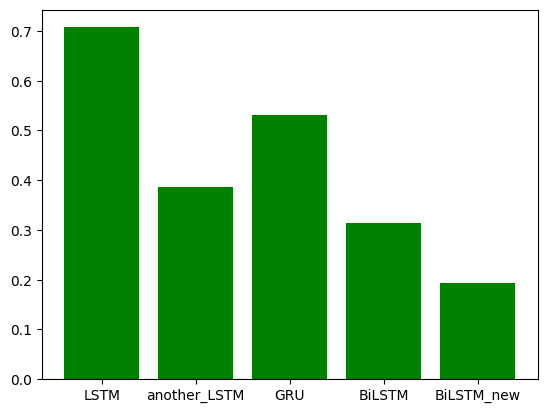

In [ ]:
plt.bar(list(RMSE_nn_scores.keys()), RMSE_nn_scores.values(), color='g')
plt.show()

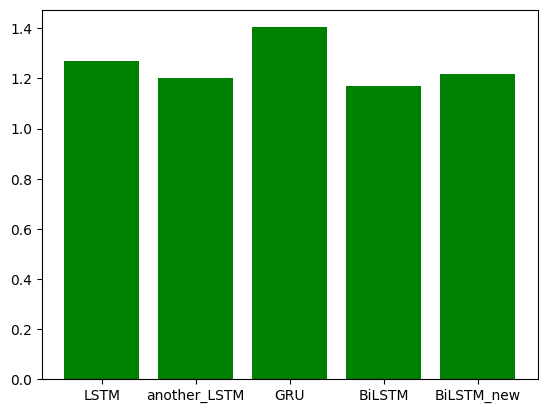

In [ ]:
plt.bar(list(MAE_nn_scores.keys()), MAE_nn_scores.values(), color='g')
plt.show()

#INVFC_M

In [ ]:
df = pd.read_csv('/content/INVFC_M.csv')

df.datum = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

<ipython-input-8-0f088671fad5>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.datum = pd.to_datetime(df.Date)


In [ ]:
df

INVFC_M
Date         
1         3.7
2         4.4
3         4.3
4         6.0
5         7.7
...       ...
260    1209.1
261    1272.7
262    1547.6
263    1446.8
264    2460.3

[264 rows x 1 columns]

In [ ]:
predicting_col='INVFC_M'

#decomposition

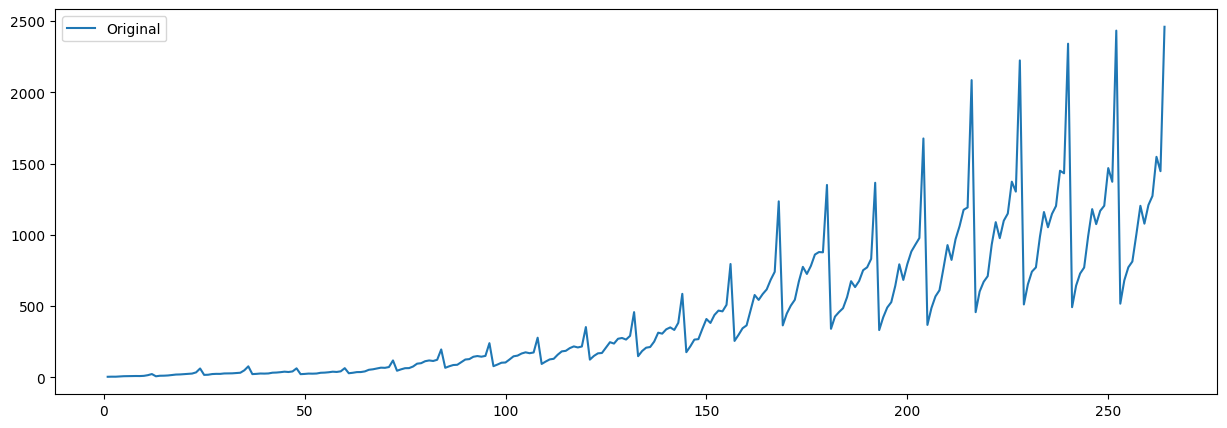

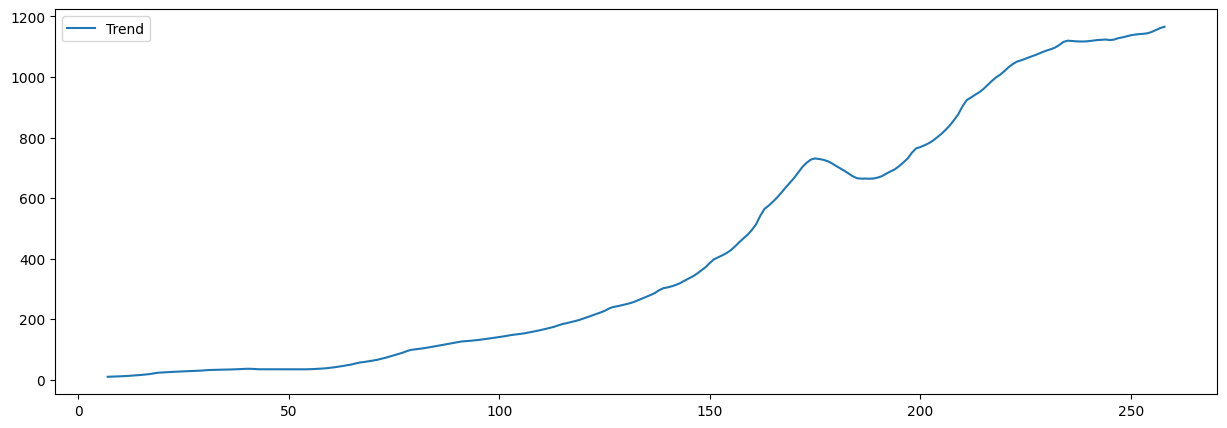

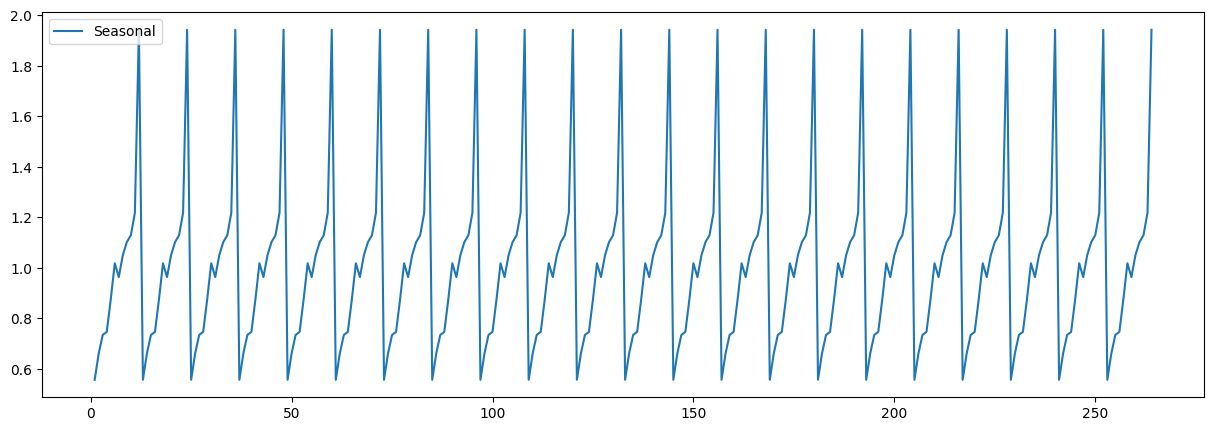

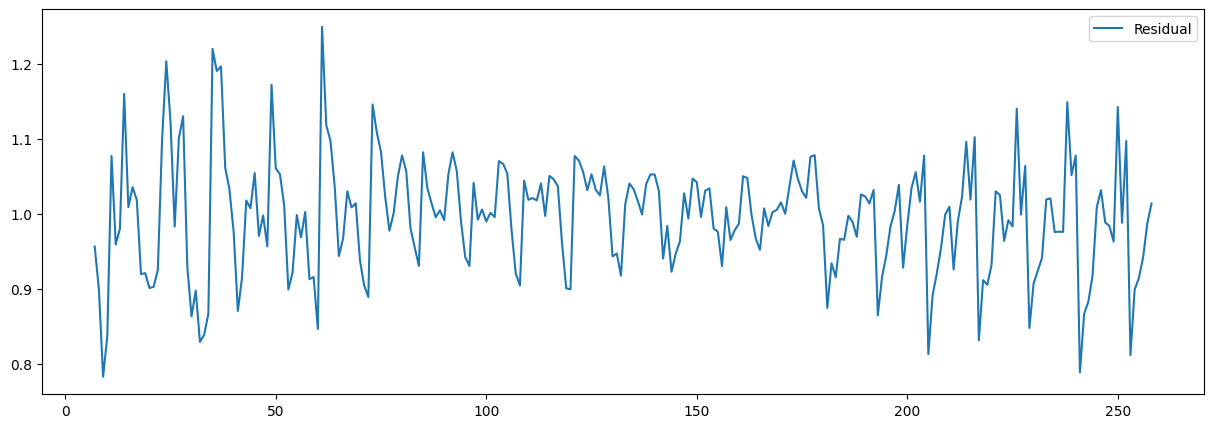

In [ ]:
ts_decomposition = seasonal_decompose(x=df[predicting_col], model='multiplicative', period=12)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

plt.figure(figsize=(15,5))
plt.plot(df[predicting_col], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

train test split

In [ ]:
trend_estimate = trend_estimate.dropna()

In [ ]:
trend_estimate

Date
7         9.220833
8         9.637500
9        10.204167
10       10.787500
11       11.429167
          ...     
254    1144.666667
255    1149.220833
256    1155.379167
257    1161.770833
258    1165.991667
Name: trend, Length: 252, dtype: float64

In [ ]:
trend = pd.DataFrame({"INVFC_M" : trend_estimate})

In [ ]:
trend

INVFC_M
Date             
7        9.220833
8        9.637500
9       10.204167
10      10.787500
11      11.429167
...           ...
254   1144.666667
255   1149.220833
256   1155.379167
257   1161.770833
258   1165.991667

[252 rows x 1 columns]

In [ ]:
x_train, y_train, scaler, train_size, test_size, scaled_data = prepare_data(trend, predicting_col)

In [ ]:
train_size

189

In [ ]:
test_size

63

In [ ]:
scaled_data

#Models

In [ ]:
RMSE_scores = {}
MAE_scores = {}

##LSTM

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
24/24 [==============================] - 8s 59ms/step - loss: 0.0391
Epoch 2/30
24/24 [==============================] - 1s 38ms/step - loss: 0.0047
Epoch 3/30
24/24 [==============================] - 1s 37ms/step - loss: 0.0013
Epoch 4/30
24/24 [==============================] - 1s 37ms/step - loss: 0.0011
Epoch 5/30
24/24 [==============================] - 1s 36ms/step - loss: 9.7490e-04
Epoch 6/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 7/30
24/24 [==============================] - 1s 36ms/step - loss: 8.9080e-04
Epoch 8/30
24/24 [==============================] - 1s 36ms/step - loss: 8.7375e-04
Epoch 9/30
24/24 [==============================] - 1s 36ms/step - loss: 9.0774e-04
Epoch 10/30
24/24 [==============================] - 1s 36ms/step - loss: 9.3789e-04
Epoch 11/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 12/30
24/24 [==============================] - 1s 35ms/step - loss: 7.7021e-04
Epoch 13/30
2

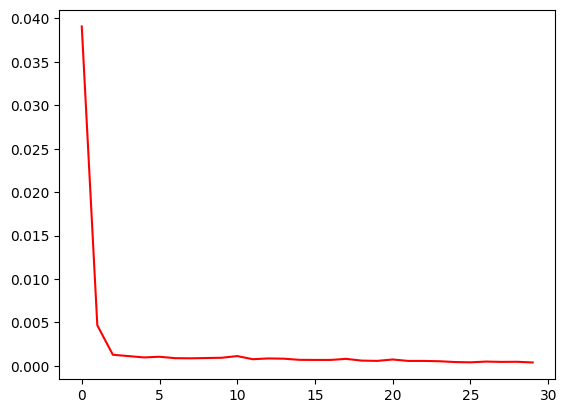

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 24ms/step


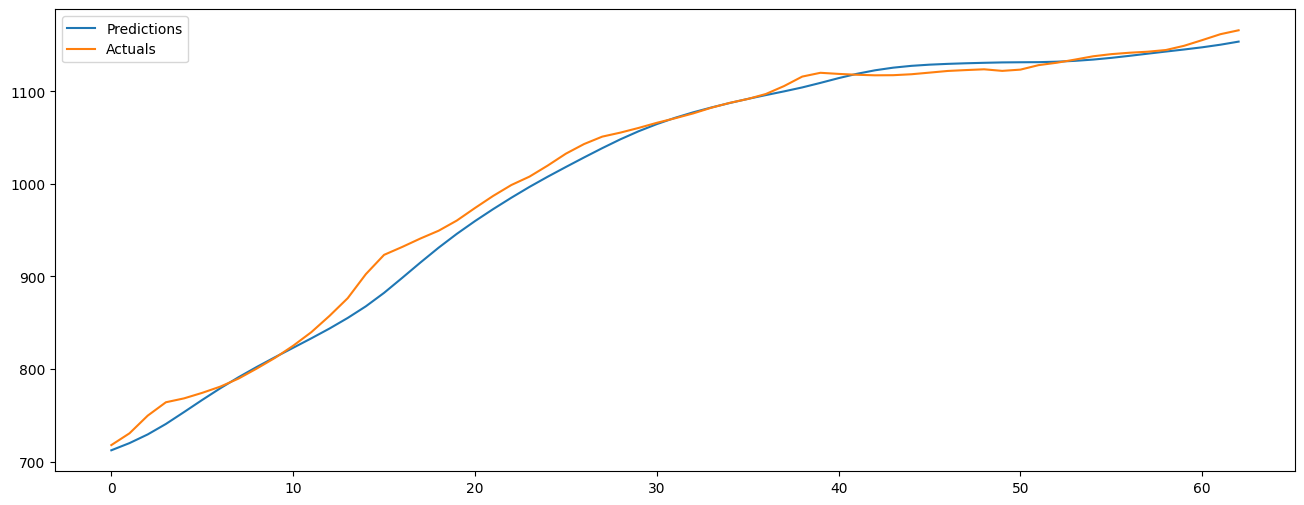

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

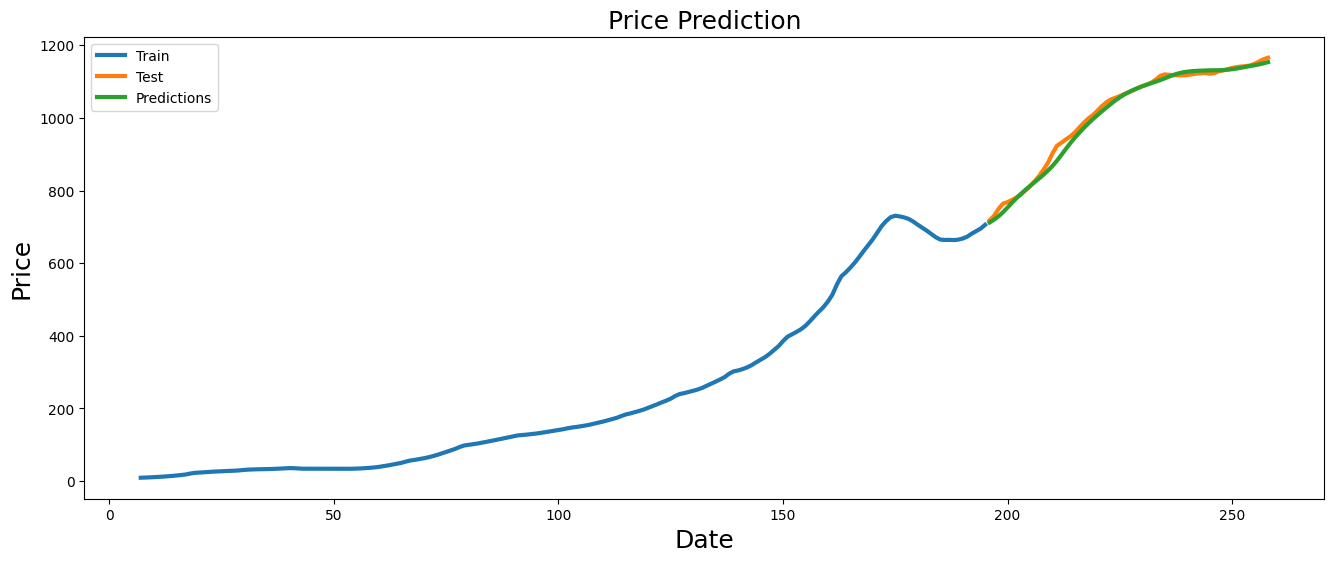

In [ ]:
dataset = trend[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

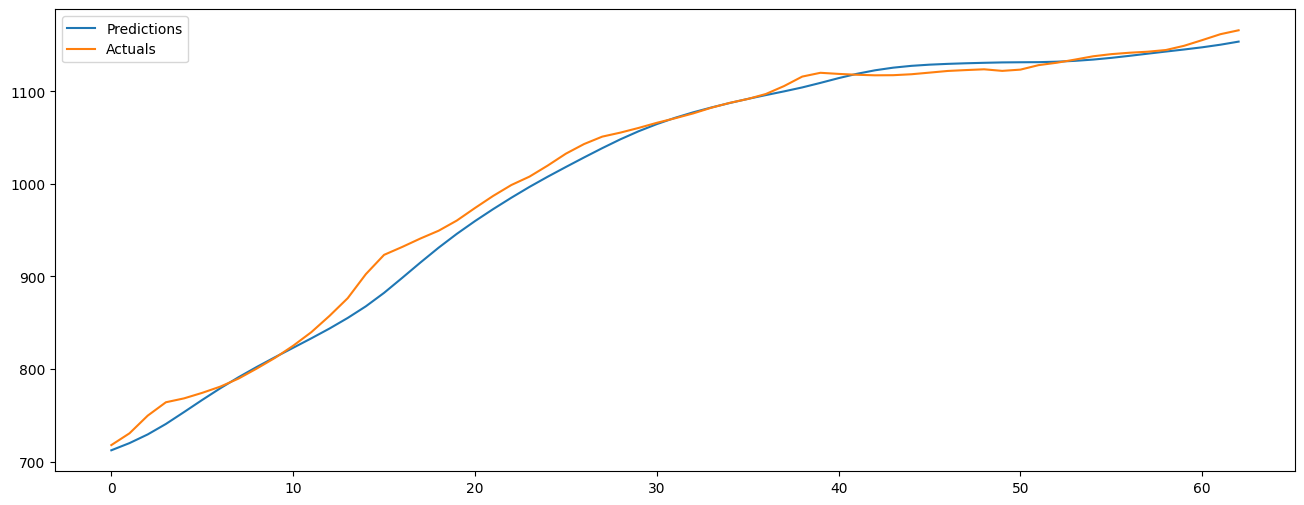

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

2/2 [==============================] - 0s 21ms/step


(63, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(y_test - predictions)**2)
RMSE

6.646479143415132

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

9.236336069258401

In [ ]:
RMSE_scores["LSTM"] = RMSE
MAE_scores["LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions      Actuals
0    712.254333   717.870833
1    720.017883   730.608333
2    729.373596   749.662500
3    740.679932   764.120833
4    753.545837   768.337500
..          ...          ...
58  1143.007935  1144.666667
59  1145.230591  1149.220833
60  1147.611328  1155.379167
61  1150.405518  1161.770833
62  1153.747681  1165.991667

[63 rows x 2 columns]

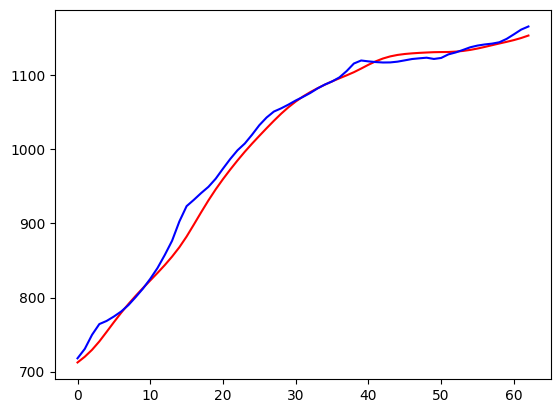

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
24/24 [==============================] - 8s 59ms/step - loss: 0.0391
Epoch 2/30
24/24 [==============================] - 1s 38ms/step - loss: 0.0047
Epoch 3/30
24/24 [==============================] - 1s 37ms/step - loss: 0.0013
Epoch 4/30
24/24 [==============================] - 1s 37ms/step - loss: 0.0011
Epoch 5/30
24/24 [==============================] - 1s 36ms/step - loss: 9.7490e-04
Epoch 6/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 7/30
24/24 [==============================] - 1s 36ms/step - loss: 8.9080e-04
Epoch 8/30
24/24 [==============================] - 1s 36ms/step - loss: 8.7375e-04
Epoch 9/30
24/24 [==============================] - 1s 36ms/step - loss: 9.0774e-04
Epoch 10/30
24/24 [==============================] - 1s 36ms/step - loss: 9.3789e-04
Epoch 11/30
24/24 [==============================] - 1s 36ms/step - loss: 0.0011
Epoch 12/30
24/24 [==============================] - 1s 35ms/step - loss: 7.7021e-04
Epoch 13/30
2

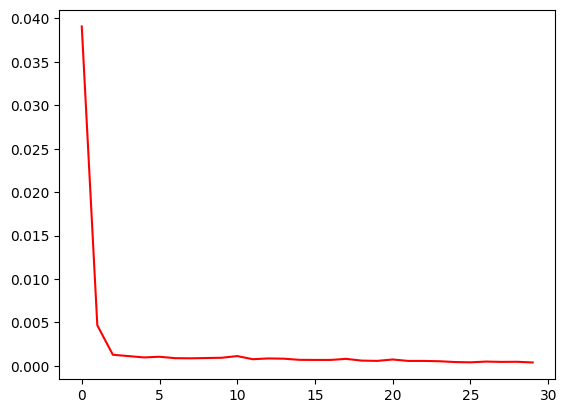

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 24ms/step


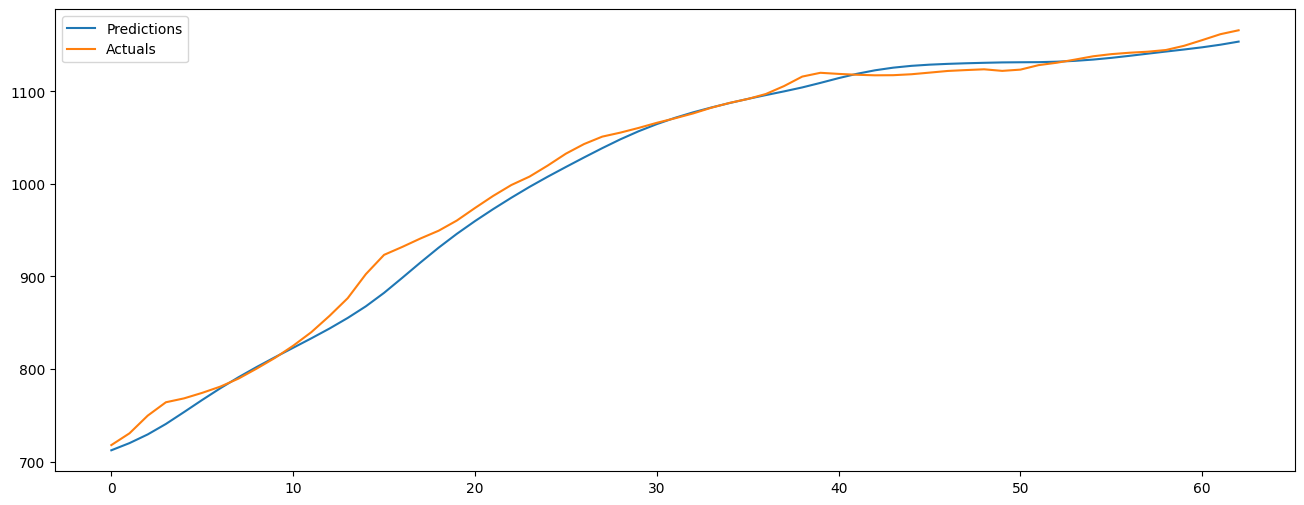

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

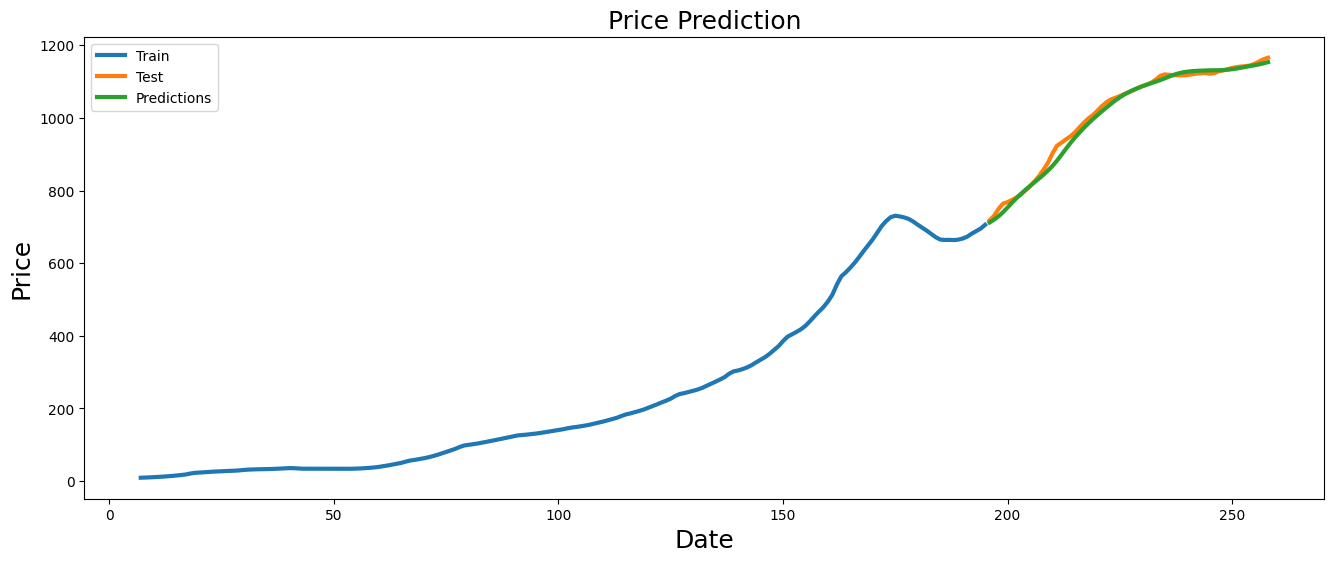

In [ ]:
dataset = trend[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

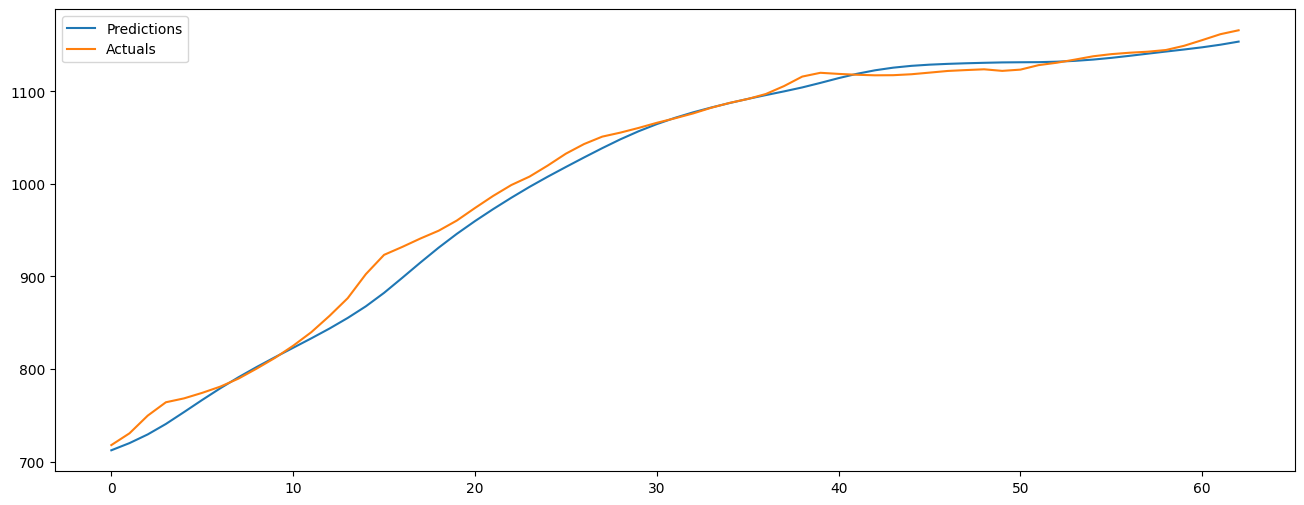

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

2/2 [==============================] - 0s 21ms/step


(63, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(y_test - predictions)**2)
RMSE

6.646479143415132

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

9.236336069258401

In [ ]:
RMSE_scores["LSTM"] = RMSE
MAE_scores["LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions      Actuals
0    712.254333   717.870833
1    720.017883   730.608333
2    729.373596   749.662500
3    740.679932   764.120833
4    753.545837   768.337500
..          ...          ...
58  1143.007935  1144.666667
59  1145.230591  1149.220833
60  1147.611328  1155.379167
61  1150.405518  1161.770833
62  1153.747681  1165.991667

[63 rows x 2 columns]

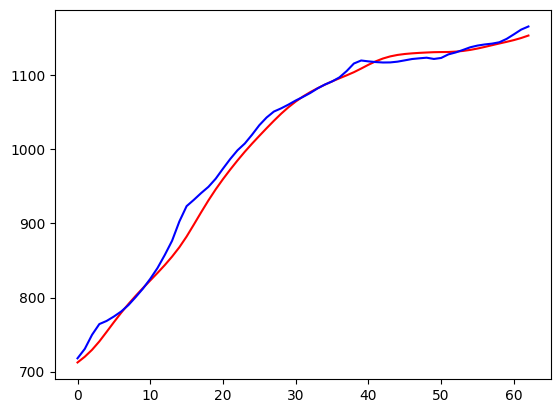

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##another LSTM

In [ ]:
model = Sequential([
    LSTM(units=24, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=24, return_sequences=False),
    Dense(units=24),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
24/24 [==============================] - 8s 47ms/step - loss: 0.0132
Epoch 2/30
24/24 [==============================] - 1s 49ms/step - loss: 0.0013
Epoch 3/30
24/24 [==============================] - 1s 49ms/step - loss: 0.0013
Epoch 4/30
24/24 [==============================] - 1s 51ms/step - loss: 9.8986e-04
Epoch 5/30
24/24 [==============================] - 1s 49ms/step - loss: 9.4714e-04
Epoch 6/30
24/24 [==============================] - 1s 52ms/step - loss: 0.0010
Epoch 7/30
24/24 [==============================] - 1s 51ms/step - loss: 9.9743e-04
Epoch 8/30
24/24 [==============================] - 1s 51ms/step - loss: 0.0010
Epoch 9/30
24/24 [==============================] - 2s 67ms/step - loss: 8.7850e-04
Epoch 10/30
24/24 [==============================] - 2s 63ms/step - loss: 9.4979e-04
Epoch 11/30
24/24 [==============================] - 1s 55ms/step - loss: 8.1717e-04
Epoch 12/30
24/24 [==============================] - 1s 50ms/step - loss: 8.2833e-04
Epoch 13/

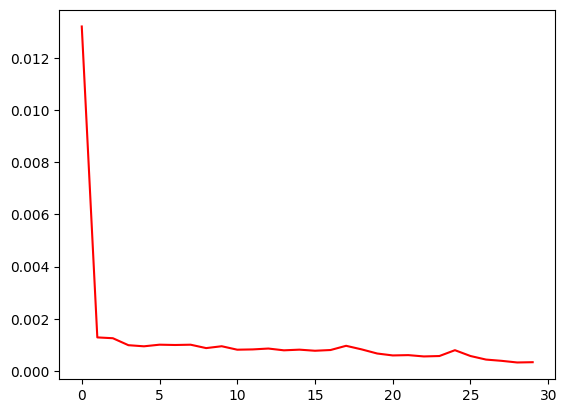

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 21ms/step


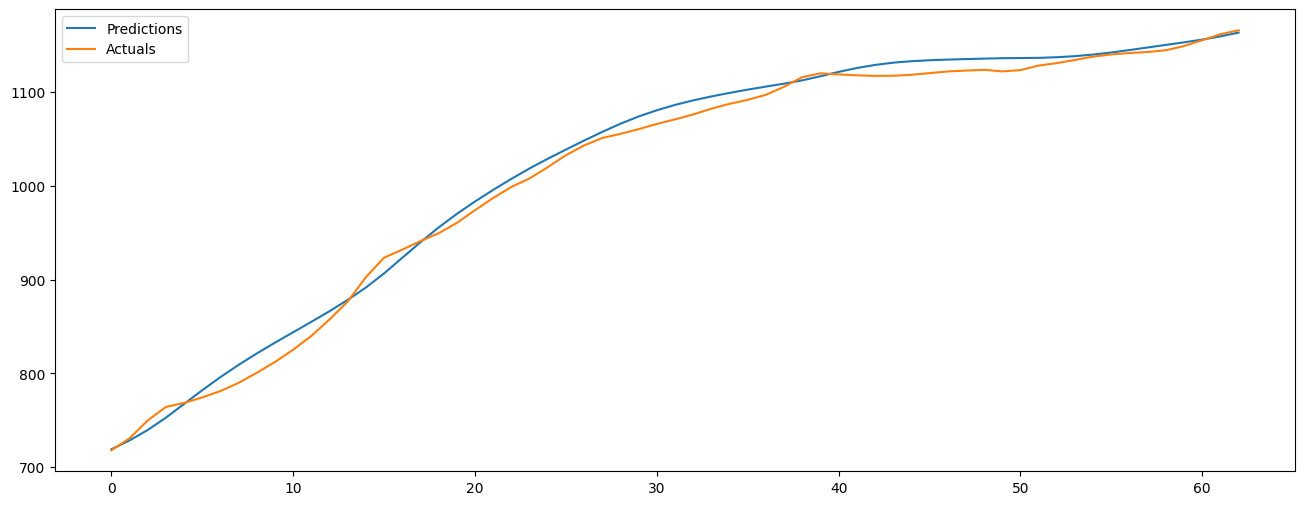

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

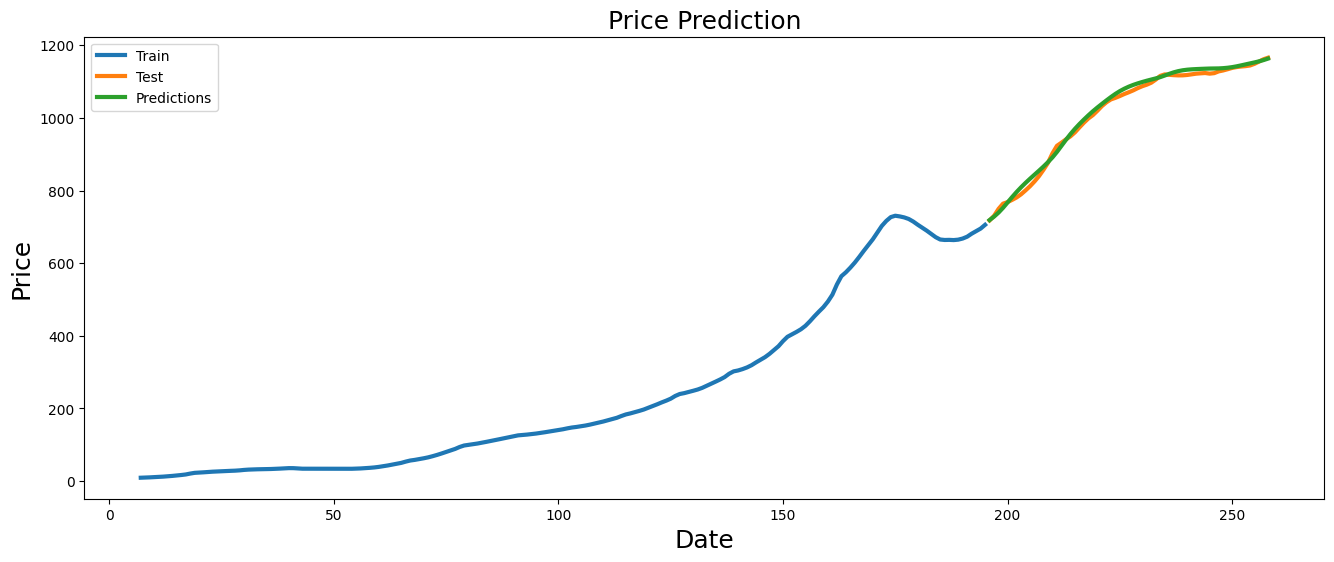

In [ ]:
dataset = trend[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

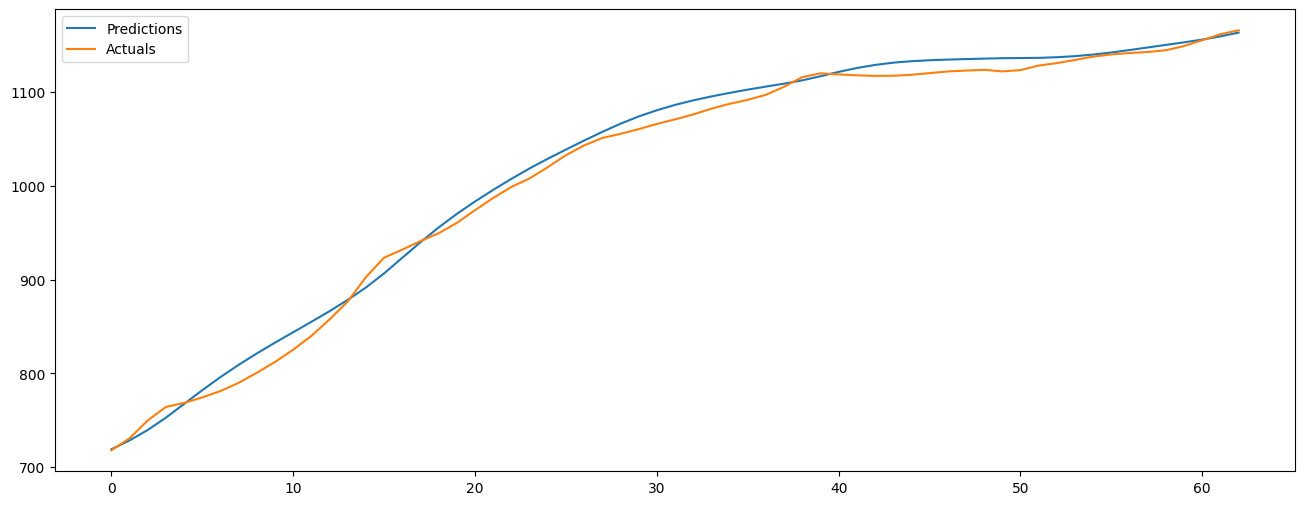

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

2/2 [==============================] - 0s 16ms/step


(63, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

6.675243946862646

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

9.02345099878063

In [ ]:
RMSE_scores["another_LSTM"] = RMSE
MAE_scores["another_LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions      Actuals
0    718.884521   717.870833
1    728.382141   730.608333
2    739.500488   749.662500
3    752.644226   764.120833
4    767.297424   768.337500
..          ...          ...
58  1150.401245  1144.666667
59  1153.112549  1149.220833
60  1156.054077  1155.379167
61  1159.490723  1161.770833
62  1163.535034  1165.991667

[63 rows x 2 columns]

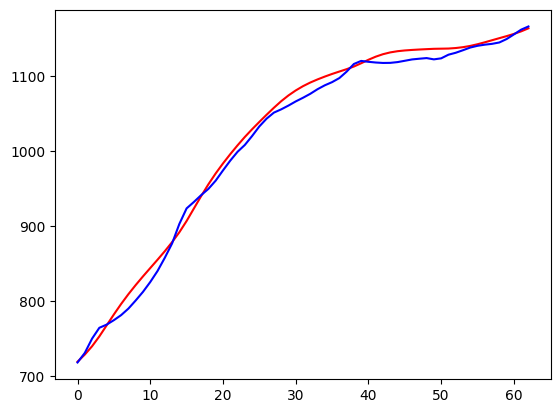

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##GRU

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()

    # Input layer
    model.add(layers.GRU(units = units, return_sequences = True,
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(layers.Dropout(0.2))

    # Hidden layer
    model.add(layers.GRU(units = units))
    model.add(layers.Dropout(0.2))
    model.add(Dense(units = 1))

    #Compile model
    #model.compile(optimizer='adam',loss='mse')
    return model
model = create_gru(64)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
24/24 [==============================] - 10s 83ms/step - loss: 0.0440
Epoch 2/30
24/24 [==============================] - 2s 92ms/step - loss: 0.0052
Epoch 3/30
24/24 [==============================] - 2s 82ms/step - loss: 0.0028
Epoch 4/30
24/24 [==============================] - 3s 126ms/step - loss: 0.0035
Epoch 5/30
24/24 [==============================] - 2s 85ms/step - loss: 0.0042
Epoch 6/30
24/24 [==============================] - 2s 78ms/step - loss: 0.0029
Epoch 7/30
24/24 [==============================] - 2s 79ms/step - loss: 0.0028
Epoch 8/30
24/24 [==============================] - 2s 78ms/step - loss: 0.0026
Epoch 9/30
24/24 [==============================] - 2s 79ms/step - loss: 0.0036
Epoch 10/30
24/24 [==============================] - 2s 105ms/step - loss: 0.0029
Epoch 11/30
24/24 [==============================] - 3s 139ms/step - loss: 0.0030
Epoch 12/30
24/24 [==============================] - 3s 114ms/step - loss: 0.0031
Epoch 13/30
24/24 [=============

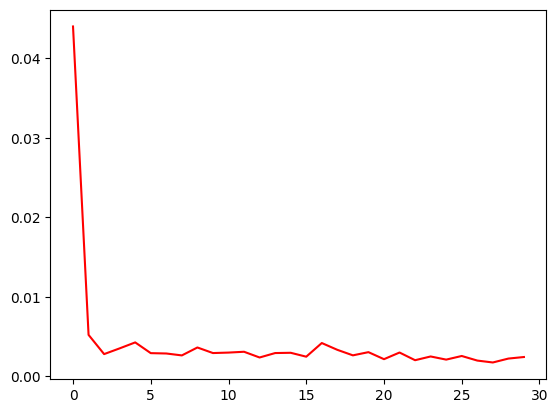

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 47ms/step


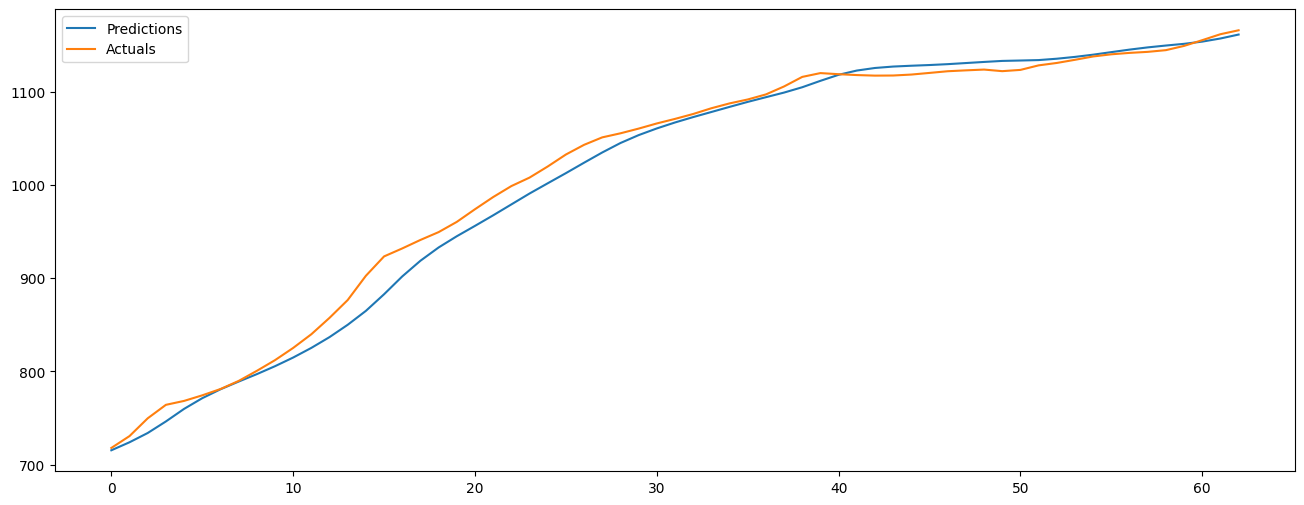

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

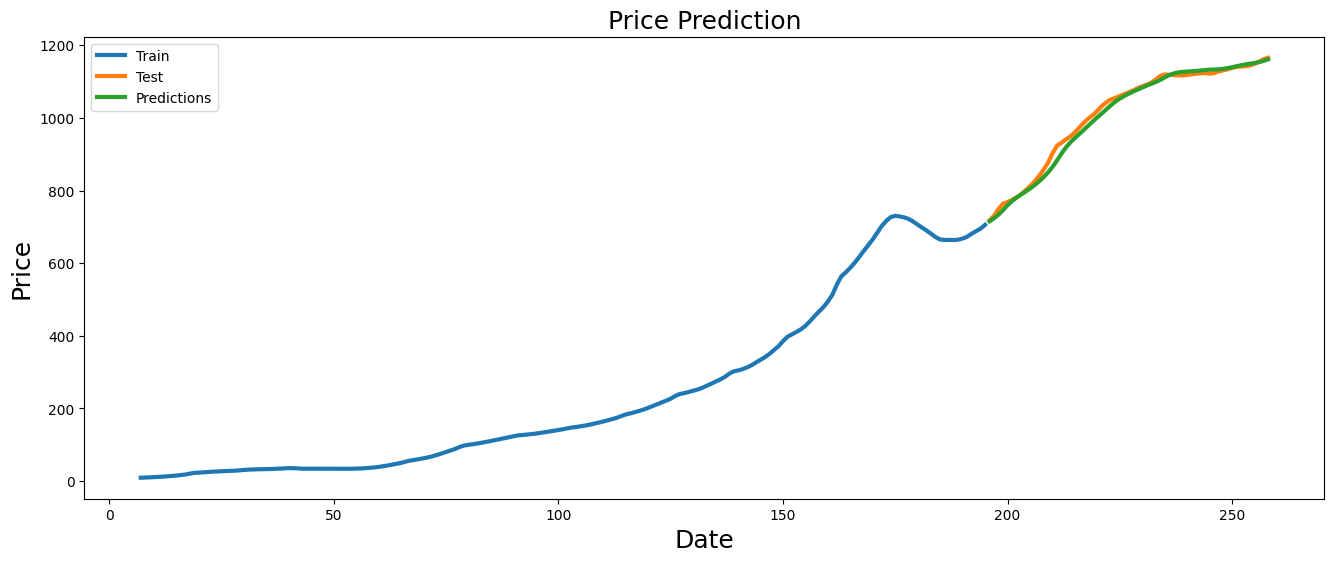

In [ ]:
dataset = trend[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

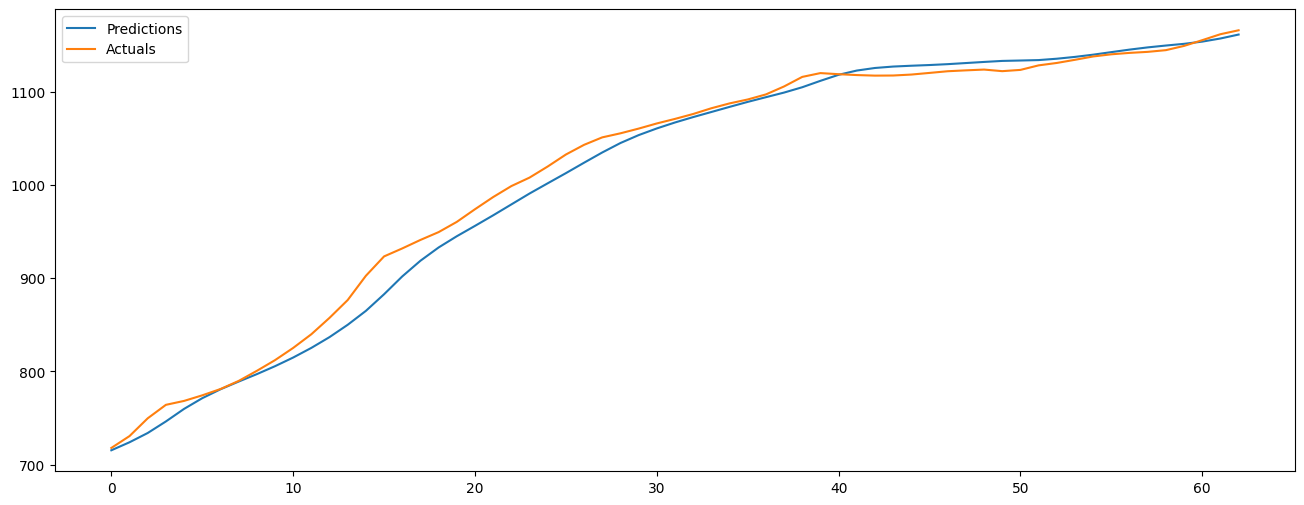

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

2/2 [==============================] - 0s 33ms/step


(63, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

6.504253665984575

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

10.261033541563286

In [ ]:
RMSE_scores["GRU"] = RMSE
MAE_scores["GRU"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions      Actuals
0    715.373901   717.870833
1    723.967041   730.608333
2    733.902100   749.662500
3    746.297485   764.120833
4    759.773682   768.337500
..          ...          ...
58  1149.619995  1144.666667
59  1151.448853  1149.220833
60  1153.829712  1155.379167
61  1157.175659  1161.770833
62  1161.413208  1165.991667

[63 rows x 2 columns]

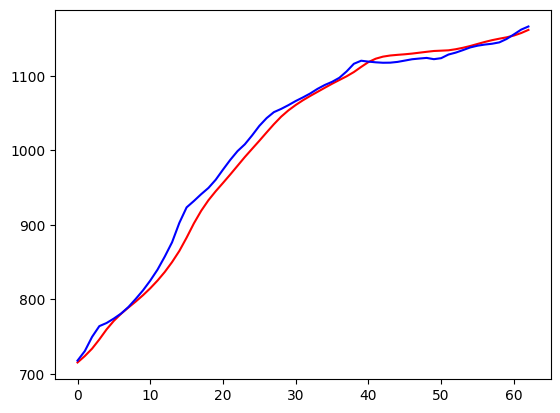

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##BiLSTM

bidirectional LSTM

In [ ]:
# Create BiLSTM model
def create_bilstm(units):
  model = Sequential()

  # Input layer
  model.add(layers.Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))

  # Hidden layer
  model.add(layers.Bidirectional(LSTM(units = units)))
  model.add(Dense(1))

  return model

model = create_bilstm(64)

In [ ]:
#Compile model
model.compile(optimizer="adam",loss="mse")

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
24/24 [==============================] - 13s 166ms/step - loss: 0.0613
Epoch 2/30
24/24 [==============================] - 3s 125ms/step - loss: 0.0032
Epoch 3/30
24/24 [==============================] - 2s 74ms/step - loss: 0.0017
Epoch 4/30
24/24 [==============================] - 2s 72ms/step - loss: 0.0011
Epoch 5/30
24/24 [==============================] - 2s 72ms/step - loss: 7.7645e-04
Epoch 6/30
24/24 [==============================] - 2s 90ms/step - loss: 6.7045e-04
Epoch 7/30
24/24 [==============================] - 4s 150ms/step - loss: 6.5667e-04
Epoch 8/30
24/24 [==============================] - 3s 125ms/step - loss: 6.3734e-04
Epoch 9/30
24/24 [==============================] - 3s 121ms/step - loss: 5.6102e-04
Epoch 10/30
24/24 [==============================] - 2s 100ms/step - loss: 5.4739e-04
Epoch 11/30
24/24 [==============================] - 4s 169ms/step - loss: 5.1991e-04
Epoch 12/30
24/24 [==============================] - 3s 137ms/step - loss: 5.4249e

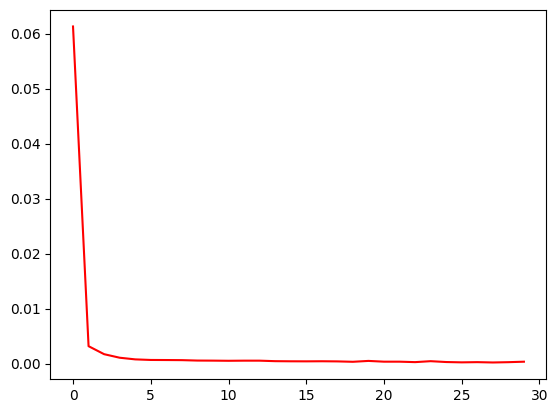

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 2s 34ms/step


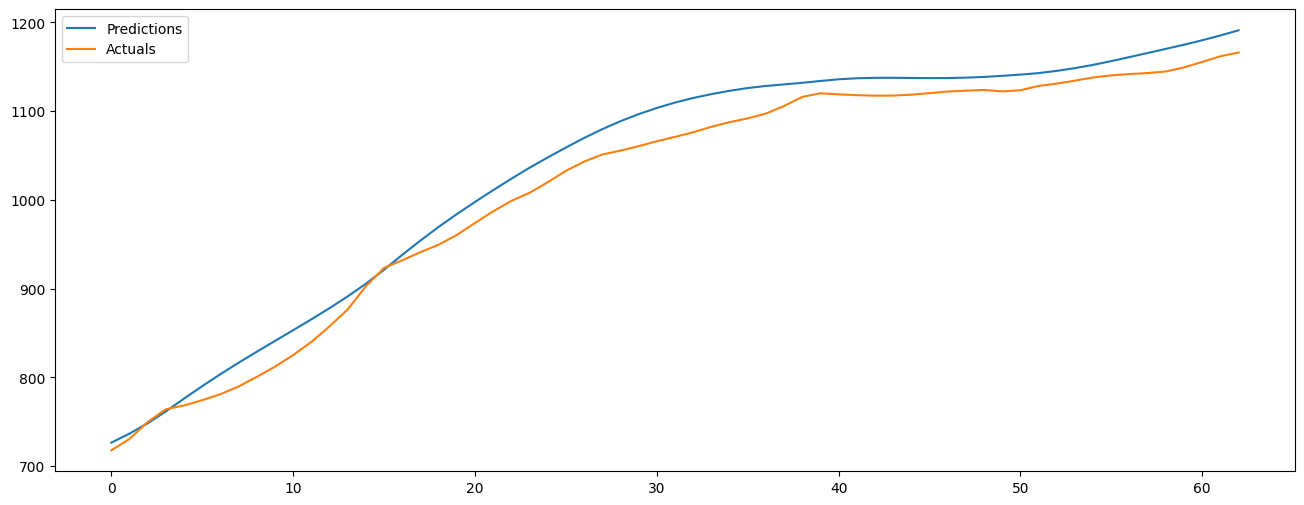

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

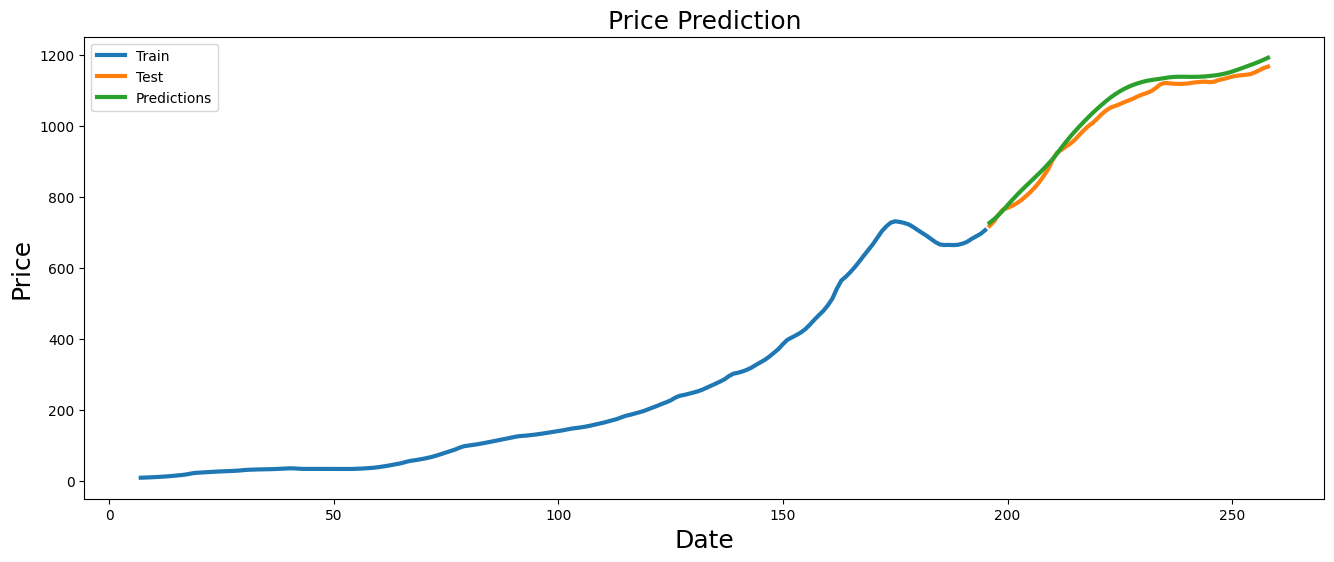

In [ ]:
dataset = trend[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

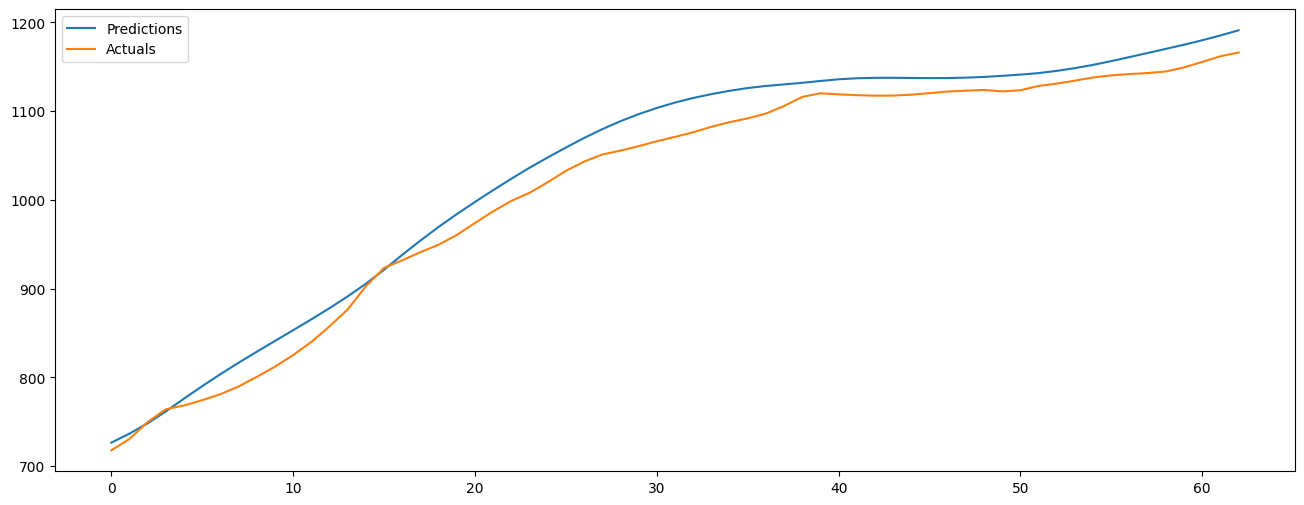

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

2/2 [==============================] - 0s 32ms/step


(63, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

20.78328489273318

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

20.972604063326767

In [ ]:
RMSE_scores["BiLSTM"] = RMSE
MAE_scores["BiLSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions      Actuals
0    726.455688   717.870833
1    736.672485   730.608333
2    748.243042   749.662500
3    761.655823   764.120833
4    776.126770   768.337500
..          ...          ...
58  1170.086914  1144.666667
59  1174.786743  1149.220833
60  1179.779907  1155.379167
61  1185.200928  1161.770833
62  1191.039551  1165.991667

[63 rows x 2 columns]

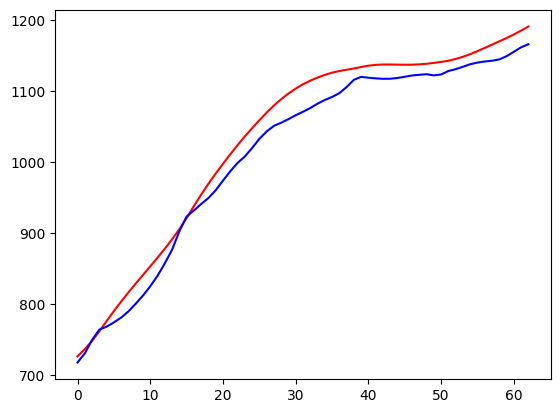

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##better parameters BiLSTM

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss="mse")

also changed batch_size here

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 8)

Epoch 1/50
24/24 [==============================] - 10s 75ms/step - loss: 0.0290
Epoch 2/50
24/24 [==============================] - 2s 76ms/step - loss: 0.0011
Epoch 3/50
24/24 [==============================] - 2s 77ms/step - loss: 3.8213e-04
Epoch 4/50
24/24 [==============================] - 2s 74ms/step - loss: 2.8340e-04
Epoch 5/50
24/24 [==============================] - 2s 74ms/step - loss: 2.6143e-04
Epoch 6/50
24/24 [==============================] - 3s 126ms/step - loss: 1.7657e-04
Epoch 7/50
24/24 [==============================] - 2s 76ms/step - loss: 2.3122e-04
Epoch 8/50
24/24 [==============================] - 2s 75ms/step - loss: 1.6448e-04
Epoch 9/50
24/24 [==============================] - 2s 76ms/step - loss: 1.4015e-04
Epoch 10/50
24/24 [==============================] - 2s 75ms/step - loss: 9.5316e-05
Epoch 11/50
24/24 [==============================] - 2s 76ms/step - loss: 9.1371e-05
Epoch 12/50
24/24 [==============================] - 3s 108ms/step - loss: 1.201

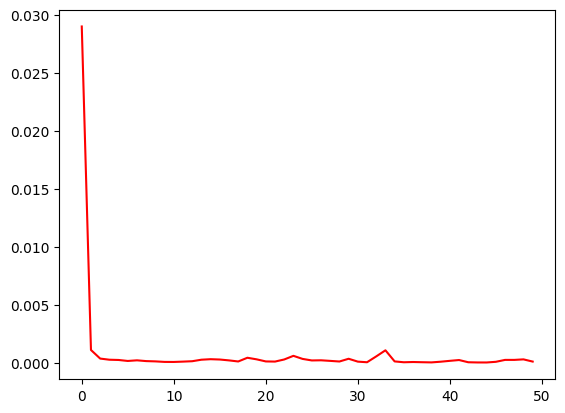

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 2s 57ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

2/2 [==============================] - 0s 36ms/step


(63, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

28.953437344990125

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

28.953437344990125

In [ ]:
RMSE_scores["BiLSTM_new"] = RMSE
MAE_scores["BiLSTM_new"] = MAE

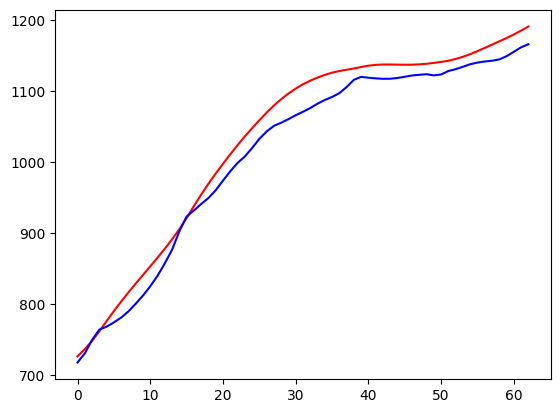

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

In [ ]:
print(RMSE_scores)

{'LSTM': 6.646479143415132, 'another_LSTM': 6.675243946862646, 'GRU': 6.504253665984575, 'BiLSTM': 20.78328489273318, 'BiLSTM_new': 28.953437344990125}


In [ ]:
print(MAE_scores)

{'LSTM': 9.236336069258401, 'another_LSTM': 9.02345099878063, 'GRU': 10.261033541563286, 'BiLSTM': 20.972604063326767, 'BiLSTM_new': 28.953437344990125}


In [ ]:
rmse = {'LSTM': 6.646479143415132, 'another_LSTM': 6.675243946862646, 'GRU': 6.504253665984575, 'BiLSTM': 20.78328489273318, 'BiLSTM_new': 28.953437344990125}
mae = {'LSTM': 9.236336069258401, 'another_LSTM': 9.02345099878063, 'GRU': 10.261033541563286, 'BiLSTM': 20.972604063326767, 'BiLSTM_new': 28.953437344990125}


for i in rmse:
  print("Качество: \\\\")
  print("RMSE:", rmse[i], "\\\\")
  print("MAE:", mae[i], "\\\\")

Качество: \\
RMSE: 6.646479143415132 \\
MAE: 9.236336069258401 \\
Качество: \\
RMSE: 6.675243946862646 \\
MAE: 9.02345099878063 \\
Качество: \\
RMSE: 6.504253665984575 \\
MAE: 10.261033541563286 \\
Качество: \\
RMSE: 20.78328489273318 \\
MAE: 20.972604063326767 \\
Качество: \\
RMSE: 28.953437344990125 \\
MAE: 28.953437344990125 \\


##stacked LSTM

In [ ]:
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(50, return_sequences=True,
               input_shape=(x_train.shape[1], 1)))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50, return_sequences=True))  # returns a sequence of vectors of dimension 50
model.add(LSTM(50))  # return a single vector of dimension 50
model.add(Dense(10))
model.add(Dense(1, activation='softmax'))

In [ ]:
#Compile model
model.compile(optimizer='adam',loss="mse")

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 32)

Epoch 1/50
44/44 [==============================] - 11s 115ms/step - loss: 0.1987
Epoch 2/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 3/50
44/44 [==============================] - 4s 89ms/step - loss: 0.1987
Epoch 4/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 5/50
44/44 [==============================] - 4s 93ms/step - loss: 0.1987
Epoch 6/50
44/44 [==============================] - 4s 85ms/step - loss: 0.1987
Epoch 7/50
44/44 [==============================] - 8s 175ms/step - loss: 0.1987
Epoch 8/50
44/44 [==============================] - 4s 94ms/step - loss: 0.1987
Epoch 9/50
44/44 [==============================] - 5s 112ms/step - loss: 0.1987
Epoch 10/50
44/44 [==============================] - 4s 86ms/step - loss: 0.1987
Epoch 11/50
44/44 [==============================] - 4s 87ms/step - loss: 0.1987
Epoch 12/50
44/44 [==============================] - 5s 114ms/step - loss: 0.1987
Epoch 13/50
44/44 [============

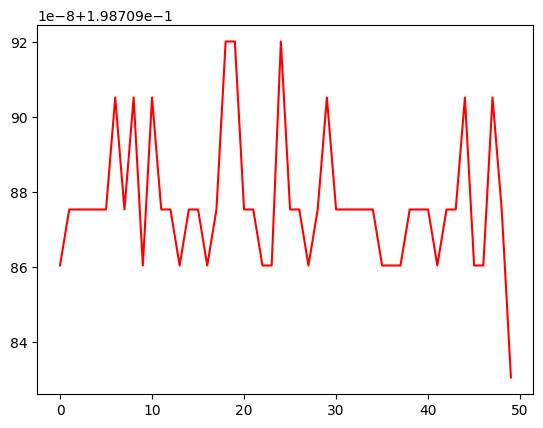

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

12/12 [==============================] - 2s 26ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 [==============================] - 0s 33ms/step


(366, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

11.623790591636126

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

11.623790591636126

In [ ]:
# RMSE_scores["stacked_LSTM"] = RMSE
# MAE_scores["stacked_LSTM"] = MAE

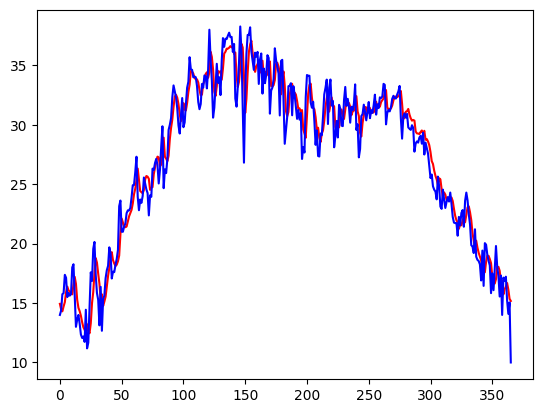

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

#Scores

##overall

In [ ]:
RMSE_scores["ARIMA"] = 39.81417
MAE_scores["ARIMA"] = 28.28481

In [ ]:
RMSE_scores["ETS"] = 19.65994
MAE_scores["ETS"] = 16.54448

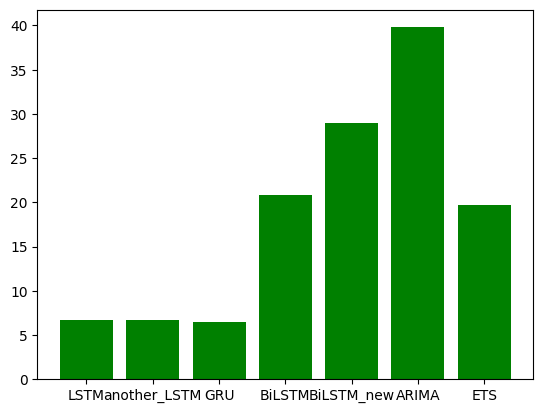

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(RMSE_scores.keys()), RMSE_scores.values(), color='g')
plt.show()

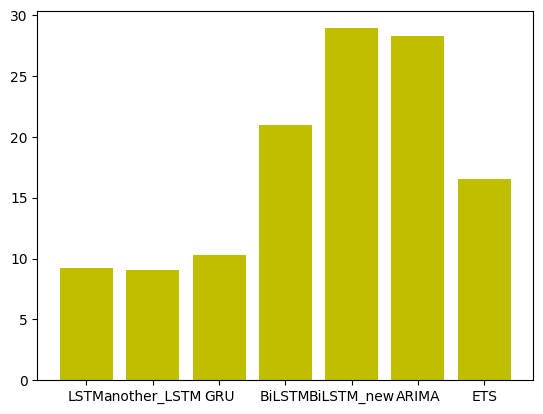

In [ ]:
plt.bar(list(MAE_scores.keys()), MAE_scores.values(), color='y')
plt.show()

In [ ]:
print(RMSE_scores)
print(MAE_scores)

{'LSTM': 6.646479143415132, 'another_LSTM': 6.675243946862646, 'GRU': 6.504253665984575, 'BiLSTM': 20.78328489273318, 'BiLSTM_new': 28.953437344990125, 'ARIMA': 39.81417, 'ETS': 19.65994}
{'LSTM': 9.236336069258401, 'another_LSTM': 9.02345099878063, 'GRU': 10.261033541563286, 'BiLSTM': 20.972604063326767, 'BiLSTM_new': 28.953437344990125, 'ARIMA': 28.28481, 'ETS': 16.54448}


In [ ]:
RMSE_nn_scores = {'LSTM': 6.646479143415132, 'another_LSTM': 6.675243946862646, 'GRU': 6.504253665984575, 'BiLSTM': 20.78328489273318, 'BiLSTM_new': 28.953437344990125}
MAE_nn_scores = {'LSTM': 9.236336069258401, 'another_LSTM': 9.02345099878063, 'GRU': 10.261033541563286, 'BiLSTM': 20.972604063326767, 'BiLSTM_new': 28.953437344990125}

##RNNs

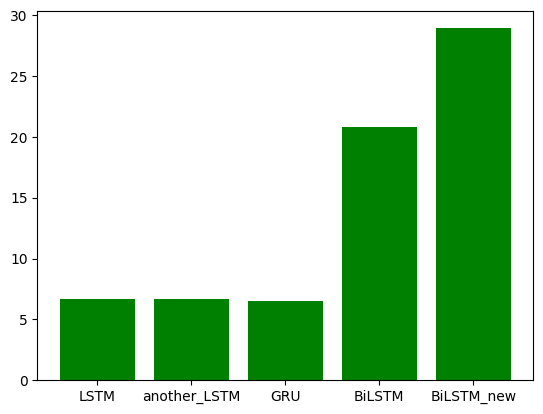

In [ ]:
plt.bar(list(RMSE_nn_scores.keys()), RMSE_nn_scores.values(), color='g')
plt.show()

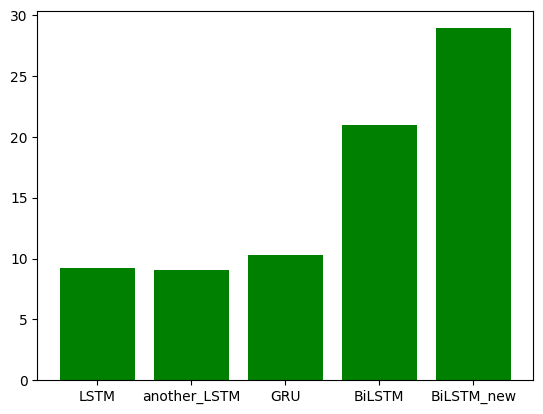

In [ ]:
plt.bar(list(MAE_nn_scores.keys()), MAE_nn_scores.values(), color='g')
plt.show()

#CPI_M_CHI

In [ ]:
df = pd.read_csv('/content/CPI_M_CHI.csv')

#df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)

In [ ]:
df

CPI_M_CHI
Date           
1         345.0
2         138.0
3         130.0
4         122.0
5         112.0
...         ...
372       100.8
373       100.8
374       100.5
375       100.4
376       100.4

[376 rows x 1 columns]

In [ ]:
predicting_col='CPI_M_CHI'

#decomposition

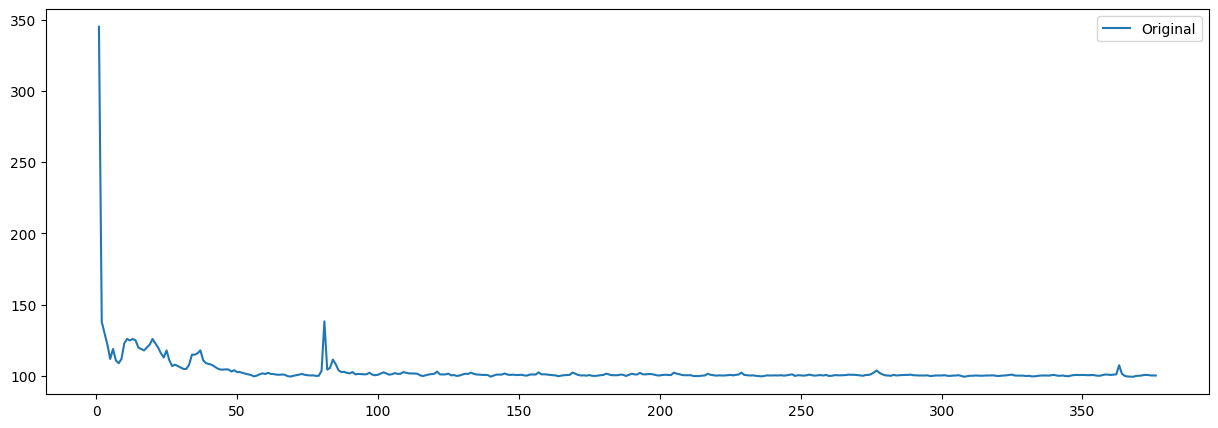

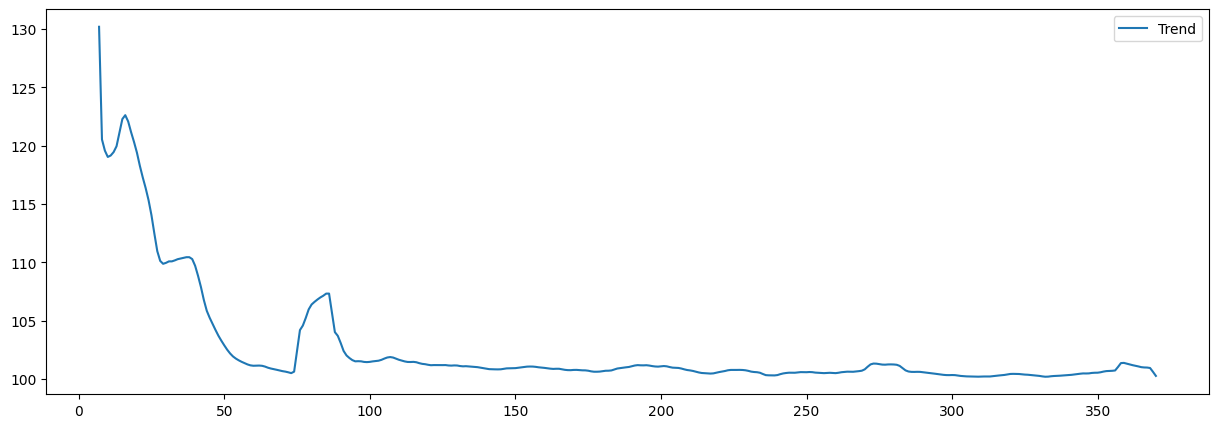

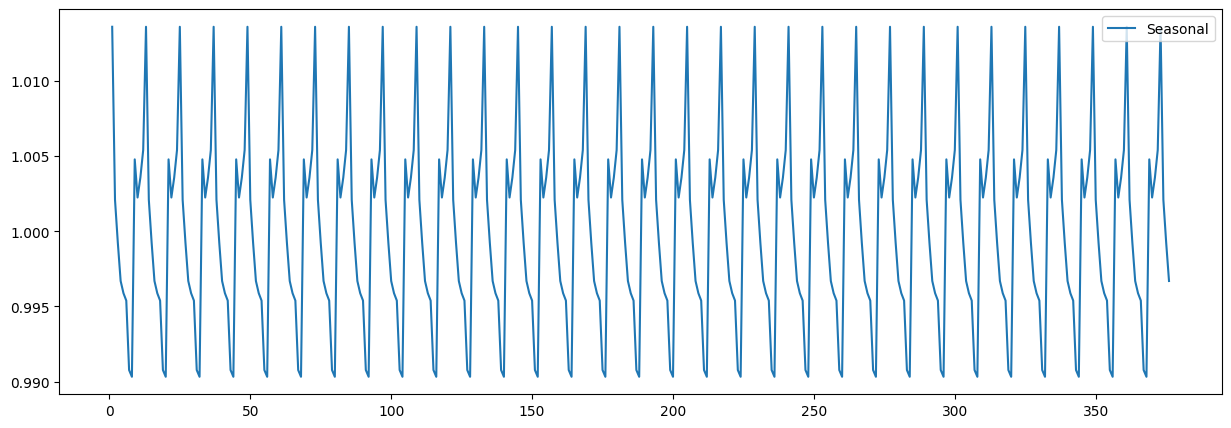

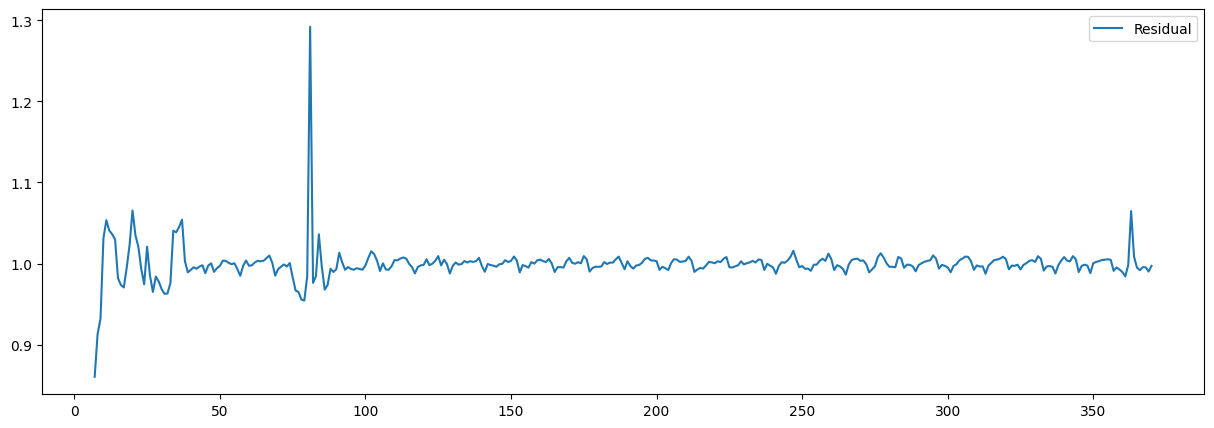

In [ ]:
ts_decomposition = seasonal_decompose(x=df[predicting_col], model='multiplicative', period=12)
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

plt.figure(figsize=(15,5))
plt.plot(df[predicting_col], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

In [ ]:
x_train, y_train, scaler, train_size, test_size, scaled_data = prepare_data(df, predicting_col)

In [ ]:
train_size

282

In [ ]:
test_size

94

In [ ]:
scaled_data

#Models

In [ ]:
RMSE_scores = {}
MAE_scores = {}

##LSTM

In [ ]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
40/40 [==============================] - 18s 120ms/step - loss: 1.1260e-04
Epoch 2/30
40/40 [==============================] - 4s 92ms/step - loss: 9.8879e-05
Epoch 3/30
40/40 [==============================] - 4s 100ms/step - loss: 9.3819e-05
Epoch 4/30
40/40 [==============================] - 3s 86ms/step - loss: 1.0862e-04
Epoch 5/30
40/40 [==============================] - 3s 86ms/step - loss: 1.0374e-04
Epoch 6/30
40/40 [==============================] - 4s 105ms/step - loss: 9.7271e-05
Epoch 7/30
40/40 [==============================] - 4s 91ms/step - loss: 8.9167e-05
Epoch 8/30
40/40 [==============================] - 3s 87ms/step - loss: 9.4620e-05
Epoch 9/30
40/40 [==============================] - 4s 88ms/step - loss: 9.4988e-05
Epoch 10/30
40/40 [==============================] - 4s 106ms/step - loss: 1.0113e-04
Epoch 11/30
40/40 [==============================] - 3s 83ms/step - loss: 9.6796e-05
Epoch 12/30
40/40 [==============================] - 3s 85ms/step - l

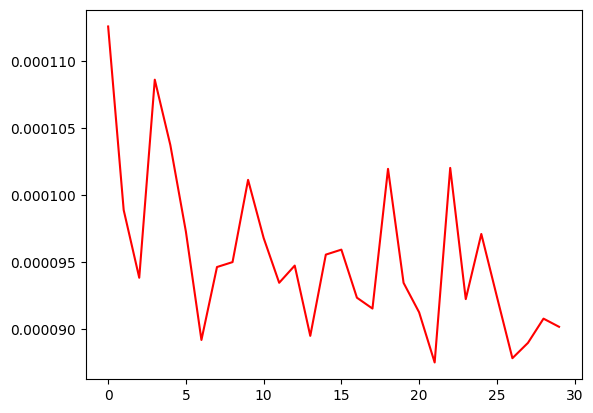

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 30ms/step


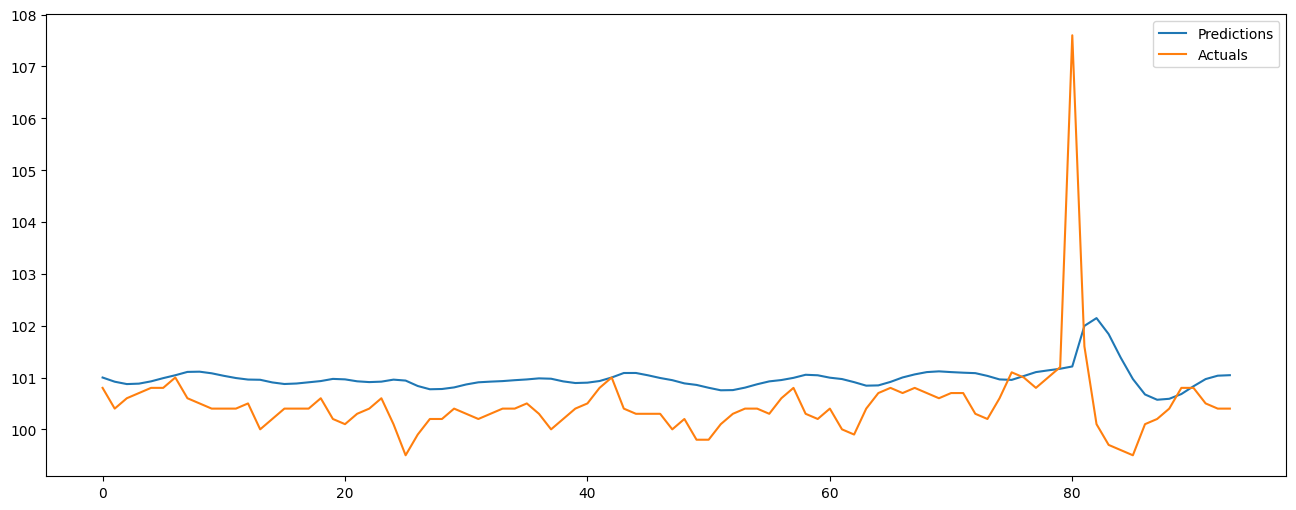

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

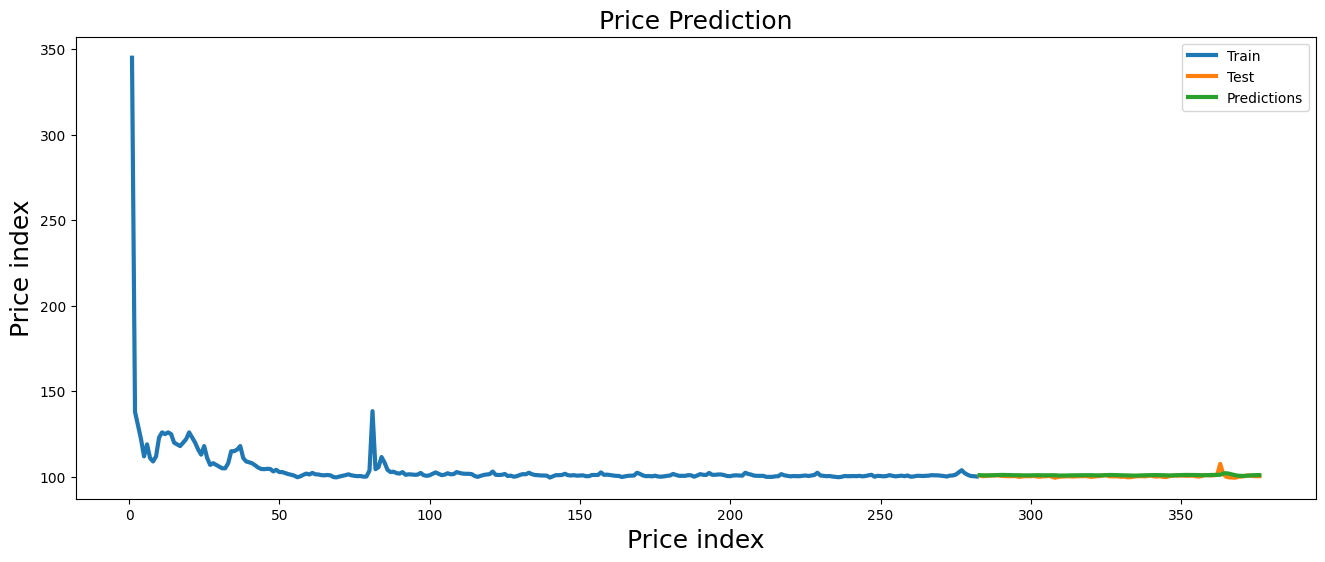

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Price index', fontsize= 18)
plt.ylabel('Price index', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

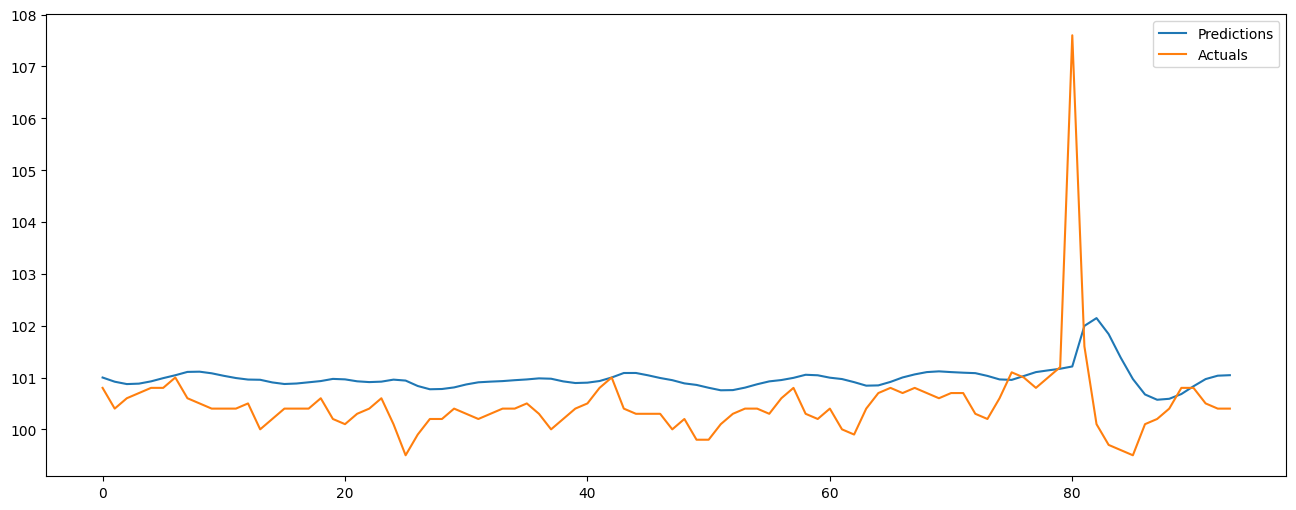

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

3/3 [==============================] - 0s 21ms/step


(94, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(94, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean(y_test - predictions)**2)
RMSE

0.49607112154047517

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

0.6382722245885967

In [ ]:
RMSE_scores["LSTM"] = RMSE
MAE_scores["LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0    100.999649    100.8
1    100.918930    100.4
2    100.873077    100.6
3    100.881653    100.7
4    100.925667    100.8
..          ...      ...
89   100.681107    100.8
90   100.831192    100.8
91   100.969452    100.5
92   101.034912    100.4
93   101.044662    100.4

[94 rows x 2 columns]

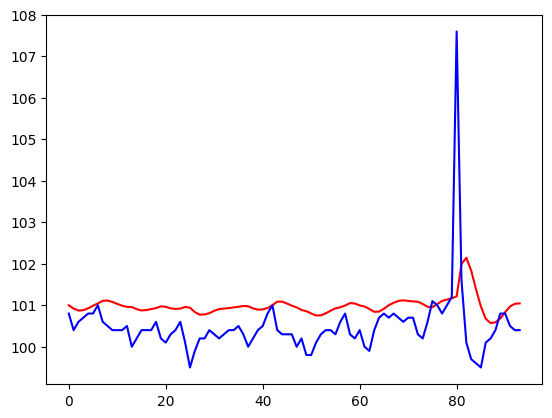

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##another LSTM

In [ ]:
model = Sequential([
    LSTM(units=24, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(units=24, return_sequences=False),
    Dense(units=24),
    Dense(units=1)
])

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
40/40 [==============================] - 13s 97ms/step - loss: 1.1174e-04
Epoch 2/30
40/40 [==============================] - 5s 120ms/step - loss: 1.0573e-04
Epoch 3/30
40/40 [==============================] - 3s 85ms/step - loss: 9.9065e-05
Epoch 4/30
40/40 [==============================] - 3s 81ms/step - loss: 1.0236e-04
Epoch 5/30
40/40 [==============================] - 4s 96ms/step - loss: 9.6366e-05
Epoch 6/30
40/40 [==============================] - 5s 112ms/step - loss: 9.5595e-05
Epoch 7/30
40/40 [==============================] - 3s 88ms/step - loss: 9.6924e-05
Epoch 8/30
40/40 [==============================] - 4s 89ms/step - loss: 1.0063e-04
Epoch 9/30
40/40 [==============================] - 5s 118ms/step - loss: 9.4056e-05
Epoch 10/30
40/40 [==============================] - 4s 90ms/step - loss: 9.8815e-05
Epoch 11/30
40/40 [==============================] - 3s 85ms/step - loss: 8.9629e-05
Epoch 12/30
40/40 [==============================] - 4s 96ms/step - lo

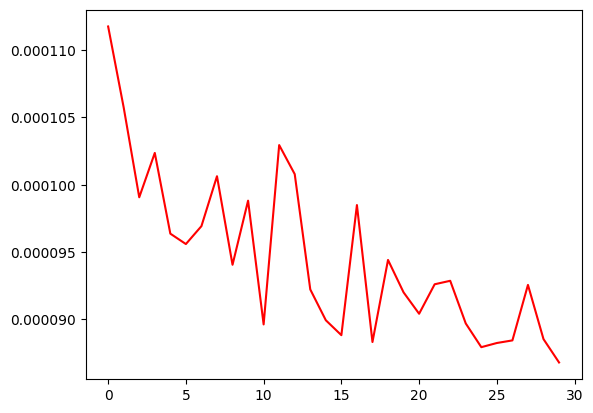

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 22ms/step


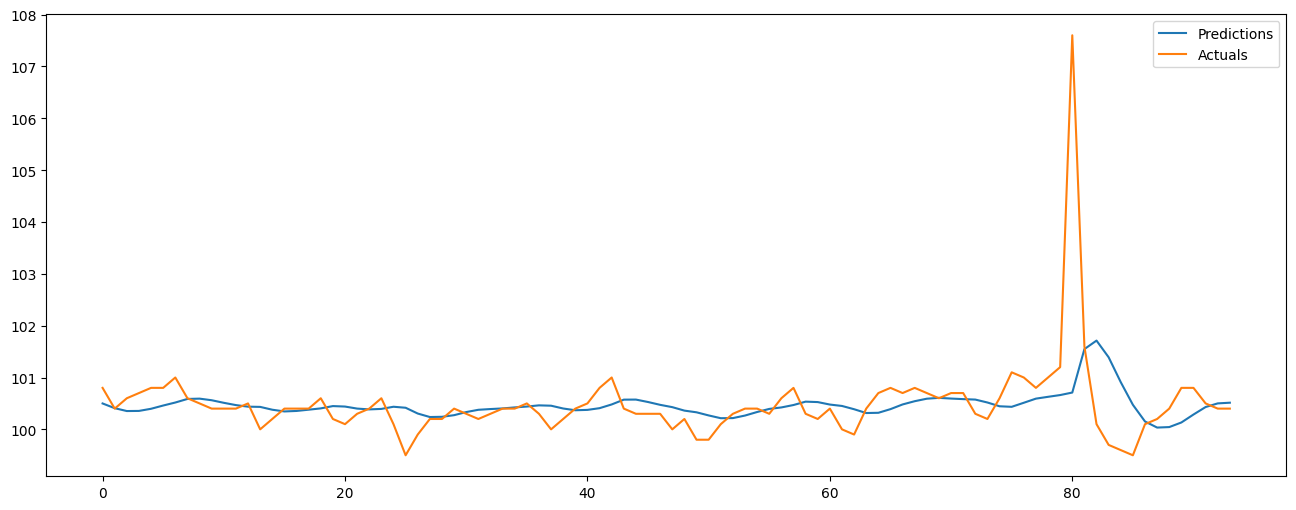

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

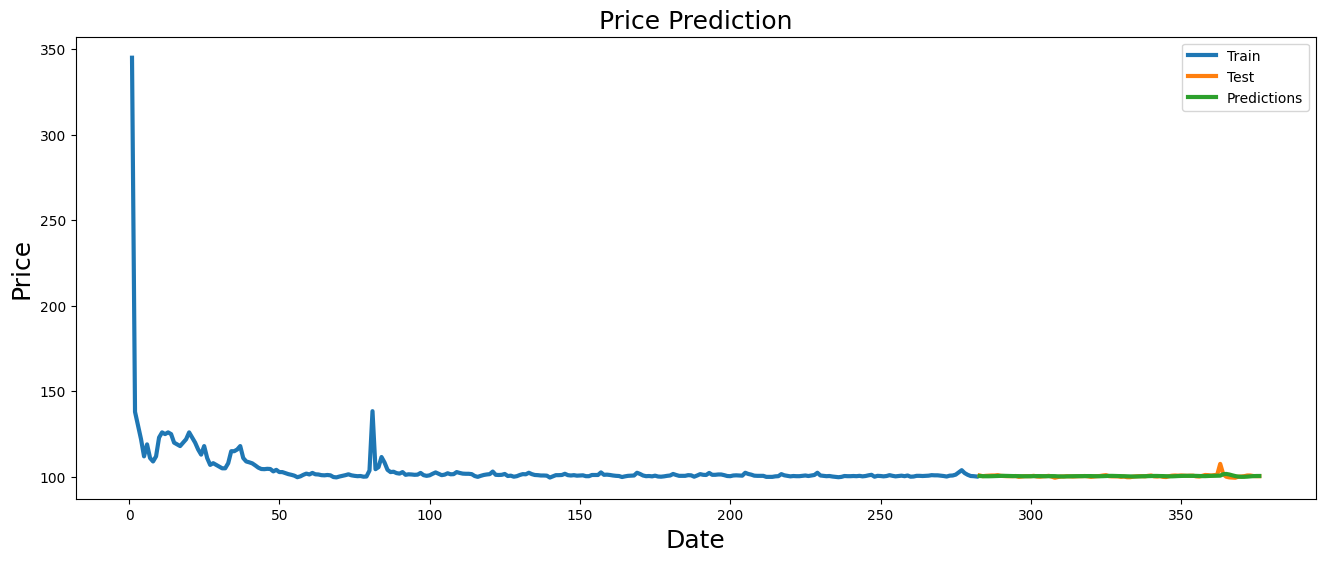

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

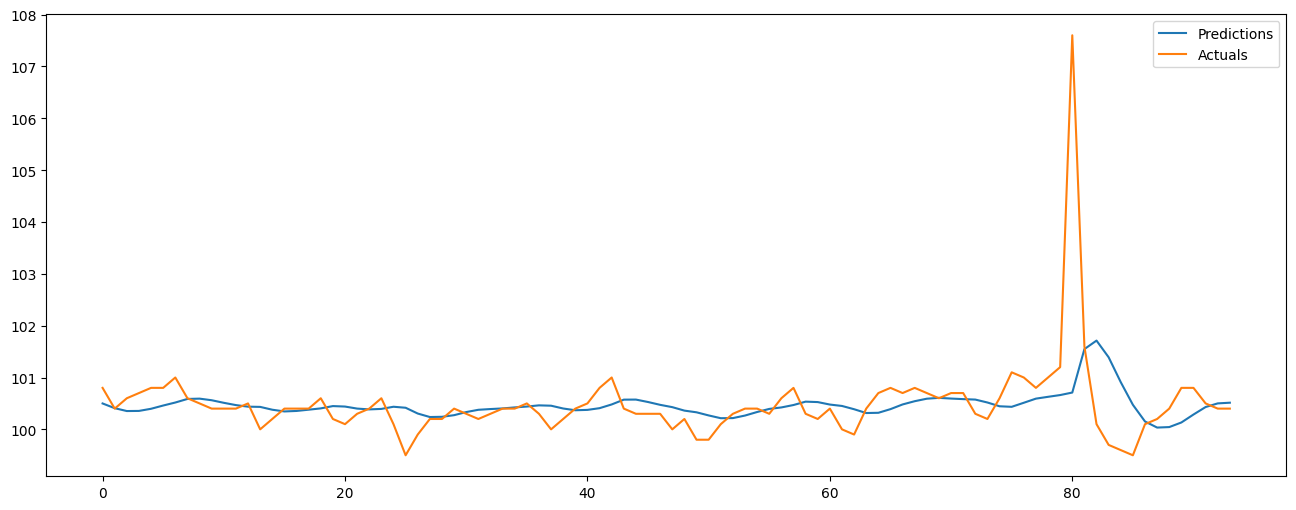

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

3/3 [==============================] - 0s 32ms/step


(94, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(94, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.024479951249792433

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

0.3500500455815739

In [ ]:
RMSE_scores["another_LSTM"] = RMSE
MAE_scores["another_LSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0    100.499374    100.8
1    100.408501    100.4
2    100.352966    100.6
3    100.355461    100.7
4    100.396896    100.8
..          ...      ...
89   100.132538    100.8
90   100.286087    100.8
91   100.430542    100.5
92   100.500732    100.4
93   100.513893    100.4

[94 rows x 2 columns]

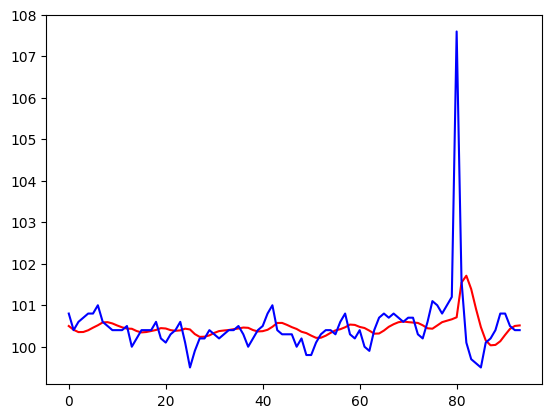

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##GRU

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()

    # Input layer
    model.add(layers.GRU(units = units, return_sequences = True,
    input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(layers.Dropout(0.2))

    # Hidden layer
    model.add(layers.GRU(units = units))
    model.add(layers.Dropout(0.2))
    model.add(Dense(units = 1))

    #Compile model
    #model.compile(optimizer='adam',loss='mse')
    return model
model = create_gru(64)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
40/40 [==============================] - 9s 105ms/step - loss: 1.1239e-04
Epoch 2/30
40/40 [==============================] - 4s 108ms/step - loss: 1.0852e-04
Epoch 3/30
40/40 [==============================] - 4s 101ms/step - loss: 1.1527e-04
Epoch 4/30
40/40 [==============================] - 5s 130ms/step - loss: 1.0344e-04
Epoch 5/30
40/40 [==============================] - 4s 101ms/step - loss: 1.0738e-04
Epoch 6/30
40/40 [==============================] - 4s 107ms/step - loss: 9.8173e-05
Epoch 7/30
40/40 [==============================] - 5s 129ms/step - loss: 1.0700e-04
Epoch 8/30
40/40 [==============================] - 4s 107ms/step - loss: 1.1469e-04
Epoch 9/30
40/40 [==============================] - 4s 107ms/step - loss: 1.0368e-04
Epoch 10/30
40/40 [==============================] - 5s 127ms/step - loss: 1.0552e-04
Epoch 11/30
40/40 [==============================] - 5s 127ms/step - loss: 1.0487e-04
Epoch 12/30
40/40 [==============================] - 5s 120ms/s

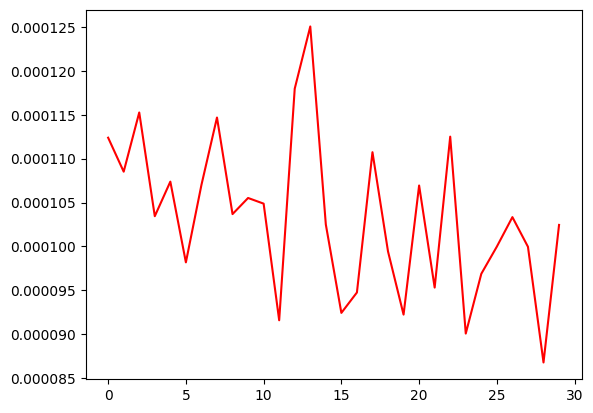

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 19ms/step


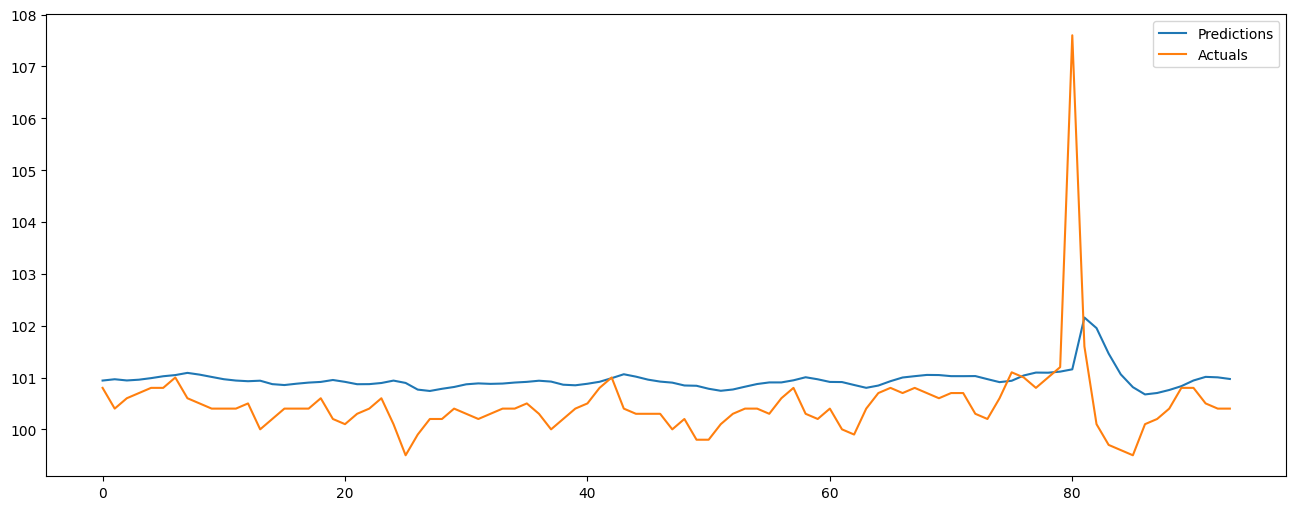

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

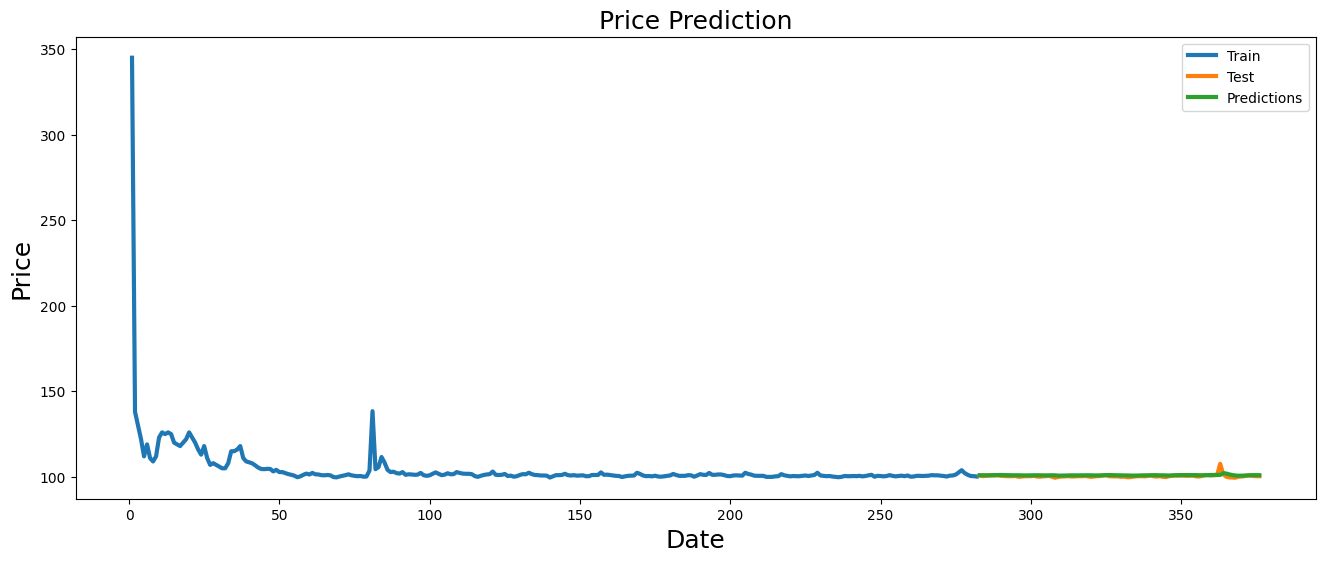

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

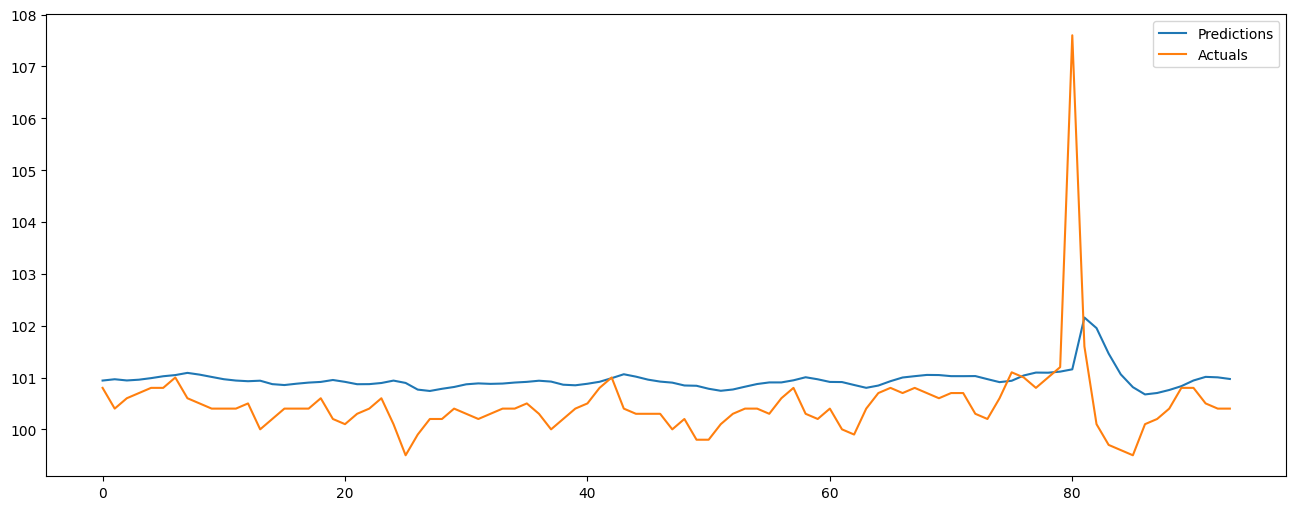

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

3/3 [==============================] - 0s 18ms/step


(94, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(94, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)
RMSE

0.4663050387768033

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

0.6089597499116934

In [ ]:
RMSE_scores["GRU"] = RMSE
MAE_scores["GRU"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0    100.941170    100.8
1    100.966316    100.4
2    100.942978    100.6
3    100.957634    100.7
4    100.987793    100.8
..          ...      ...
89   100.833229    100.8
90   100.942390    100.8
91   101.012184    100.5
92   101.003090    100.4
93   100.971626    100.4

[94 rows x 2 columns]

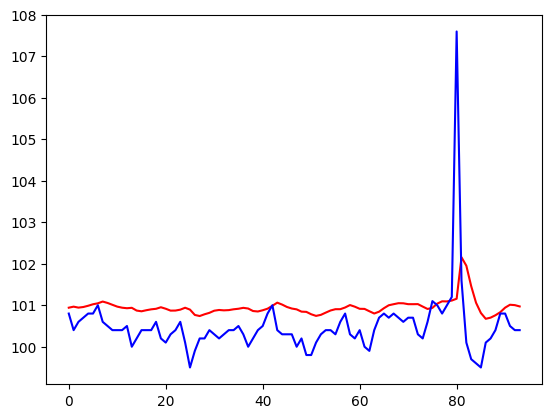

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##BiLSTM

bidirectional LSTM

In [ ]:
# Create BiLSTM model
def create_bilstm(units):
  model = Sequential()

  # Input layer
  model.add(layers.Bidirectional(
              LSTM(units = units, return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))

  # Hidden layer
  model.add(layers.Bidirectional(LSTM(units = units)))
  model.add(Dense(1))

  return model

model = create_bilstm(64)

In [ ]:
#Compile model
model.compile(optimizer="adam",loss="mse")

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs= 30, batch_size= 8)

Epoch 1/30
40/40 [==============================] - 13s 102ms/step - loss: 1.2543e-04
Epoch 2/30
40/40 [==============================] - 5s 138ms/step - loss: 1.0352e-04
Epoch 3/30
40/40 [==============================] - 4s 100ms/step - loss: 1.0079e-04
Epoch 4/30
40/40 [==============================] - 4s 102ms/step - loss: 9.0707e-05
Epoch 5/30
40/40 [==============================] - 5s 136ms/step - loss: 1.0019e-04
Epoch 6/30
40/40 [==============================] - 4s 101ms/step - loss: 9.5720e-05
Epoch 7/30
40/40 [==============================] - 4s 102ms/step - loss: 9.5095e-05
Epoch 8/30
40/40 [==============================] - 5s 137ms/step - loss: 9.2395e-05
Epoch 9/30
40/40 [==============================] - 4s 104ms/step - loss: 9.3968e-05
Epoch 10/30
40/40 [==============================] - 4s 105ms/step - loss: 8.8565e-05
Epoch 11/30
40/40 [==============================] - 5s 133ms/step - loss: 9.1164e-05
Epoch 12/30
40/40 [==============================] - 4s 101ms/

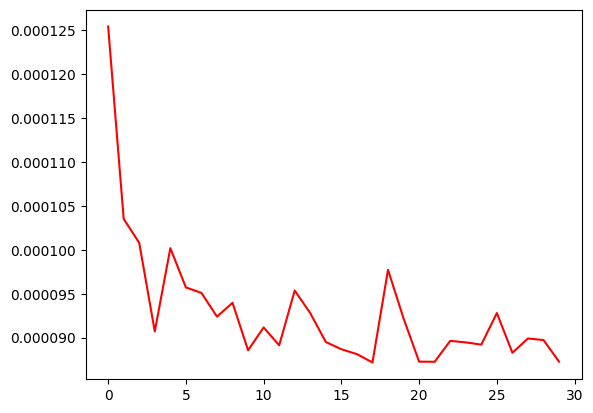

In [ ]:
plt.plot(range(0, 30), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 38ms/step


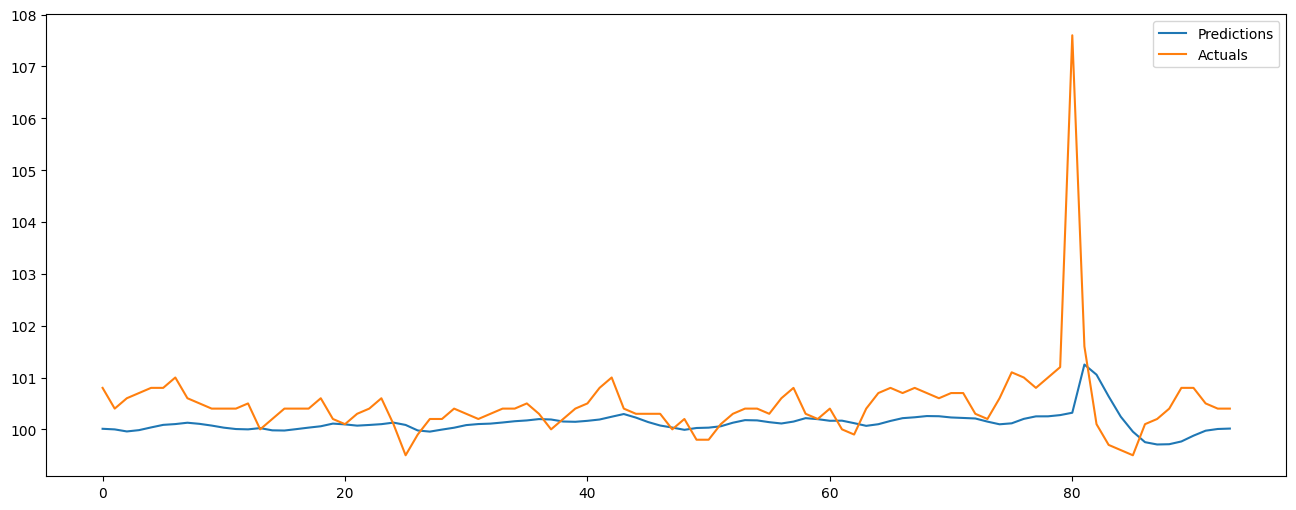

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

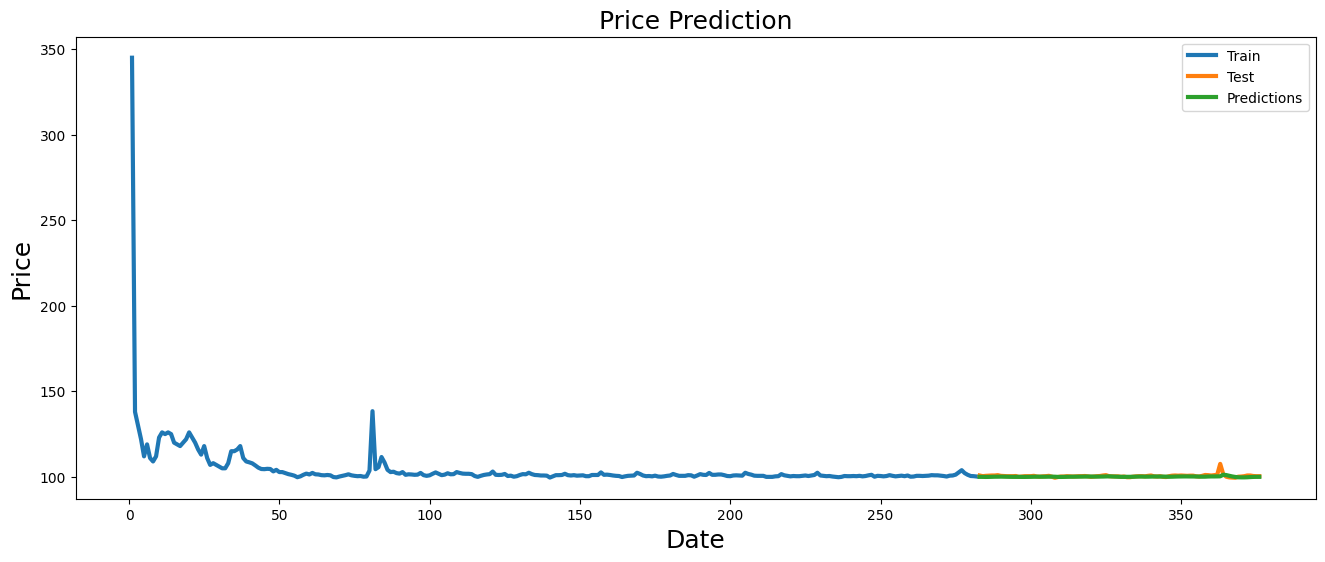

In [ ]:
dataset = df[predicting_col]
dataset = pd.DataFrame(dataset)

train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Price', fontsize= 18)
plt.plot(train[predicting_col], linewidth= 3)
plt.plot(test[predicting_col], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

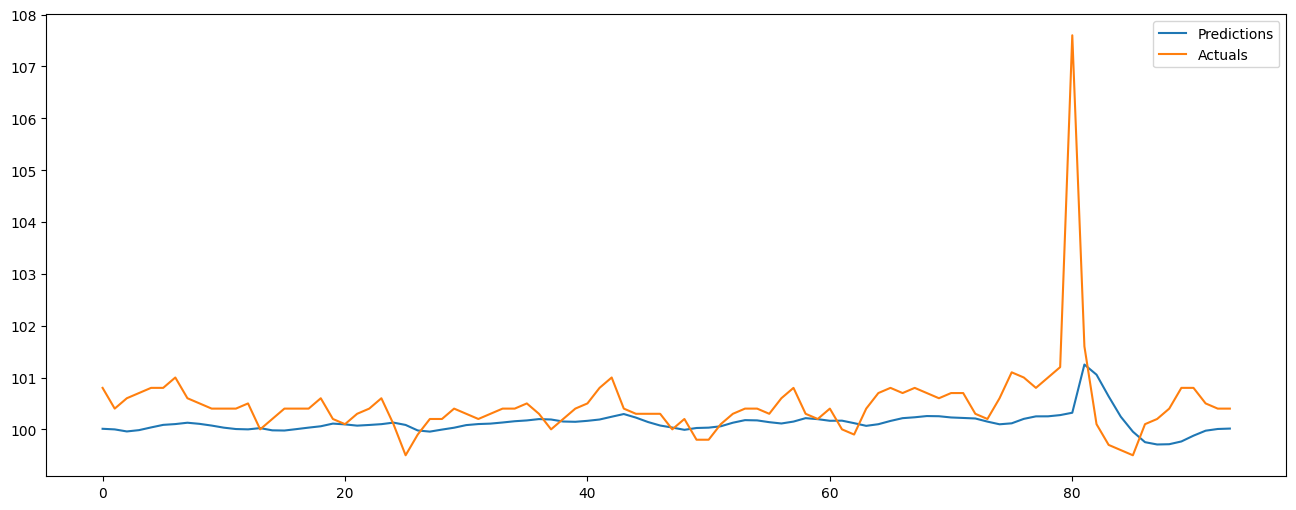

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})

plt.figure(figsize = (16, 6))
plt.plot(preds_acts['Predictions'])
plt.plot(preds_acts['Actuals'])
plt.legend(['Predictions', 'Actuals'])
plt.show()

In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
# Get Prediction
predictions = model.predict(x_test)

predictions.shape

3/3 [==============================] - 0s 41ms/step


(94, 1)

In [ ]:
#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

(94, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

0.36624833776595767

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

0.467908753740027

In [ ]:
RMSE_scores["BiLSTM"] = RMSE
MAE_scores["BiLSTM"] = MAE

In [ ]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

Predictions  Actuals
0    100.010788    100.8
1     99.999107    100.4
2     99.959702    100.6
3     99.984695    100.7
4    100.037132    100.8
..          ...      ...
89    99.766525    100.8
90    99.878220    100.8
91    99.974167    100.5
92   100.007042    100.4
93   100.014999    100.4

[94 rows x 2 columns]

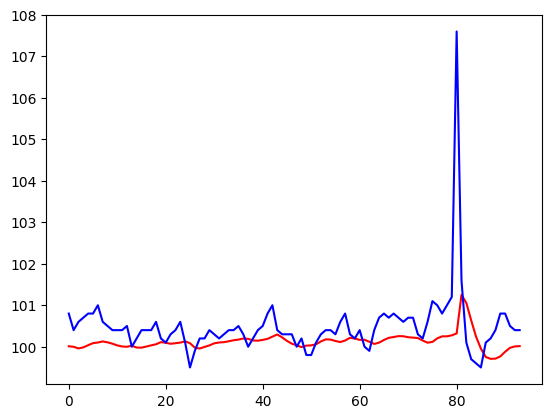

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

##better parameters BiLSTM

In [ ]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),loss="mse")

also changed batch_size here

In [ ]:
history = model.fit(x_train, y_train, epochs= 50, batch_size= 8)

Epoch 1/50
40/40 [==============================] - 23s 206ms/step - loss: 1.8348e-04
Epoch 2/50
40/40 [==============================] - 7s 176ms/step - loss: 1.1699e-04
Epoch 3/50
40/40 [==============================] - 8s 203ms/step - loss: 1.1183e-04
Epoch 4/50
40/40 [==============================] - 7s 177ms/step - loss: 1.2985e-04
Epoch 5/50
40/40 [==============================] - 8s 205ms/step - loss: 1.0254e-04
Epoch 6/50
40/40 [==============================] - 7s 182ms/step - loss: 1.1137e-04
Epoch 7/50
40/40 [==============================] - 8s 200ms/step - loss: 9.7841e-05
Epoch 8/50
40/40 [==============================] - 8s 204ms/step - loss: 1.0276e-04
Epoch 9/50
40/40 [==============================] - 7s 172ms/step - loss: 1.4603e-04
Epoch 10/50
40/40 [==============================] - 8s 203ms/step - loss: 9.7742e-05
Epoch 11/50
40/40 [==============================] - 7s 173ms/step - loss: 9.7904e-05
Epoch 12/50
40/40 [==============================] - 8s 204ms/

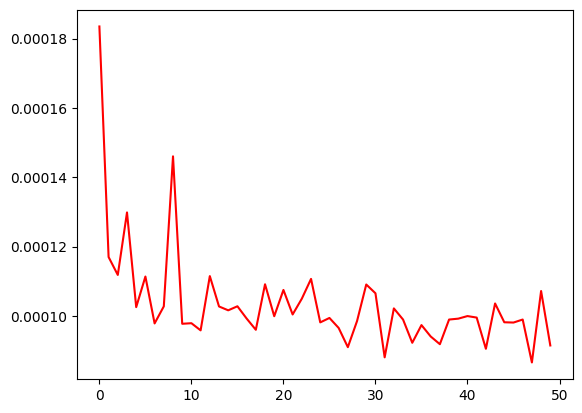

In [ ]:
plt.plot(range(0, 50), history.history['loss'], c='r')
plt.show()

In [ ]:
x_test, y_test = generate_forecast(scaled_data, train_size)

y_test = scaler.inverse_transform(y_test)
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 2s 33ms/step


In [ ]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [ ]:
#inverse predictions scaling
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions.shape

3/3 [==============================] - 0s 37ms/step


(94, 1)

In [ ]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)
RMSE = np.sqrt(np.mean( y_test - predictions )**2)#.round(2)
RMSE

1.5016154674773525

In [ ]:
MAE = np.mean(abs(y_test - predictions))
MAE

1.5016154674773525

In [ ]:
RMSE_scores["BiLSTM_new"] = RMSE
MAE_scores["BiLSTM_new"] = MAE

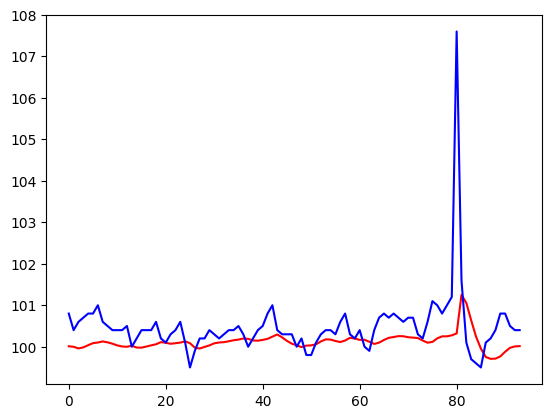

In [ ]:
plt.plot(preds_acts.index, preds_acts.Predictions, c='r')
plt.plot(preds_acts.index, preds_acts.Actuals, c='b')
plt.show()

In [ ]:
print(RMSE_scores)

{'LSTM': 0.49607112154047517, 'another_LSTM': 0.024479951249792433, 'GRU': 0.4663050387768033, 'BiLSTM': 0.36624833776595767, 'BiLSTM_new': 1.5016154674773525}


In [ ]:
print(MAE_scores)

{'LSTM': 0.6382722245885967, 'another_LSTM': 0.3500500455815739, 'GRU': 0.6089597499116934, 'BiLSTM': 0.467908753740027, 'BiLSTM_new': 1.5016154674773525}


In [ ]:
RMSE_scores = {'LSTM': 0.49607112154047517, 'another_LSTM': 0.024479951249792433, 'GRU': 0.4663050387768033, 'BiLSTM': 0.36624833776595767, 'BiLSTM_new': 1.5016154674773525}
MAE_scores = {'LSTM': 0.6382722245885967, 'another_LSTM': 0.3500500455815739, 'GRU': 0.6089597499116934, 'BiLSTM': 0.467908753740027, 'BiLSTM_new': 1.5016154674773525}


for i in rmse:
  print("Качество: \\\\")
  print("RMSE:", rmse[i], "\\\\")
  print("MAE:", mae[i], "\\\\")

Качество: \\
RMSE: 0.49607112154047517 \\
MAE: 0.6382722245885967 \\
Качество: \\
RMSE: 0.024479951249792433 \\
MAE: 0.3500500455815739 \\
Качество: \\
RMSE: 0.4663050387768033 \\
MAE: 0.6089597499116934 \\
Качество: \\
RMSE: 0.36624833776595767 \\
MAE: 0.467908753740027 \\
Качество: \\
RMSE: 1.5016154674773525 \\
MAE: 1.5016154674773525 \\


##Scores

##overall

In [ ]:
RMSE_scores["ARIMA"] =  2.826317
MAE_scores["ARIMA"] = 2.443597

In [ ]:
RMSE_scores["ETS"] = 2.800738
MAE_scores["ETS"] = 2.770085

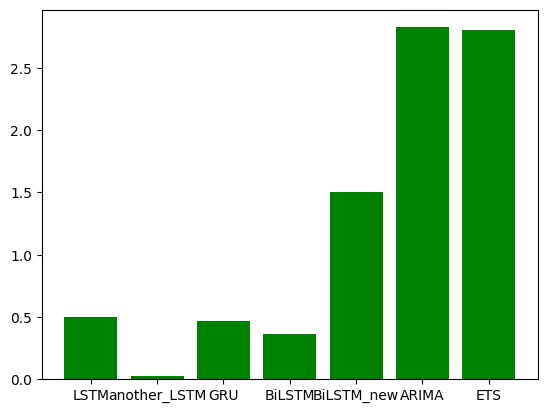

In [ ]:
import matplotlib.pyplot as plt

plt.bar(list(RMSE_scores.keys()), RMSE_scores.values(), color='g')
plt.show()

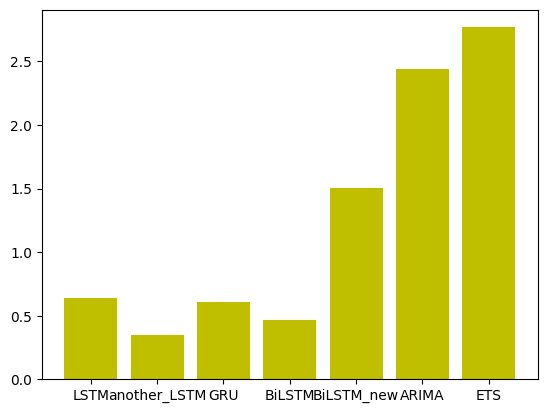

In [ ]:
plt.bar(list(MAE_scores.keys()), MAE_scores.values(), color='y')
plt.show()

In [ ]:
print(RMSE_scores)
print(MAE_scores)

{'LSTM': 0.49607112154047517, 'another_LSTM': 0.024479951249792433, 'GRU': 0.4663050387768033, 'BiLSTM': 0.36624833776595767, 'BiLSTM_new': 1.5016154674773525, 'ARIMA': 1.4602461, 'ETS': 2.800738}
{'LSTM': 0.6382722245885967, 'another_LSTM': 0.3500500455815739, 'GRU': 0.6089597499116934, 'BiLSTM': 0.467908753740027, 'BiLSTM_new': 1.5016154674773525, 'ARIMA': 1.3051619, 'ETS': 2.770085}


In [ ]:
RMSE_nn_scores = {'LSTM': 0.49607112154047517, 'another_LSTM': 0.024479951249792433, 'GRU': 0.4663050387768033, 'BiLSTM': 0.36624833776595767, 'BiLSTM_new': 1.5016154674773525}
MAE_nn_scores = {'LSTM': 0.6382722245885967, 'another_LSTM': 0.3500500455815739, 'GRU': 0.6089597499116934, 'BiLSTM': 0.467908753740027, 'BiLSTM_new': 1.5016154674773525}

##RNNs

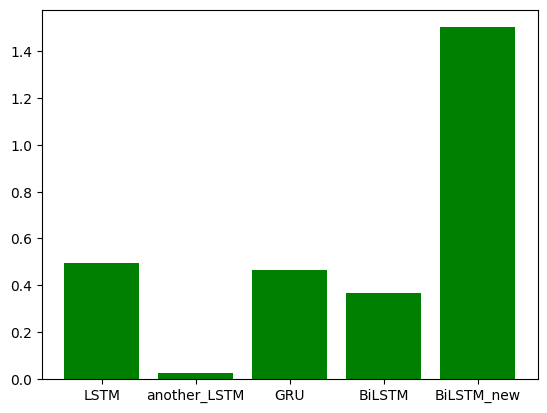

In [ ]:
plt.bar(list(RMSE_nn_scores.keys()), RMSE_nn_scores.values(), color='g')
plt.show()

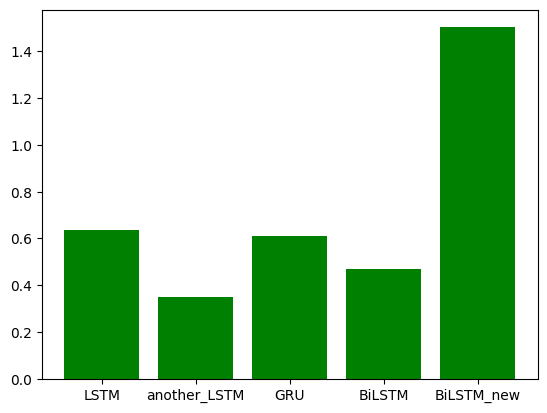

In [ ]:
plt.bar(list(MAE_nn_scores.keys()), MAE_nn_scores.values(), color='g')
plt.show()